In [1]:
# !pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric torch-frame
# !pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu118
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.2+cu118.html
# !pip install -U pygad pytorch-frame catboost xgboost scikit-learn imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import torch_frame
from torch_frame.data import Dataset, DataLoader
from torch_frame.nn import FTTransformer, LinearEncoder, EmbeddingEncoder
import copy
from tqdm import tqdm
from torch.utils.data import TensorDataset
import torch.optim as optim
import pygad 

import torch
import torch._dynamo as dynamo

dynamo.config.suppress_errors = True  # kalau compile gagal, fallback ke eager

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")

print(f"Using device: {device}")

Using device: cuda


# Dataset Description

## Feature Description
- Gender: Gender of the passengers (Female, Male)
- Customer Type: The customer type (Loyal customer, disloyal customer)
- Age: The actual age of the passengers
- Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)
- Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
- Flight distance: The flight distance of this journey
- Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
- Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient
- Ease of Online booking: Satisfaction level of online booking
- Gate location: Satisfaction level of Gate location
- Food and drink: Satisfaction level of Food and drink
- Online boarding: Satisfaction level of online boarding
- Seat comfort: Satisfaction level of Seat comfort
- Inflight entertainment: Satisfaction level of inflight entertainment
- On-board service: Satisfaction level of On-board service

- Leg room service: Satisfaction level of Leg room service
- Baggage handling: Satisfaction level of baggage handling
- Check-in service: Satisfaction level of Check-in service
- Inflight service: Satisfaction level of inflight service
- Cleanliness: Satisfaction level of Cleanliness
- Departure Delay in Minutes: Minutes delayed when departure
- Arrival Delay in Minutes: Minutes delayed when Arrival
- Satisfaction: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

In [4]:
!curl -L -o airline-passenger-satisfaction.zip\
  https://www.kaggle.com/api/v1/datasets/download/teejmahal20/airline-passenger-satisfaction

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2775k  100 2775k    0     0  5146k      0 --:--:-- --:--:-- --:--:-- 5146k


In [5]:
!unzip -o airline-passenger-satisfaction.zip -d airline-passenger-satisfaction

Archive:  airline-passenger-satisfaction.zip
  inflating: airline-passenger-satisfaction/test.csv  
  inflating: airline-passenger-satisfaction/train.csv  


In [6]:
pd_train = pd.read_csv("airline-passenger-satisfaction/train.csv", index_col="Unnamed: 0")
pd_test = pd.read_csv("airline-passenger-satisfaction/test.csv", index_col="Unnamed: 0")

In [7]:
pd_train

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
103901,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


In [8]:
pd_test

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,...,2,2,2,2,4,2,4,0,20.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,78463,Male,disloyal Customer,34,Business travel,Business,526,3,3,3,...,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
25972,71167,Male,Loyal Customer,23,Business travel,Business,646,4,4,4,...,4,4,5,5,5,5,4,0,0.0,satisfied
25973,37675,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,1,...,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
25974,90086,Male,Loyal Customer,14,Business travel,Business,1127,3,3,3,...,4,3,2,5,4,5,4,0,0.0,satisfied


# Data Cleaning


In [9]:
df_train_cleaned = pd_train.copy()
df_test_cleaned = pd_test.copy()

In [10]:
df_train_cleaned.isna().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [11]:
df_train_cleaned['Arrival Delay in Minutes'] = df_train_cleaned['Arrival Delay in Minutes'].fillna(
    df_train_cleaned['Arrival Delay in Minutes'].median()
)

In [12]:
df_test_cleaned.isna().sum()

id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
dtype: int64

In [13]:
# Imputation using median
df_test_cleaned['Arrival Delay in Minutes'] = df_test_cleaned['Arrival Delay in Minutes'].fillna(
    df_test_cleaned['Arrival Delay in Minutes'].median()
)

In [14]:
df_train_cleaned.duplicated().sum()

0

In [15]:
df_test_cleaned.duplicated().sum()

0

# Exploratory Data Analysis

In [16]:
pd_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     103904 no

In [17]:
categorical_cols = pd_train.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f"Unique values for '{col}': {pd_train[col].unique()}")

Unique values for 'Gender': ['Male' 'Female']
Unique values for 'Customer Type': ['Loyal Customer' 'disloyal Customer']
Unique values for 'Type of Travel': ['Personal Travel' 'Business travel']
Unique values for 'Class': ['Eco Plus' 'Business' 'Eco']
Unique values for 'satisfaction': ['neutral or dissatisfied' 'satisfied']


In [18]:
pd.set_option('display.max_columns', None)
pd_train.describe()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


## Identify Numerical and Categorical Columns


In [19]:
numerical_cols = pd_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != 'id']
categorical_cols = pd_train.select_dtypes(include='object').columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
Categorical Columns: ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']


## Visualize Numerical Feature Distributions


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


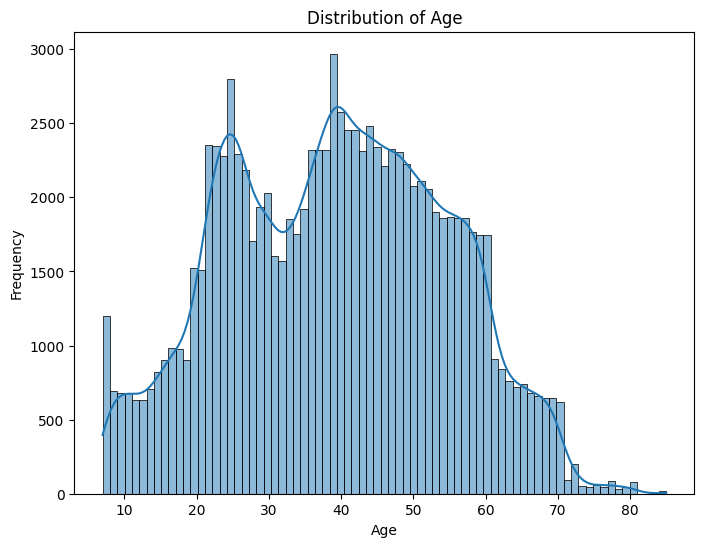

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


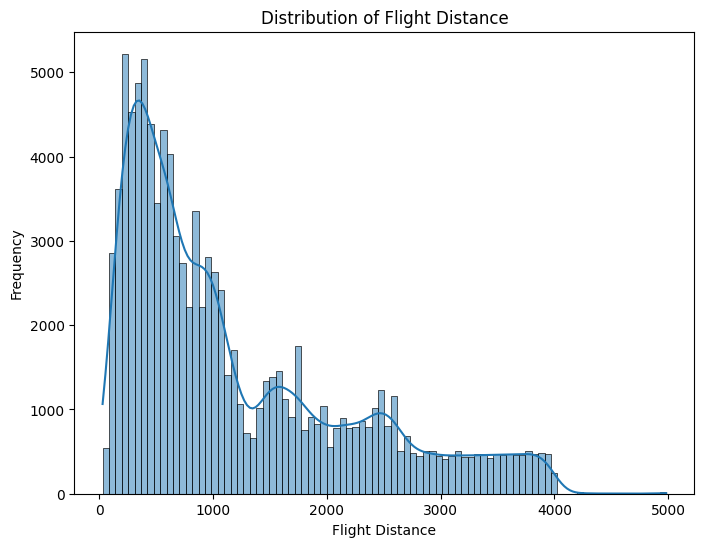

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


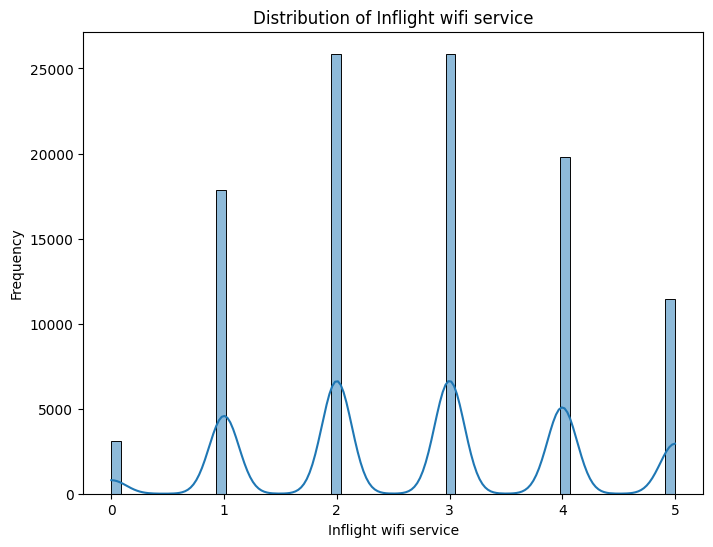

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


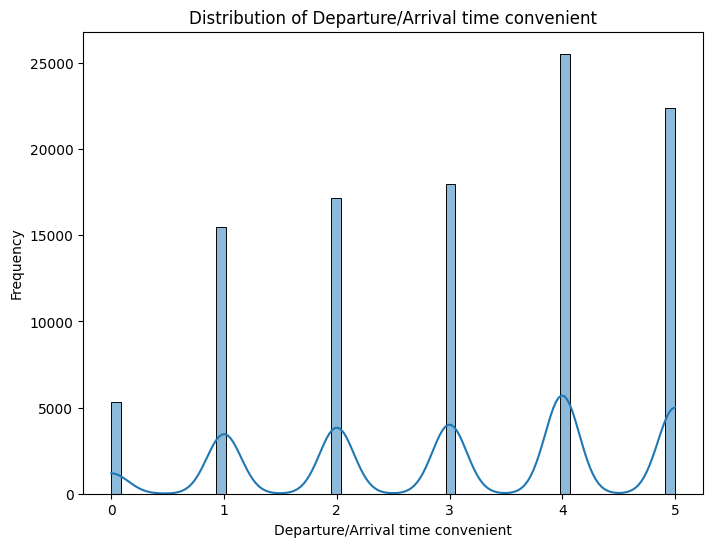

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


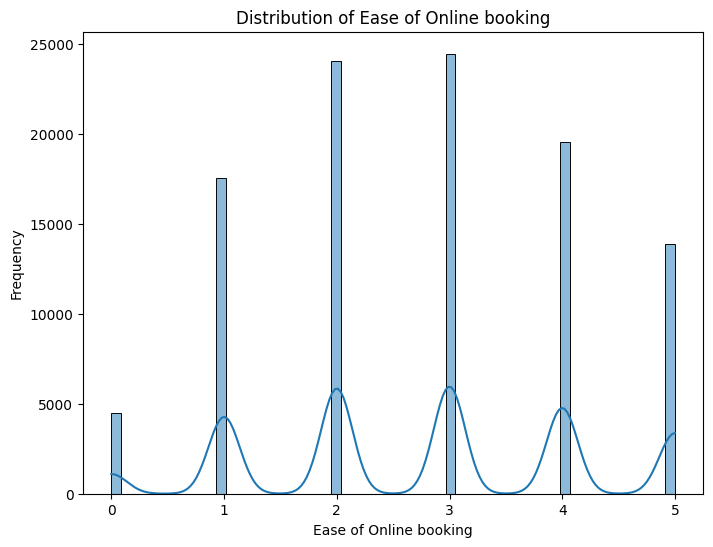

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


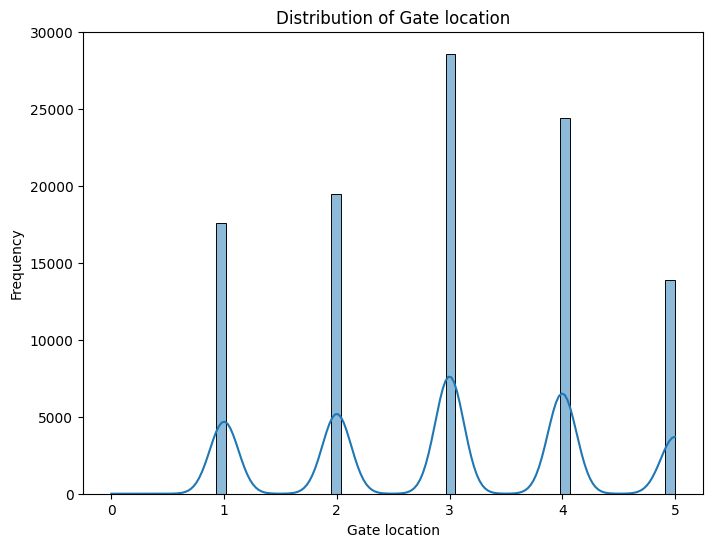

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


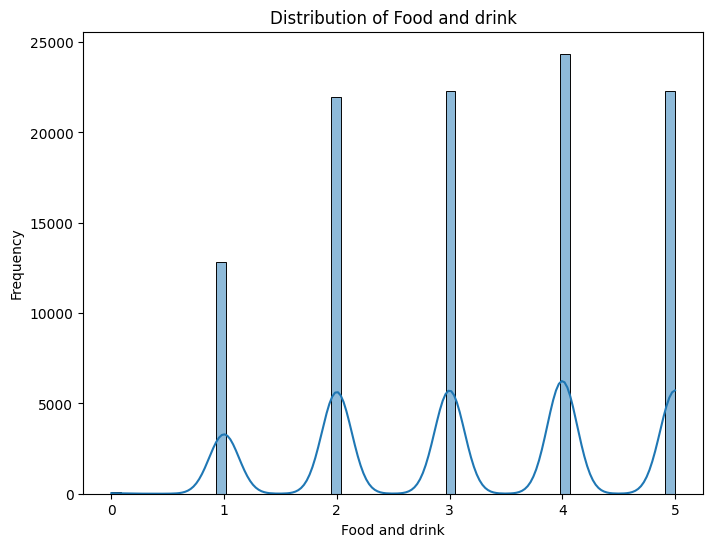

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


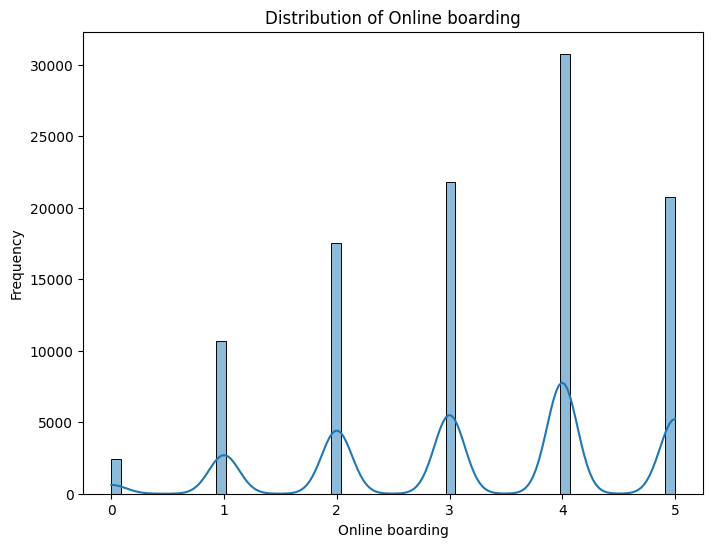

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


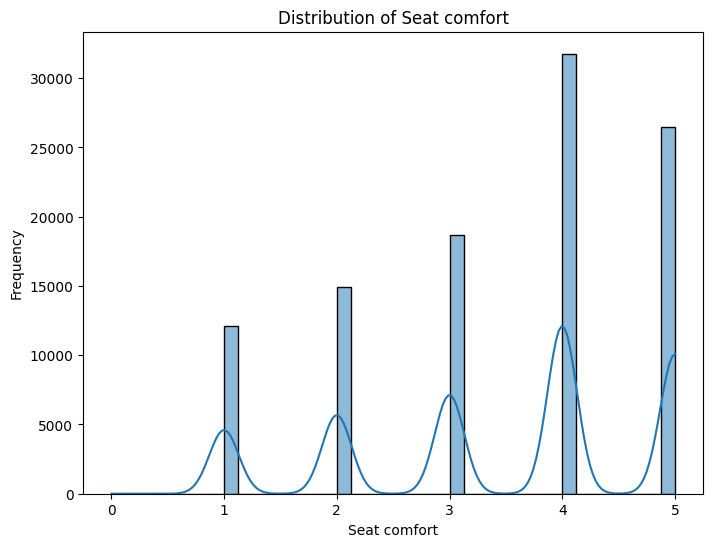

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


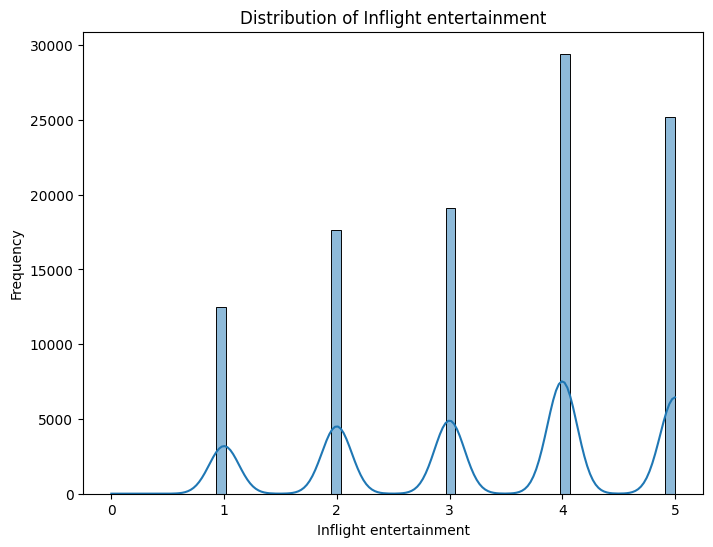

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


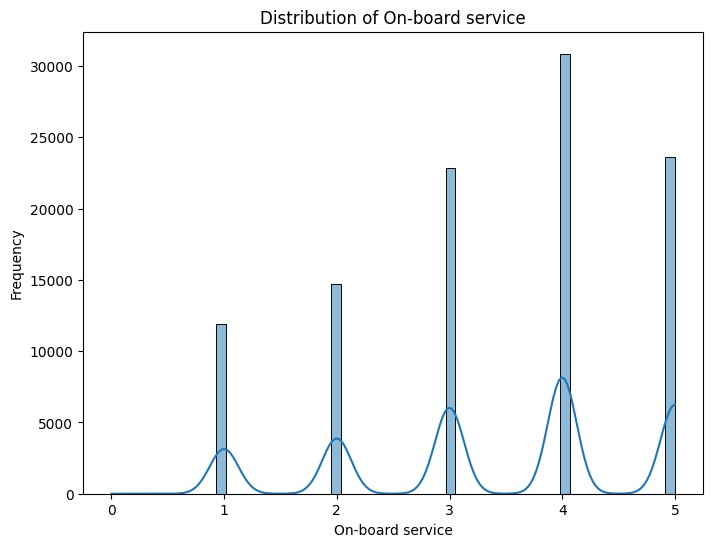

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


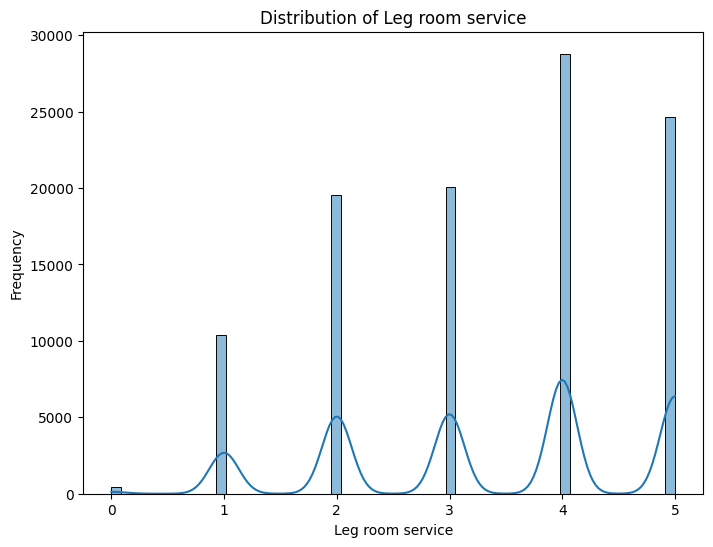

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


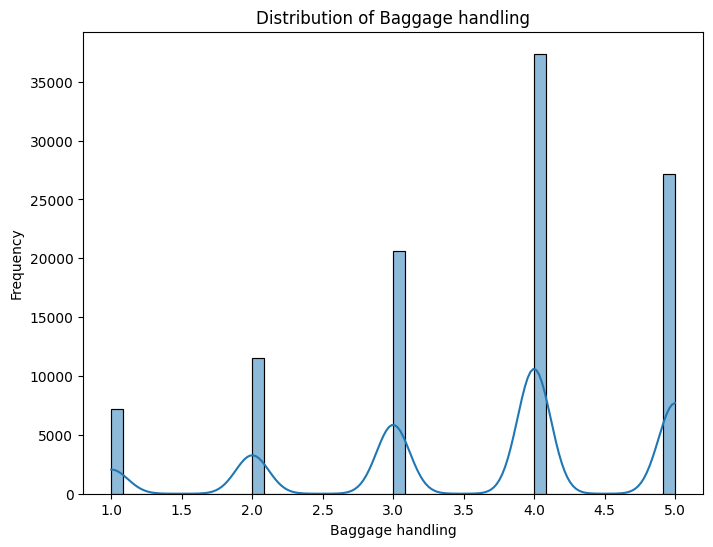

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


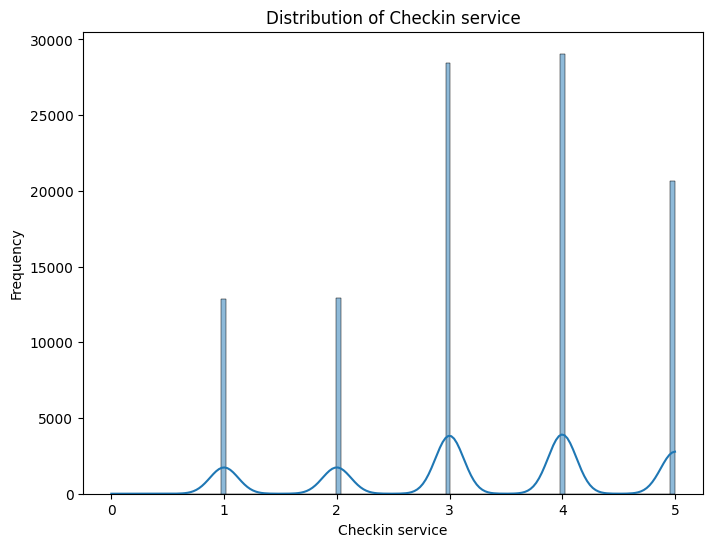

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


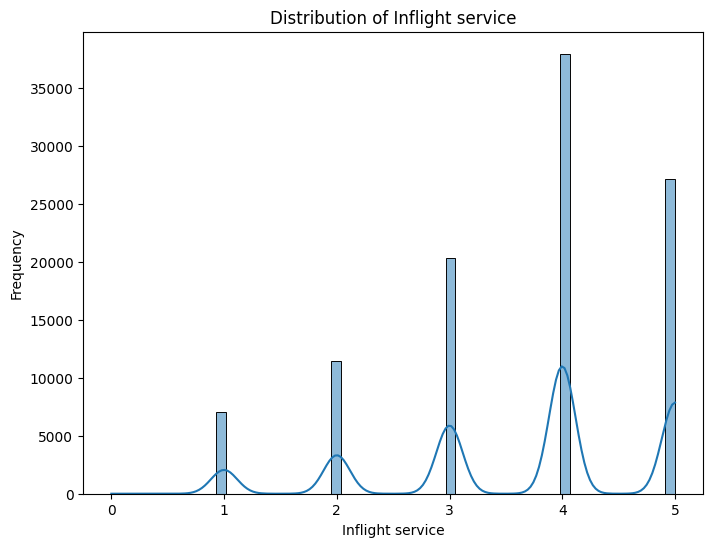

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


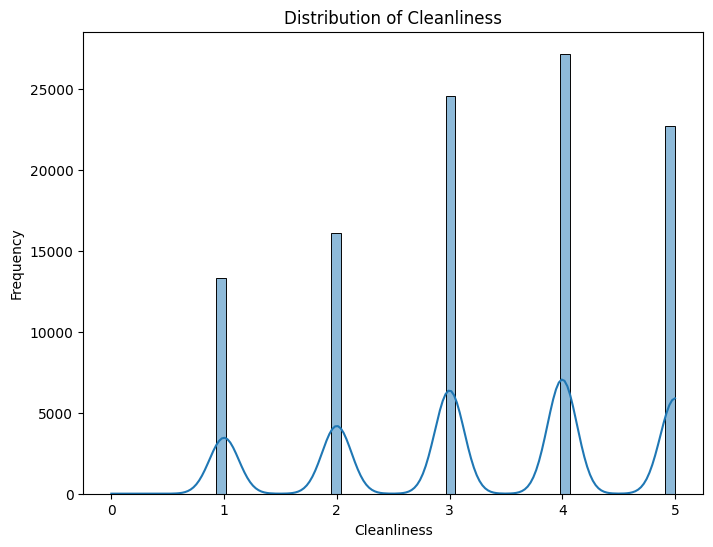

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


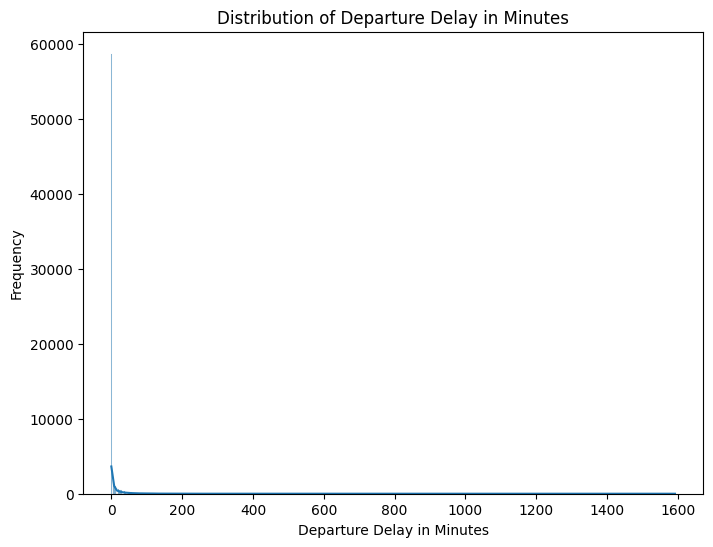

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


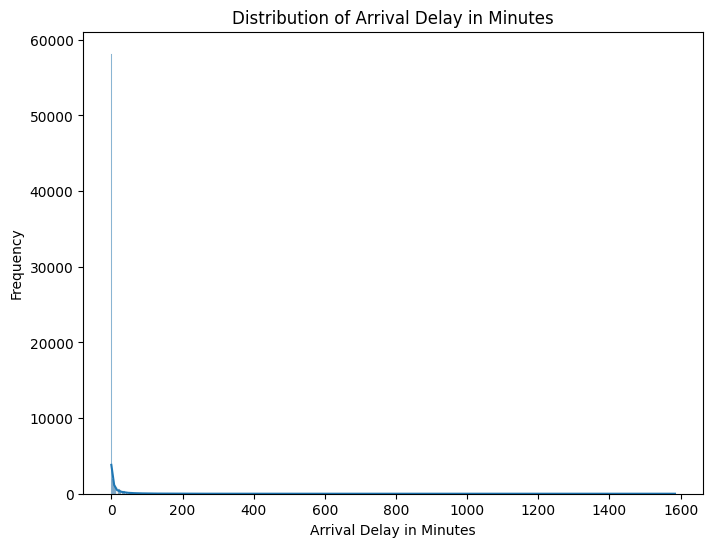

In [20]:
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(pd_train[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## Visualize Categorical Feature Distributions


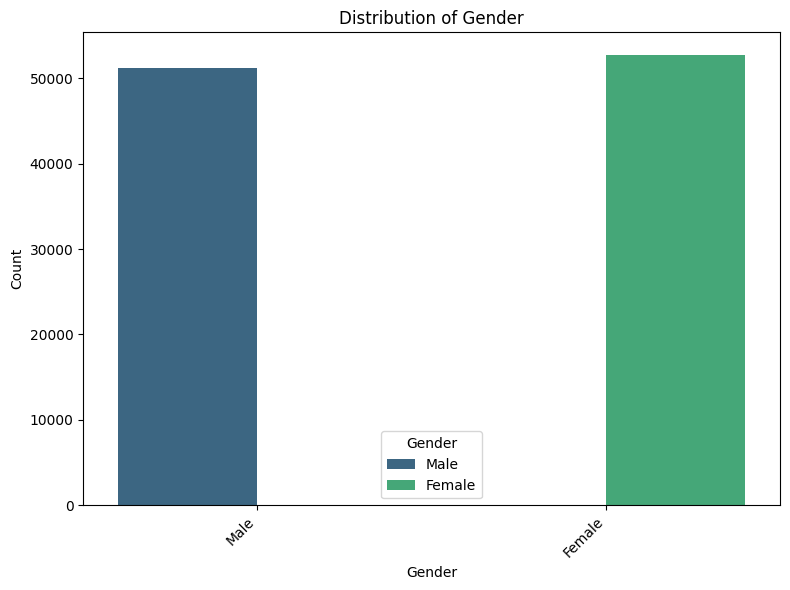

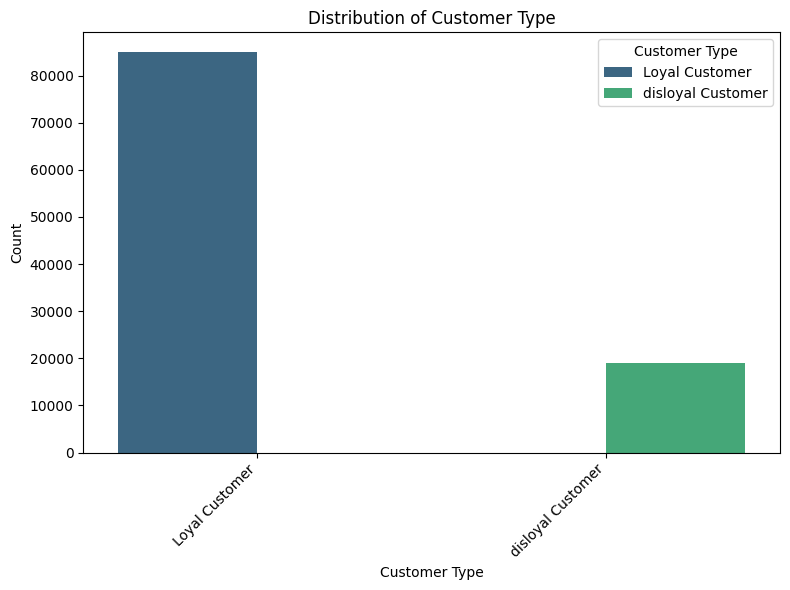

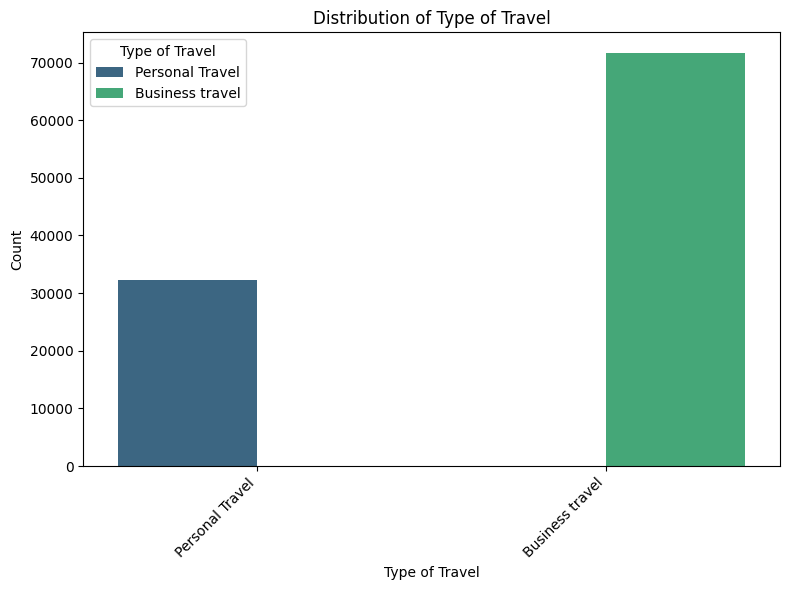

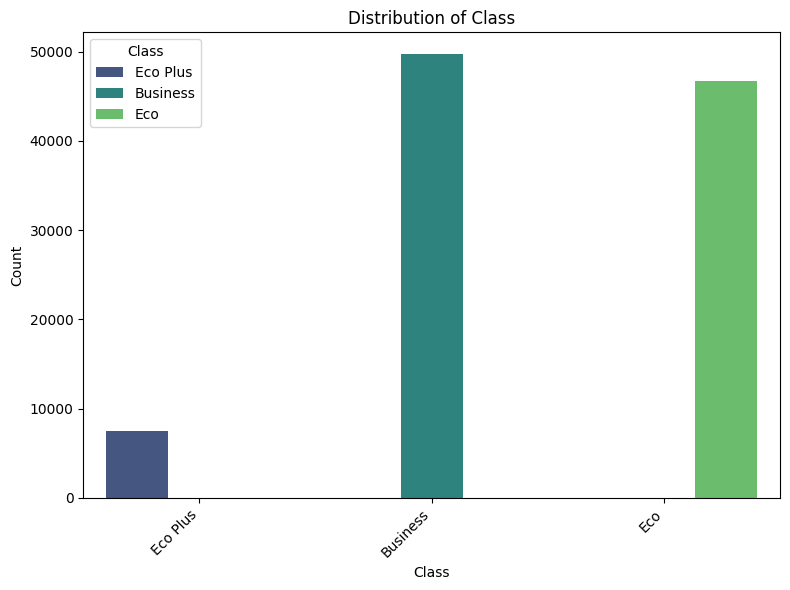

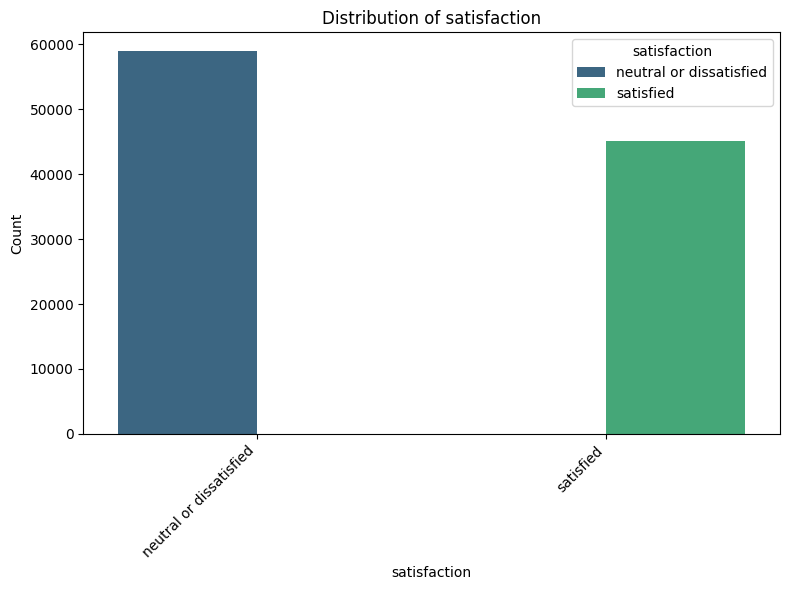

In [21]:
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=pd_train, x=col, hue=col, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

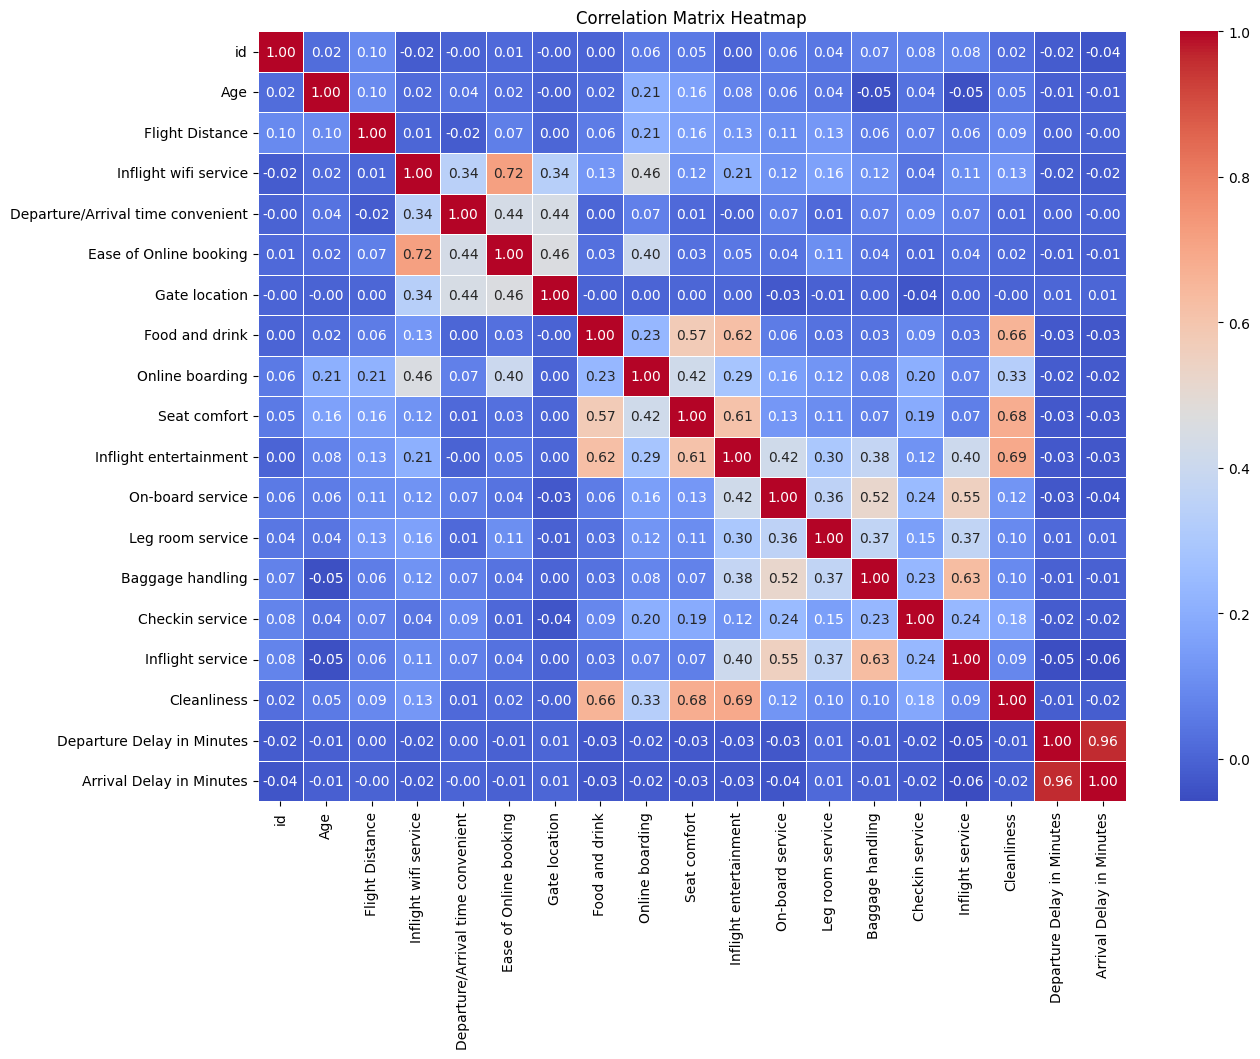

In [22]:
# ===========================================
# CORRELATION MATRIX (HEATMAP)
# ===========================================

plt.figure(figsize=(14, 10))

# Hitung korelasi hanya untuk kolom numerik
corr_matrix = df_train_cleaned.corr(numeric_only=True)

sns.heatmap(
    corr_matrix,
    annot=True,           # tampilkan nilai korelasi
    fmt=".2f",            # format angka
    cmap="coolwarm",      # warna
    linewidths=0.5,       # jarak antar sel
)

plt.title("Correlation Matrix Heatmap")
plt.show()


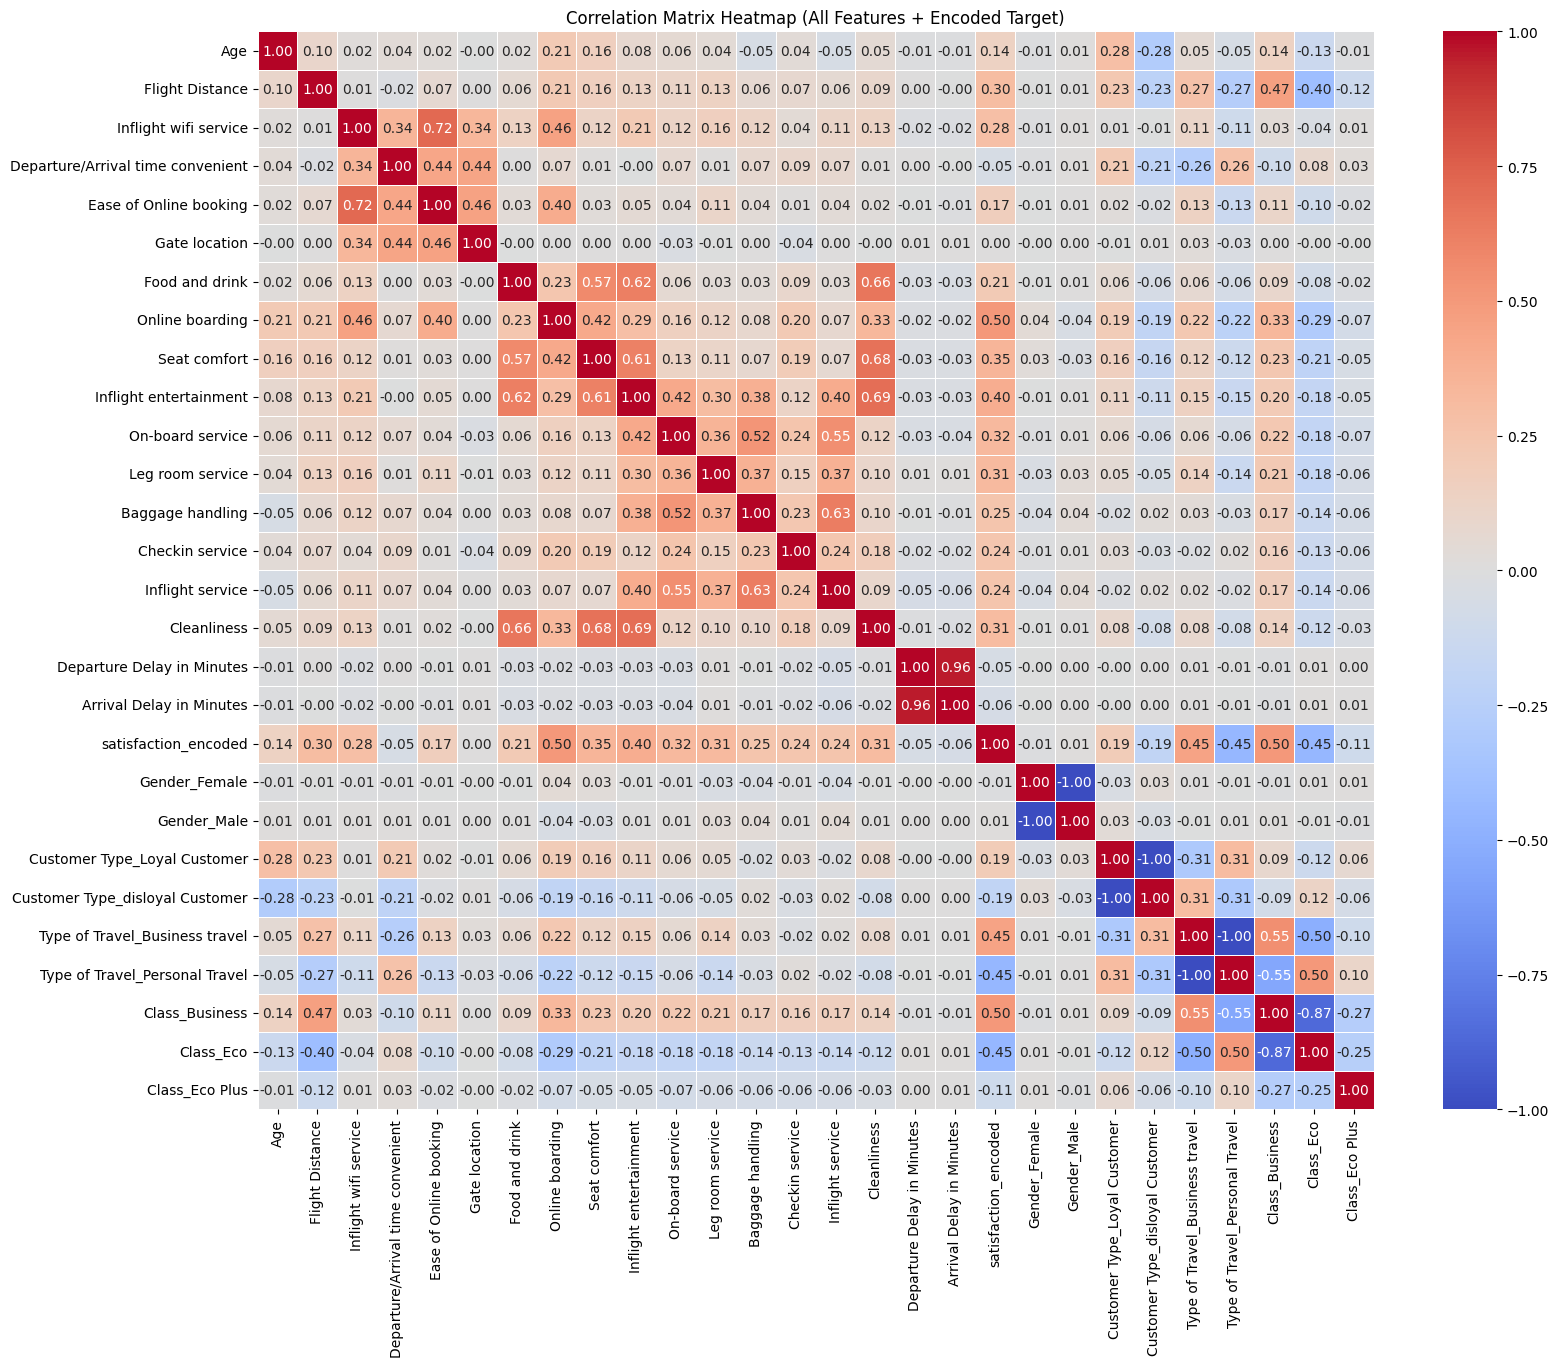

In [23]:
df_train_corr = df_train_cleaned.copy()

# Encode the target variable numerically
le_corr = LabelEncoder()
df_train_corr['satisfaction_encoded'] = le_corr.fit_transform(df_train_corr['satisfaction'])

# Drop the original 'satisfaction' column and 'id' column for correlation calculation
df_train_corr = df_train_corr.drop(columns=['id', 'satisfaction'])

# Identify remaining categorical columns
categorical_features = df_train_corr.select_dtypes(include=['object']).columns

# Apply OneHotEncoder to categorical features
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_features = ohe.fit_transform(df_train_corr[categorical_features])
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Create a DataFrame for one-hot encoded features
df_ohe = pd.DataFrame(ohe_features, columns=ohe_feature_names, index=df_train_corr.index)

# Drop original categorical columns and concatenate with one-hot encoded features
df_train_corr = df_train_corr.drop(columns=categorical_features)
df_train_corr = pd.concat([df_train_corr, df_ohe], axis=1)

plt.figure(figsize=(18, 14))

# Calculate correlation for all numerical columns and the encoded target
corr_matrix_all = df_train_corr.corr()

sns.heatmap(
    corr_matrix_all,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
)

plt.title("Correlation Matrix Heatmap (All Features + Encoded Target)")
plt.show()

According to correlation matrix, we found that there are many features that correlate with target class satisfaction. It shows that the prediction result depends on these dense information features and is individually important (like online boarding, class_business, on-board service, etc). Not just depends on few feature

# Preprocessing

In [24]:
# SPLIT FITUR (X) DAN TARGET (y)

target_col = "satisfaction"  

# -------- TRAIN --------
X_train = df_train_cleaned.copy().drop(columns=[target_col])
y_train = df_train_cleaned.copy()[target_col]

# -------- TEST --------
X_test = df_test_cleaned.copy().drop(columns=[target_col])
y_test = df_test_cleaned.copy()[target_col]
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (103904, 23)
y_train shape: (103904,)
X_test shape: (25976, 23)
y_test shape: (25976,)


In [25]:
# Tentukan kolom kategorikal dari X_train
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# FIT hanya pada TRAIN → transform TRAIN
ohe_train = ohe.fit_transform(X_train[categorical_cols])

# DataFrame hasil OHE train
ohe_train_df = pd.DataFrame(
    ohe_train,
    columns=ohe.get_feature_names_out(categorical_cols),
    index=X_train.index
)

# Gabungkan fitur numerik + OHE
X_train_encoded = pd.concat(
    [X_train.drop(columns=categorical_cols), ohe_train_df],
    axis=1
)

X_train_encoded.head()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,70172,13,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,5047,25,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,110028,26,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,24026,25,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,119299,61,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [26]:
# TRANSFORM: hanya pada TEST (tanpa fit)
ohe_test = ohe.transform(X_test[categorical_cols])

ohe_test_df = pd.DataFrame(
    ohe_test,
    columns=ohe.get_feature_names_out(categorical_cols),
    index=X_test.index
)

X_test_encoded = pd.concat(
    [X_test.drop(columns=categorical_cols), ohe_test_df],
    axis=1
)

X_train_encoded.head()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,70172,13,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,5047,25,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,110028,26,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,24026,25,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,119299,61,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [27]:
numeric_cols = X_train_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [28]:
# Inisialisasi scaler
scaler = StandardScaler()

# =====================================================
# 2. FIT + TRANSFORM pada TRAIN
# =====================================================
scaled_train = scaler.fit_transform(X_train_encoded[numeric_cols])

X_train_scaled = X_train_encoded.copy()
X_train_scaled[numeric_cols] = scaled_train
X_train_scaled.head()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,0.140077,-1.745279,-0.731539,0.203579,0.616172,0.173776,-1.547323,1.352264,-0.185532,1.183099,1.231704,0.479403,-0.26684,0.311769,0.549799,1.156436,1.305870,0.266393,0.074169,-1.015031,1.015031,0.472767,-0.472767,-1.490614,1.490614,-0.956906,-0.904327,3.586776
1,-1.598276,-0.951360,-0.957184,0.203579,-0.695245,0.173776,0.018094,-1.656326,-0.185532,-1.849315,-1.769081,-1.849161,1.25338,-0.535045,-1.821012,0.305848,-1.742292,-0.361375,-0.236313,-1.015031,1.015031,-2.115208,2.115208,0.670865,-0.670865,1.045034,-0.904327,-0.278802
2,1.203935,-0.885200,-0.047584,-0.549533,-0.695245,-0.541060,-0.764614,1.352264,1.296496,1.183099,1.231704,0.479403,-0.26684,0.311769,0.549799,0.305848,1.305870,-0.387532,-0.391554,0.985192,-0.985192,0.472767,-0.472767,0.670865,-0.670865,1.045034,-0.904327,-0.278802
3,-1.091678,-0.951360,-0.629246,-0.549533,1.271880,1.603448,1.583511,-0.904178,-0.926545,-1.091211,-1.018885,-1.072973,1.25338,-0.535045,-1.821012,0.305848,-0.980251,-0.099805,-0.158692,0.985192,-0.985192,0.472767,-0.472767,0.670865,-0.670865,1.045034,-0.904327,-0.278802
4,1.451402,1.430397,-0.978244,0.203579,-0.039537,0.173776,0.018094,0.600117,1.296496,1.183099,-0.268688,-0.296785,0.49327,0.311769,-0.240472,-0.544740,-0.218211,-0.387532,-0.391554,-1.015031,1.015031,0.472767,-0.472767,0.670865,-0.670865,1.045034,-0.904327,-0.278802


In [29]:
scaled_test = scaler.transform(X_test_encoded[numeric_cols])

X_test_scaled = X_test_encoded.copy()
X_test_scaled[numeric_cols] = scaled_test
X_test_scaled.head()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,-1.210993,0.834958,-1.032398,1.709804,0.616172,0.173776,0.800803,-0.152031,0.555482,-0.333108,1.231704,1.255590,1.253380,1.158582,-1.030742,1.156436,1.305870,0.920317,0.746880,0.985192,-0.985192,0.472767,-0.472767,0.670865,-0.670865,-0.956906,1.105795,-0.278802
1,0.670271,-0.223601,1.678348,-1.302646,-1.350954,0.173776,-1.547323,1.352264,0.555482,1.183099,0.481508,0.479403,0.493270,0.311769,-0.240472,0.305848,1.305870,-0.387532,-0.391554,0.985192,-0.985192,0.472767,-0.472767,0.670865,-0.670865,1.045034,-0.904327,-0.278802
2,-1.403073,-1.282160,-1.000307,-0.549533,-2.006662,-0.541060,0.800803,-0.904178,-0.926545,-1.091211,-1.018885,0.479403,-1.787061,-0.535045,-1.030742,-1.395328,-0.980251,-0.387532,-0.391554,-1.015031,1.015031,-2.115208,2.115208,0.670865,-0.670865,-0.956906,1.105795,-0.278802
3,0.347932,0.305678,2.193821,-2.055758,-2.006662,-1.970731,-0.764614,-0.152031,0.555482,0.424996,-1.769081,-1.849161,-1.787061,-2.228672,-0.240472,-2.245916,0.543829,-0.387532,-0.236313,-1.015031,1.015031,0.472767,-0.472767,0.670865,-0.670865,1.045034,-0.904327,-0.278802
4,-0.748705,0.636478,-0.007470,-0.549533,-0.039537,0.888612,0.018094,0.600117,-1.667559,-1.091211,-1.018885,-1.072973,-1.026951,-1.381858,0.549799,-1.395328,0.543829,-0.387532,0.125916,0.985192,-0.985192,0.472767,-0.472767,0.670865,-0.670865,-0.956906,1.105795,-0.278802


## Data Resampling (For Scenario 2)

In [30]:
# ============================================
# CEK IMBANG / TIDAK SEBELUM SMOTE
# ============================================
print("Sebelum SMOTE:")
print(y_train.value_counts(normalize=True))

# ============================================
# INISIALISASI SMOTE
# ============================================
smote = SMOTE(random_state=42)

# FIT + RESAMPLE HANYA PADA TRAIN
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nSetelah SMOTE:")
print(y_train_resampled.value_counts(normalize=True))

print("\nX_train_resampled shape:", X_train_resampled.shape)
print("y_train_resampled shape:", y_train_resampled.shape)


# ============================================
# INISIALISASI RandomUnderSampler
# ============================================
rus = RandomUnderSampler(random_state=42)

# FIT + RESAMPLE HANYA PADA TRAIN
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_scaled, y_train)

print("\nSetelah Random Undersampling:")
print(y_train_undersampled.value_counts(normalize=True))

print("\nX_train_undersampled shape:", X_train_undersampled.shape)
print("y_train_undersampled shape:", y_train_undersampled.shape)



Sebelum SMOTE:
satisfaction
neutral or dissatisfied    0.566667
satisfied                  0.433333
Name: proportion, dtype: float64

Setelah SMOTE:
satisfaction
neutral or dissatisfied    0.5
satisfied                  0.5
Name: proportion, dtype: float64

X_train_resampled shape: (117758, 28)
y_train_resampled shape: (117758,)

Setelah Random Undersampling:
satisfaction
neutral or dissatisfied    0.5
satisfied                  0.5
Name: proportion, dtype: float64

X_train_undersampled shape: (90050, 28)
y_train_undersampled shape: (90050,)


In [31]:
# ============================================================
# FINAL VARIABLES FOR MODELING
# ============================================================

# ===============================
# NON-SMOTE VERSION (ORIGINAL)
# ===============================
X_train_final_non_smote = X_train_scaled.copy()
y_train_final_non_smote = y_train.copy()

X_test_final_non_smote = X_test_scaled.copy()
y_test_final_non_smote = y_test.copy()


# ===============================
# SMOTE VERSION (RESAMPLED)
# ===============================
X_train_final_smote = X_train_resampled.copy()
y_train_final_smote = y_train_resampled.copy()

# TEST SET TIDAK PERNAH DI-SMOTE
X_test_final_smote = X_test_scaled.copy()
y_test_final_smote = y_test.copy()


# ============================================================
# FINAL VARIABLES FOR MODELING (UNDERSAMPLED)
# ============================================================
X_train_final_undersampled = X_train_undersampled.copy()
y_train_final_undersampled = y_train_undersampled.copy()

X_test_final_undersampled = X_test_scaled.copy()
y_test_final_undersampled = y_test.copy()


# ===============================
# CEK SHAPE UNTUK KONFIRMASI
# ===============================
print("=== Original ===")
print("X_train_final_non_smote:", X_train_final_non_smote.shape)
print("y_train_final_non_smote:", y_train_final_non_smote.shape)
print("X_test_final_non_smote :", X_test_final_non_smote.shape)
print("y_test_final_non_smote :", y_test_final_non_smote.shape)

print("\n=== SMOTE ===")
print("X_train_final_smote:", X_train_final_smote.shape)
print("y_train_final_smote:", y_train_final_smote.shape)
print("X_test_final_smote :", X_test_final_smote.shape)
print("y_test_final_smote :", y_test_final_smote.shape)

print("\n=== Random Undersampling ===")
print("X_train_final_undersampled:", X_train_final_undersampled.shape)
print("y_train_final_undersampled:", y_train_final_undersampled.shape)
print("X_test_final_undersampled :", X_test_final_undersampled.shape)
print("y_test_final_undersampled :", y_test_final_undersampled.shape)


=== Original ===
X_train_final_non_smote: (103904, 28)
y_train_final_non_smote: (103904,)
X_test_final_non_smote : (25976, 28)
y_test_final_non_smote : (25976,)

=== SMOTE ===
X_train_final_smote: (117758, 28)
y_train_final_smote: (117758,)
X_test_final_smote : (25976, 28)
y_test_final_smote : (25976,)

=== Random Undersampling ===
X_train_final_undersampled: (90050, 28)
y_train_final_undersampled: (90050,)
X_test_final_undersampled : (25976, 28)
y_test_final_undersampled : (25976,)


# Test Scenario

## Ablation Study (With and Without DAE-GA) Test

### Without DAE-GA

##### HistGBDT

In [32]:
# ============================================
# HISTGRADIENTBOOSTING (HistGBDT) + GRIDSEARCH
# ============================================

hist_base = HistGradientBoostingClassifier(random_state=42)

param_grid_hist = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [None, 3, 5, 7],
    "max_iter": [100, 200, 300],
}

hist_search = GridSearchCV(
    estimator=hist_base,
    param_grid=param_grid_hist,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

hist_search.fit(X_train_final_non_smote, y_train_final_non_smote)

best_hist = hist_search.best_estimator_
print("Best params HistGBDT:", hist_search.best_params_)

y_pred_hist = best_hist.predict(X_test_final_non_smote)

print("\n=== HistGBDT (Non-SMOTE) ===")
print("Accuracy:", accuracy_score(y_test_final_non_smote, y_pred_hist))
print(classification_report(y_test_final_non_smote, y_pred_hist))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params HistGBDT: {'learning_rate': 0.05, 'max_depth': None, 'max_iter': 300}

=== HistGBDT (Non-SMOTE) ===
Accuracy: 0.9663535571296581
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.98      0.95      0.96     11403

               accuracy                           0.97     25976
              macro avg       0.97      0.96      0.97     25976
           weighted avg       0.97      0.97      0.97     25976



##### XGBoost

In [33]:
# ============================================
# XGBOOST + GRIDSEARCH
# ============================================

# ============================================
# ENCODE LABEL UNTUK XGBOOST (0 / 1)
# ============================================
label_map = {
    "neutral or dissatisfied": 0,
    "satisfied": 1
}

y_train_xgb_non_smote = y_train_final_non_smote.map(label_map)
y_test_xgb_non_smote  = y_test_final_non_smote.map(label_map)

print("Unique train labels (XGB):", y_train_xgb_non_smote.unique())
print("Unique test labels  (XGB):", y_test_xgb_non_smote.unique())

xgb_base = XGBClassifier(
    objective="binary:logistic",   # kalau multi-class → "multi:softprob" + num_class=...
    eval_metric="logloss",
    use_label_encoder=False if "use_label_encoder" in XGBClassifier().get_params() else None,
    random_state=42,
)

param_grid_xgb = {
    "n_estimators": [200, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
}

xgb_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

xgb_search.fit(X_train_final_non_smote, y_train_xgb_non_smote)

best_xgb = xgb_search.best_estimator_
print("Best params XGBoost:", xgb_search.best_params_)

y_pred_xgb = best_xgb.predict(X_test_final_non_smote)

print("\n=== XGBoost (Non-SMOTE) ===")
print("Accuracy:", accuracy_score(y_test_xgb_non_smote, y_pred_xgb))
print(classification_report(y_test_xgb_non_smote, y_pred_xgb))

Unique train labels (XGB): [0 1]
Unique test labels  (XGB): [1 0]
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}

=== XGBoost (Non-SMOTE) ===
Accuracy: 0.9661225746843239
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14573
           1       0.97      0.95      0.96     11403

    accuracy                           0.97     25976
   macro avg       0.97      0.96      0.97     25976
weighted avg       0.97      0.97      0.97     25976



##### CatBoost

In [34]:
# ============================================
# CATBOOST + GRIDSEARCH
# ============================================

cat_base = CatBoostClassifier(
    loss_function="Logloss",   # kalau multi-class → "MultiClass"
    verbose=0,
    random_seed=42,
)

param_grid_cat = {
    "iterations": [200, 300, 500],
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
}

cat_search = GridSearchCV(
    estimator=cat_base,
    param_grid=param_grid_cat,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

cat_search.fit(X_train_final_non_smote, y_train_final_non_smote)

best_cat = cat_search.best_estimator_
print("Best params CatBoost:", cat_search.best_params_)

y_pred_cat = best_cat.predict(X_test_final_non_smote)

print("\n=== CatBoost (Non-SMOTE) ===")
print("Accuracy:", accuracy_score(y_test_final_non_smote, y_pred_cat))
print(classification_report(y_test_final_non_smote, y_pred_cat))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params CatBoost: {'depth': 8, 'iterations': 300, 'learning_rate': 0.1}

=== CatBoost (Non-SMOTE) ===
Accuracy: 0.9667770249461041
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.97      0.95      0.96     11403

               accuracy                           0.97     25976
              macro avg       0.97      0.96      0.97     25976
           weighted avg       0.97      0.97      0.97     25976



##### Random Forest

In [35]:
# ============================================
# RANDOM FOREST + GRIDSEARCH
# ============================================

rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
)

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "max_features": ["sqrt", "log2"],
}

rf_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

rf_search.fit(X_train_final_non_smote, y_train_final_non_smote)

best_rf = rf_search.best_estimator_
print("Best params RandomForest:", rf_search.best_params_)

y_pred_rf = best_rf.predict(X_test_final_non_smote)

print("\n=== RandomForest (Non-SMOTE) ===")
print("Accuracy:", accuracy_score(y_test_final_non_smote, y_pred_rf))
print(classification_report(y_test_final_non_smote, y_pred_rf))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END learning_rate=0.01, max_depth=None, max_iter=100;, score=0.939 total time=   3.6s
[CV 2/3] END learning_rate=0.01, max_depth=None, max_iter=200;, score=0.949 total time=   6.9s
[CV 3/3] END learning_rate=0.01, max_depth=None, max_iter=300;, score=0.956 total time=  10.0s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_iter=300;, score=0.924 total time=   5.9s
[CV 2/3] END learning_rate=0.01, max_depth=5, max_iter=200;, score=0.938 total time=   5.9s
[CV 3/3] END learning_rate=0.01, max_depth=5, max_iter=300;, score=0.944 total time=   8.6s
[CV 1/3] END learning_rate=0.01, max_depth=7, max_iter=300;, score=0.951 total time=   9.9s
[CV 3/3] END learning_rate=0.05, max_depth=None, max_iter=100;, score=0.961 total time=   3.6s
[CV 2/3] END learning_rate=0.05, max_depth=None, max_iter=200;, score=0.964 total time=   6.6s
[CV 3/3] END learning_rate=0.05, max_depth=None, max_iter=300;, score=0.965 total time=   8.4s
[

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/3] END learning_rate=0.01, max_depth=None, max_iter=200;, score=0.948 total time=   6.9s
[CV 2/3] END learning_rate=0.01, max_depth=None, max_iter=300;, score=0.954 total time=  10.1s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_iter=200;, score=0.912 total time=   4.2s
[CV 1/3] END learning_rate=0.01, max_depth=5, max_iter=100;, score=0.919 total time=   3.0s
[CV 2/3] END learning_rate=0.01, max_depth=5, max_iter=100;, score=0.921 total time=   3.0s
[CV 3/3] END learning_rate=0.01, max_depth=5, max_iter=200;, score=0.937 total time=   5.8s
[CV 1/3] END learning_rate=0.01, max_depth=7, max_iter=100;, score=0.939 total time=   3.4s
[CV 2/3] END learning_rate=0.01, max_depth=7, max_iter=100;, score=0.939 total time=   3.4s
[CV 1/3] END learning_rate=0.01, max_depth=7, max_iter=200;, score=0.945 total time=   6.6s
[CV 2/3] END learning_rate=0.01, max_depth=7, max_iter=300;, score=0.951 total time=   9.7s
[CV 3/3] END learning_rate=0.05, max_depth=None, max_iter=200;, score=0.96

##### Decision Tree

In [36]:
# ============================================
# DECISION TREE + GRIDSEARCH
# ============================================

dt_base = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    "max_depth": [None, 5, 10, 20],
    "criterion": ["gini", "entropy"],
}

dt_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid_dt,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

dt_search.fit(X_train_final_non_smote, y_train_final_non_smote)

best_dt = dt_search.best_estimator_
print("Best params DecisionTree:", dt_search.best_params_)

y_pred_dt = best_dt.predict(X_test_final_non_smote)

print("\n=== DecisionTree (Non-SMOTE) ===")
print("Accuracy:", accuracy_score(y_test_final_non_smote, y_pred_dt))
print(classification_report(y_test_final_non_smote, y_pred_dt))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params DecisionTree: {'criterion': 'entropy', 'max_depth': 20}

=== DecisionTree (Non-SMOTE) ===
Accuracy: 0.9508392362180474
                         precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.96      0.96     14573
              satisfied       0.95      0.94      0.94     11403

               accuracy                           0.95     25976
              macro avg       0.95      0.95      0.95     25976
           weighted avg       0.95      0.95      0.95     25976



##### FT-Transformer

In [37]:
# ============================================
# 1. Encode target → integer (wajib utk CE Loss)
# ============================================
le_ft = LabelEncoder()
y_train_ft = le_ft.fit_transform(y_train_final_non_smote)
y_test_ft  = le_ft.transform(y_test_final_non_smote)

n_classes = len(le_ft.classes_)
print("Classes:", le_ft.classes_)
print("n_classes:", n_classes)

# ============================================
# 2. Gabungkan X + y ke DataFrame khusus TorchFrame
#    (TIDAK mengubah variabel asli)
# ============================================
df_train_ft = X_train_final_non_smote.copy()
df_train_ft["satisfaction"] = y_train_ft

df_test_ft = X_test_final_non_smote.copy()
df_test_ft["satisfaction"] = y_test_ft

# Semua fitur di pipeline ini sudah numerik (OHE + scaler)
feature_cols = X_train_final_non_smote.columns.tolist()

col_to_stype = {c: torch_frame.numerical for c in feature_cols}
col_to_stype["satisfaction"] = torch_frame.categorical  # <-- tambahin ini

print("Total fitur numerik:", len(feature_cols))


Classes: ['neutral or dissatisfied' 'satisfied']
n_classes: 2
Total fitur numerik: 28


In [38]:
# ============================================
# 3. Dataset TorchFrame
# ============================================
train_dataset = Dataset(
    df=df_train_ft,
    col_to_stype=col_to_stype,
    target_col="satisfaction",
).materialize()

test_dataset = Dataset(
    df=df_test_ft,
    col_to_stype=col_to_stype,
    target_col="satisfaction",
).materialize(col_stats=train_dataset.col_stats)

print("Train rows:", train_dataset.num_rows)
print("Test rows :", test_dataset.num_rows)

# ============================================
# 4. DataLoader
# ============================================
batch_size = 512

train_loader = DataLoader(
    train_dataset.tensor_frame,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    test_dataset.tensor_frame,
    batch_size=batch_size,
    shuffle=False,
)


Train rows: 103904
Test rows : 25976


In [39]:
# ============================================
# 5. Model FTTransformer
# ============================================
numerical_encoder = LinearEncoder()

stype_encoder_dict = {
    torch_frame.numerical: numerical_encoder,
}

model_ft = FTTransformer(
    channels=256,
    out_channels=n_classes,
    num_layers=4,
    col_stats=train_dataset.col_stats,
    col_names_dict=train_dataset.tensor_frame.col_names_dict,
    stype_encoder_dict=stype_encoder_dict,
).to(device)

try:
    model_ft = torch.compile(model_ft, dynamic=True, backend="eager")
    print("Model compiled with torch.compile")
except Exception as e:
    print("torch.compile skipped:", e)

optimizer = torch.optim.AdamW(model_ft.parameters(), lr=1e-4)


Model compiled with torch.compile


In [40]:
# ============================================
# 6. Training & Eval Loop + Early Stopping
# ============================================
def train_one_epoch(epoch: int) -> float:
    model_ft.train()
    loss_accum = 0.0
    total_count = 0

    for tf in tqdm(train_loader, desc=f"Epoch {epoch}"):
        tf = tf.to(device)
        pred = model_ft(tf)            # [batch, n_classes]
        loss = F.cross_entropy(pred, tf.y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)

    return loss_accum / total_count


@torch.no_grad()
def eval_loader(loader: DataLoader) -> float:
    model_ft.eval()
    correct = 0
    total = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model_ft(tf)
        pred_class = pred.argmax(dim=-1)
        correct += int((pred_class == tf.y).sum())
        total += len(tf.y)

    return correct / total


# ============================================
# EARLY STOPPING SETUP
# ============================================
epochs = 50
patience = 5          # berapa epoch tanpa improvement sebelum stop
min_delta = 1e-4      # minimal kenaikan akurasi yang dianggap "improve"

best_val_acc = 0.0
best_state_dict = None
no_improve_epochs = 0

for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(epoch)
    train_acc = eval_loader(train_loader)     # optional: monitor train acc
    val_acc   = eval_loader(test_loader)     # di sini test_loader sedang kita treat sebagai "val_loader"

    # Cek improvement untuk early stopping
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        best_state_dict = copy.deepcopy(model_ft.state_dict())
        no_improve_epochs = 0
        status = " (improved ✅)"
    else:
        no_improve_epochs += 1
        status = f" (no improve: {no_improve_epochs}/{patience})"

    print(
        f"Epoch {epoch:03d} | "
        f"TrainLoss: {train_loss:.4f} | "
        f"TrainAcc: {train_acc:.4f} | "
        f"ValAcc: {val_acc:.4f}{status}"
    )

    # Cek early stopping
    if no_improve_epochs >= patience:
        print(f"\n⛔ Early stopping triggered at epoch {epoch}.")
        break

# ============================================
# LOAD BEST MODEL (kalau sempat improve)
# ============================================
if best_state_dict is not None:
    model_ft.load_state_dict(best_state_dict)
    print(f"\nLoaded best model with ValAcc = {best_val_acc:.4f}")
else:
    print("\nWarning: tidak ada improvement selama training, model terakhir dipakai apa adanya.")

print(f"\nBest Val Accuracy (FTTransformer, non-SMOTE): {best_val_acc:.4f}")


Epoch 1: 100%|██████████| 203/203 [00:13<00:00, 14.57it/s]


Epoch 001 | TrainLoss: 0.2559 | TrainAcc: 0.9188 | ValAcc: 0.9199 (improved ✅)


Epoch 2: 100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


Epoch 002 | TrainLoss: 0.1520 | TrainAcc: 0.9471 | ValAcc: 0.9470 (improved ✅)


Epoch 3: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 003 | TrainLoss: 0.1269 | TrainAcc: 0.9558 | ValAcc: 0.9551 (improved ✅)


Epoch 4: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 004 | TrainLoss: 0.1149 | TrainAcc: 0.9587 | ValAcc: 0.9578 (improved ✅)


Epoch 5: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 005 | TrainLoss: 0.1055 | TrainAcc: 0.9579 | ValAcc: 0.9578 (no improve: 1/5)


Epoch 6: 100%|██████████| 203/203 [00:12<00:00, 16.72it/s]


Epoch 006 | TrainLoss: 0.1020 | TrainAcc: 0.9606 | ValAcc: 0.9599 (improved ✅)


Epoch 7: 100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


Epoch 007 | TrainLoss: 0.0979 | TrainAcc: 0.9624 | ValAcc: 0.9614 (improved ✅)


Epoch 8: 100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


Epoch 008 | TrainLoss: 0.0956 | TrainAcc: 0.9629 | ValAcc: 0.9618 (improved ✅)


Epoch 9: 100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


Epoch 009 | TrainLoss: 0.0918 | TrainAcc: 0.9647 | ValAcc: 0.9635 (improved ✅)


Epoch 10: 100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


Epoch 010 | TrainLoss: 0.0881 | TrainAcc: 0.9648 | ValAcc: 0.9633 (no improve: 1/5)


Epoch 11: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 011 | TrainLoss: 0.0877 | TrainAcc: 0.9631 | ValAcc: 0.9622 (no improve: 2/5)


Epoch 12: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 012 | TrainLoss: 0.0859 | TrainAcc: 0.9645 | ValAcc: 0.9639 (improved ✅)


Epoch 13: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 013 | TrainLoss: 0.0851 | TrainAcc: 0.9638 | ValAcc: 0.9619 (no improve: 1/5)


Epoch 14: 100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


Epoch 014 | TrainLoss: 0.0846 | TrainAcc: 0.9646 | ValAcc: 0.9632 (no improve: 2/5)


Epoch 15: 100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


Epoch 015 | TrainLoss: 0.0829 | TrainAcc: 0.9639 | ValAcc: 0.9629 (no improve: 3/5)


Epoch 16: 100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


Epoch 016 | TrainLoss: 0.0823 | TrainAcc: 0.9665 | ValAcc: 0.9650 (improved ✅)


Epoch 17:  89%|████████▊ | 180/203 [00:10<00:01, 16.70it/s]

[CV 2/3] END max_depth=None, max_features=sqrt, n_estimators=200;, score=0.963 total time=  25.9s
[CV 3/3] END max_depth=None, max_features=sqrt, n_estimators=300;, score=0.965 total time=  43.8s
[CV 1/3] END max_depth=None, max_features=log2, n_estimators=300;, score=0.963 total time=  39.0s
[CV 2/3] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.922 total time=  12.5s
[CV 3/3] END max_depth=5, max_features=sqrt, n_estimators=300;, score=0.924 total time=  18.7s
[CV 2/3] END max_depth=5, max_features=log2, n_estimators=200;, score=0.916 total time=  11.7s
[CV 3/3] END max_depth=5, max_features=log2, n_estimators=300;, score=0.919 total time=  16.4s
[CV 2/3] END max_depth=10, max_features=sqrt, n_estimators=200;, score=0.948 total time=  21.1s
[CV 2/3] END max_depth=10, max_features=sqrt, n_estimators=300;, score=0.948 total time=  31.4s
[CV 1/3] END max_depth=10, max_features=log2, n_estimators=300;, score=0.945 total time=  28.1s
[CV 2/3] END max_depth=20, max_feature

Epoch 17:  94%|█████████▎| 190/203 [00:11<00:00, 16.61it/s]

[CV 3/3] END max_depth=None, max_features=sqrt, n_estimators=200;, score=0.965 total time=  26.4s
[CV 1/3] END max_depth=None, max_features=log2, n_estimators=100;, score=0.962 total time=  14.7s
[CV 2/3] END max_depth=None, max_features=log2, n_estimators=100;, score=0.962 total time=  13.0s
[CV 2/3] END max_depth=None, max_features=log2, n_estimators=200;, score=0.962 total time=  26.0s
[CV 3/3] END max_depth=None, max_features=log2, n_estimators=300;, score=0.964 total time=  38.1s
[CV 1/3] END max_depth=5, max_features=sqrt, n_estimators=300;, score=0.919 total time=  18.5s
[CV 3/3] END max_depth=5, max_features=log2, n_estimators=100;, score=0.921 total time=   5.1s
[CV 1/3] END max_depth=5, max_features=log2, n_estimators=300;, score=0.914 total time=  16.4s
[CV 2/3] END max_depth=10, max_features=sqrt, n_estimators=100;, score=0.948 total time=  10.2s
[CV 3/3] END max_depth=10, max_features=sqrt, n_estimators=200;, score=0.952 total time=  20.8s
[CV 1/3] END max_depth=10, max_fe

Epoch 17:  99%|█████████▊| 200/203 [00:11<00:00, 16.57it/s]

[CV 2/3] END max_depth=None, max_features=sqrt, n_estimators=300;, score=0.963 total time=  44.4s
[CV 1/3] END max_depth=None, max_features=log2, n_estimators=200;, score=0.963 total time=  26.4s
[CV 2/3] END max_depth=None, max_features=log2, n_estimators=300;, score=0.963 total time=  38.3s
[CV 3/3] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.926 total time=  12.3s
[CV 1/3] END max_depth=5, max_features=log2, n_estimators=100;, score=0.916 total time=   6.5s
[CV 2/3] END max_depth=5, max_features=log2, n_estimators=100;, score=0.916 total time=   5.2s
[CV 3/3] END max_depth=5, max_features=log2, n_estimators=200;, score=0.920 total time=  10.6s
[CV 1/3] END max_depth=10, max_features=sqrt, n_estimators=100;, score=0.949 total time=  11.2s
[CV 3/3] END max_depth=10, max_features=sqrt, n_estimators=100;, score=0.952 total time=  10.1s
[CV 1/3] END max_depth=10, max_features=sqrt, n_estimators=300;, score=0.948 total time=  31.8s
[CV 3/3] END max_depth=10, max_feature

Epoch 17: 100%|██████████| 203/203 [00:12<00:00, 16.71it/s]


[CV 1/3] END max_depth=None, max_features=sqrt, n_estimators=300;, score=0.964 total time=  43.7s
[CV 3/3] END max_depth=None, max_features=log2, n_estimators=100;, score=0.964 total time=  13.5s
[CV 3/3] END max_depth=None, max_features=log2, n_estimators=200;, score=0.964 total time=  26.0s
[CV 1/3] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.918 total time=   7.5s
[CV 2/3] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.920 total time=   7.1s
[CV 3/3] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.923 total time=   6.9s
[CV 1/3] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.920 total time=  12.5s
[CV 2/3] END max_depth=5, max_features=sqrt, n_estimators=300;, score=0.920 total time=  18.6s
[CV 1/3] END max_depth=5, max_features=log2, n_estimators=200;, score=0.916 total time=  11.7s
[CV 2/3] END max_depth=5, max_features=log2, n_estimators=300;, score=0.916 total time=  16.4s
[CV 1/3] END max_depth=10, max_features=s

Epoch 18: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 018 | TrainLoss: 0.0801 | TrainAcc: 0.9668 | ValAcc: 0.9657 (improved ✅)


Epoch 19: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 019 | TrainLoss: 0.0802 | TrainAcc: 0.9675 | ValAcc: 0.9657 (no improve: 1/5)


Epoch 20: 100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


Epoch 020 | TrainLoss: 0.0789 | TrainAcc: 0.9682 | ValAcc: 0.9661 (improved ✅)


Epoch 21: 100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


Epoch 021 | TrainLoss: 0.0788 | TrainAcc: 0.9679 | ValAcc: 0.9652 (no improve: 1/5)


Epoch 22: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 022 | TrainLoss: 0.0779 | TrainAcc: 0.9680 | ValAcc: 0.9659 (no improve: 2/5)


Epoch 23: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 023 | TrainLoss: 0.0768 | TrainAcc: 0.9692 | ValAcc: 0.9671 (improved ✅)


Epoch 24: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 024 | TrainLoss: 0.0762 | TrainAcc: 0.9675 | ValAcc: 0.9652 (no improve: 1/5)


Epoch 25: 100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


Epoch 025 | TrainLoss: 0.0761 | TrainAcc: 0.9684 | ValAcc: 0.9655 (no improve: 2/5)


Epoch 26: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 026 | TrainLoss: 0.0756 | TrainAcc: 0.9679 | ValAcc: 0.9660 (no improve: 3/5)


Epoch 27: 100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


Epoch 027 | TrainLoss: 0.0751 | TrainAcc: 0.9677 | ValAcc: 0.9659 (no improve: 4/5)


Epoch 28: 100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


Epoch 028 | TrainLoss: 0.0748 | TrainAcc: 0.9696 | ValAcc: 0.9663 (no improve: 5/5)

⛔ Early stopping triggered at epoch 28.

Loaded best model with ValAcc = 0.9671

Best Val Accuracy (FTTransformer, non-SMOTE): 0.9671


In [41]:
@torch.no_grad()
def eval_detailed(loader: DataLoader):
    model_ft.eval()
    all_pred = []
    all_true = []

    for tf in loader:
        tf = tf.to(device)
        pred = model_ft(tf)
        pred_class = pred.argmax(dim=-1).cpu().numpy()
        all_pred.extend(pred_class)
        all_true.extend(tf.y.cpu().numpy())

    return np.array(all_true), np.array(all_pred)

y_true_test, y_pred_test = eval_detailed(test_loader)

print("=== FTTransformer (PyTorch Frame, NON-SMOTE) ===")
print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print(
    classification_report(
        y_true_test,
        y_pred_test,
        target_names=le_ft.classes_,
    )
)


=== FTTransformer (PyTorch Frame, NON-SMOTE) ===
Accuracy: 0.9671234986141053
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.98      0.95      0.96     11403

               accuracy                           0.97     25976
              macro avg       0.97      0.96      0.97     25976
           weighted avg       0.97      0.97      0.97     25976



In [42]:
# HistGradientBoosting FULL
acc_hist_full = accuracy_score(
    y_test_final_non_smote,
    hist_search.best_estimator_.predict(X_test_final_non_smote)
)

# XGBoost FULL 
acc_xgb_full = accuracy_score(
    y_test_xgb_non_smote,
    xgb_search.best_estimator_.predict(X_test_final_non_smote)
)

# CatBoost FULL
acc_cat_full = accuracy_score(
    y_test_final_non_smote,
    cat_search.best_estimator_.predict(X_test_final_non_smote)
)

# RandomForest FULL
acc_rf_full = accuracy_score(
    y_test_final_non_smote,
    rf_search.best_estimator_.predict(X_test_final_non_smote)
)

# DecisionTree FULL
acc_dt_full = accuracy_score(
    y_test_final_non_smote,
    dt_search.best_estimator_.predict(X_test_final_non_smote)
)

# FT-Transformer FULL (Non-SMOTE)
# sudah ada dari training FT awal non-smote
acc_ft_full = best_val_acc  

In [43]:
performance_data = {
    'Model': [
        'HistGradientBoosting (Non-SMOTE)',
        'XGBoost (Non-SMOTE)',
        'CatBoost (Non-SMOTE)',
        'RandomForest (Non-SMOTE)',
        'DecisionTree (Non-SMOTE)',
        'FT-Transformer (Non-SMOTE)'
    ],
    'Accuracy': [
        accuracy_score(y_test_final_non_smote, hist_search.best_estimator_.predict(X_test_final_non_smote)),
        accuracy_score(y_test_xgb_non_smote, xgb_search.best_estimator_.predict(X_test_final_non_smote)),
        accuracy_score(y_test_final_non_smote, cat_search.best_estimator_.predict(X_test_final_non_smote)),
        accuracy_score(y_test_final_non_smote, rf_search.best_estimator_.predict(X_test_final_non_smote)),
        accuracy_score(y_test_final_non_smote, dt_search.best_estimator_.predict(X_test_final_non_smote)),
        best_val_acc # This is the best validation accuracy from FT-Transformer training
    ],
    'F1 Score': [
        f1_score(y_test_final_non_smote, hist_search.best_estimator_.predict(X_test_final_non_smote), average='weighted'),
        f1_score(y_test_xgb_non_smote, xgb_search.best_estimator_.predict(X_test_final_non_smote), average='weighted'),
        f1_score(y_test_final_non_smote, cat_search.best_estimator_.predict(X_test_final_non_smote), average='weighted'),
        f1_score(y_test_final_non_smote, rf_search.best_estimator_.predict(X_test_final_non_smote), average='weighted'),
        f1_score(y_test_final_non_smote, dt_search.best_estimator_.predict(X_test_final_non_smote), average='weighted'),
        f1_score(y_true_test, y_pred_test, average='weighted')
    ]
}

performance_df = pd.DataFrame(performance_data)
performance_df = performance_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\n--- Model Performance Comparison (Without DAE-GA Optimized Features) ---")
performance_df


--- Model Performance Comparison (Without DAE-GA Optimized Features) ---


,Model,Accuracy,F1 Score
0,FT-Transformer (Non-SMOTE),0.967123,0.967063
1,CatBoost (Non-SMOTE),0.966777,0.966728
2,HistGradientBoosting (Non-SMOTE),0.966354,0.966296
3,XGBoost (Non-SMOTE),0.966123,0.966071
4,RandomForest (Non-SMOTE),0.965353,0.965292
5,DecisionTree (Non-SMOTE),0.950839,0.950814


### With DAE-GA

#### Deep AutoEncoder

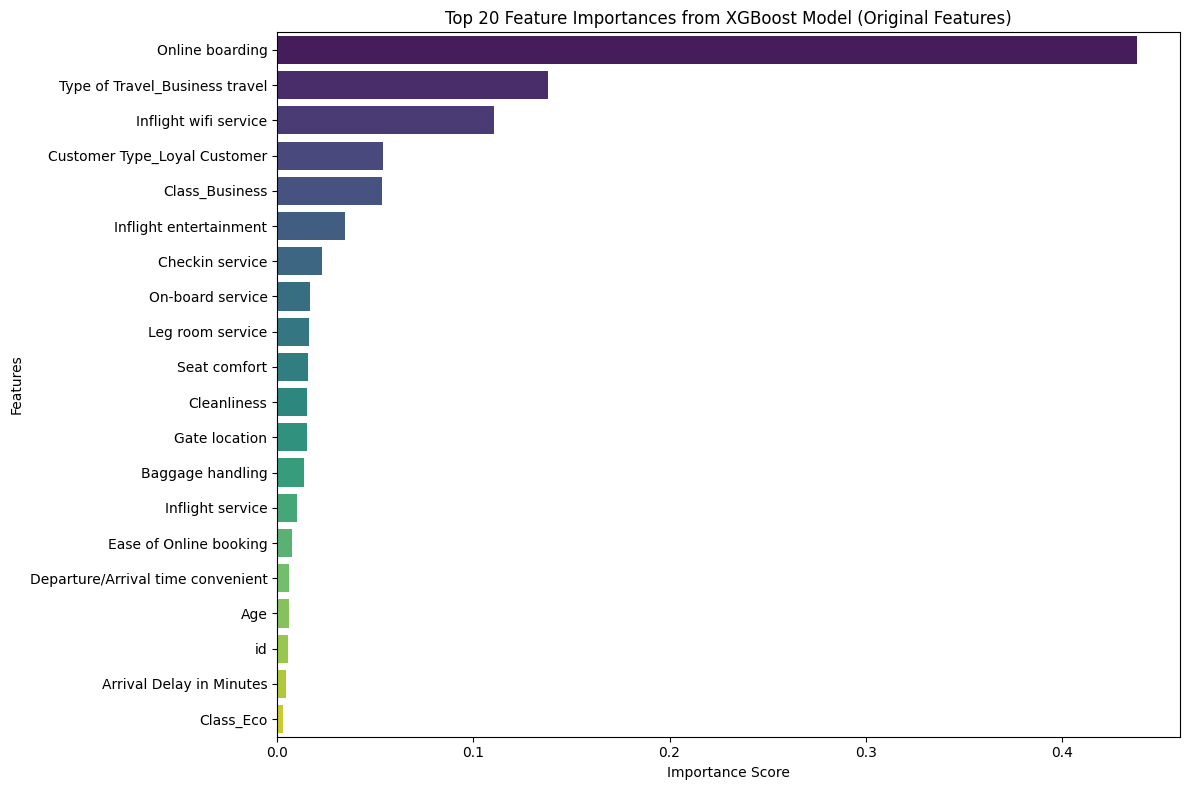


Top 10 most important features from the original dataset (according to XGBoost):
Online boarding                   0.438251
Type of Travel_Business travel    0.138058
Inflight wifi service             0.110640
Customer Type_Loyal Customer      0.054059
Class_Business                    0.053684
Inflight entertainment            0.034693
Checkin service                   0.023064
On-board service                  0.016815
Leg room service                  0.016095
Seat comfort                      0.015670
dtype: float32


In [44]:
import matplotlib.pyplot as plt

# Get feature importances from the best XGBoost model
feature_importances = best_xgb.feature_importances_

# Create a pandas Series for easier handling and sorting
importance_df = pd.Series(feature_importances, index=X_train_final_non_smote.columns)

# Sort the features by importance
importance_df = importance_df.sort_values(ascending=False)

# Plot the top N important features (e.g., top 20)
plt.figure(figsize=(12, 8))
sns.barplot(x=importance_df.head(20).values, y=importance_df.head(20).index, palette='viridis')
plt.title('Top 20 Feature Importances from XGBoost Model (Original Features)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\nTop 10 most important features from the original dataset (according to XGBoost):")
print(importance_df.head(10))

In [45]:
# Configuration
BATCH_SIZE = 256
EPOCHS = 100  # Epochs for AutoEncoder training
LR = 0.001   # Learning Rate
ENCODING_DIM = 16  # Dimension of the bottleneck layer (Latent Features)
GA_GENERATIONS = 20 # Number of generations for Genetic Algorithm
GA_PARENTS = 6
GA_POPULATION = 15

In [46]:
# --- 2. DEEP AUTOENCODER (DAE) ARCHITECTURE ---
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()

        # Encoder: Compresses data
        # Paper Architecture: Input -> Dense -> Batch Normalization -> LeakyReLU -> Bottleneck
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.Linear(32, encoding_dim), # Bottleneck Layer (Latent Features)
            nn.BatchNorm1d(encoding_dim),
            nn.LeakyReLU()
        )

        # Decoder: Reconstructs data (Symmetrical to Encoder)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),

            nn.Linear(64, input_dim) # Output layer reconstructs original input
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [47]:
def train_dae_model(X_train):
    """
    Trains the DAE and returns the trained model and the latent features.
    """
    # Convert to Tensor and create DataLoader
    X_tensor = torch.FloatTensor(X_train)
    train_loader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=True)

    input_dim = X_train.shape[1]
    model = DeepAutoEncoder(input_dim, ENCODING_DIM).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    print(f"\nTraining Deep AutoEncoder for {EPOCHS} epochs...")
    model.train()
    for epoch in range(EPOCHS):
        train_loss = 0
        for batch in train_loader:
            inputs = batch[0].to(device)
            optimizer.zero_grad()

            _, reconstructed = model(inputs)

            loss = criterion(reconstructed, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss / len(train_loader):.4f}")

    return model

In [48]:
def get_latent_features(model, X_data):
    """Passes data through the Encoder to get bottleneck features."""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_data).to(device)
        latent_features = model.encoder(X_tensor).cpu().numpy()
    return latent_features

In [49]:
# Train the DAE model
dae_model = train_dae_model(X_train_final_non_smote.values)

# Get latent features for training and test sets
X_train_latent = get_latent_features(dae_model, X_train_final_non_smote.values)
X_test_latent = get_latent_features(dae_model, X_test_final_non_smote.values)

print(f"\nShape of X_train_latent: {X_train_latent.shape}")
print(f"Shape of X_test_latent: {X_test_latent.shape}")


Training Deep AutoEncoder for 100 epochs...
Epoch 5/100 | Loss: 0.1225
Epoch 10/100 | Loss: 0.0919
Epoch 15/100 | Loss: 0.0757
Epoch 20/100 | Loss: 0.0662
Epoch 25/100 | Loss: 0.0575
Epoch 30/100 | Loss: 0.0513
Epoch 35/100 | Loss: 0.0468
Epoch 40/100 | Loss: 0.0431
Epoch 45/100 | Loss: 0.0410
Epoch 50/100 | Loss: 0.0398
Epoch 55/100 | Loss: 0.0384
Epoch 60/100 | Loss: 0.0377
Epoch 65/100 | Loss: 0.0367
Epoch 70/100 | Loss: 0.0363
Epoch 75/100 | Loss: 0.0361
Epoch 80/100 | Loss: 0.0351
Epoch 85/100 | Loss: 0.0346
Epoch 90/100 | Loss: 0.0345
Epoch 95/100 | Loss: 0.0339
Epoch 100/100 | Loss: 0.0338

Shape of X_train_latent: (103904, 16)
Shape of X_test_latent: (25976, 16)


#### Genetic Algorithm

In [50]:
# ==========================================
# 4. GENETIC ALGORITHM (GA) MODULE
# ==========================================
# Global variables required for PyGAD fitness function
X_latent_train = None
X_latent_test = None
y_train_global = None
y_test_global = None

def fitness_function(ga_instance, solution, solution_idx):
    """
    Evaluates a solution (subset of features).
    Fitness = Accuracy of a Decision Tree trained on selected features.
    """
    # 'solution' is a binary array [1, 0, 1...] indicating selected features
    selected_indices = np.where(solution == 1)[0]

    # Penalize if no features are selected
    if len(selected_indices) == 0:
        return 0

    # Filter dataset to selected features only
    X_tr_sel = X_latent_train[:, selected_indices]
    X_te_sel = X_latent_test[:, selected_indices]

    # Train a lightweight classifier (Decision Tree) for evaluation
    # This matches the methodology in Lee et al. (2024)
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_tr_sel, y_train_global)
    preds = clf.predict(X_te_sel)

    acc = accuracy_score(y_test_global, preds)
    return acc

def run_feature_optimization(X_train_lat, X_test_lat, y_train, y_test):
    global X_latent_train, X_latent_test, y_train_global, y_test_global

    X_latent_train = X_train_lat
    X_latent_test = X_test_lat
    y_train_global = y_train
    y_test_global = y_test

    print("\nRunning Genetic Algorithm for Feature Selection...")

    ga_instance = pygad.GA(
        num_generations=GA_GENERATIONS,
        num_parents_mating=GA_PARENTS,
        fitness_func=fitness_function,
        sol_per_pop=GA_POPULATION,
        num_genes=ENCODING_DIM, # Number of genes = number of latent features
        gene_type=int,          # Binary selection (0 or 1)
        init_range_low=0,
        init_range_high=2,
        mutation_percent_genes=10,
        parent_selection_type="sss", # Steady State Selection
        crossover_type="single_point",
        mutation_type="random",
        keep_parents=1
    )

    ga_instance.run()

    # Get best solution
    solution, solution_fitness, _ = ga_instance.best_solution()
    selected_features = np.where(solution == 1)[0]

    print(f"GA Completed. Best Fitness (Accuracy): {solution_fitness:.4f}")
    print(f"Selected Latent Feature Indices: {selected_features}")

    # Return Optimized Data
    return X_train_lat[:, selected_features], X_test_lat[:, selected_features]

In [51]:
# Run the Genetic Algorithm for feature optimization
X_train_optimized, X_test_optimized = run_feature_optimization(
    X_train_latent,
    X_test_latent,
    y_train_xgb_non_smote,  # Using the numerically encoded y for the Decision Tree in GA
    y_test_xgb_non_smote
)

print(f"\nShape of X_train_optimized (after GA): {X_train_optimized.shape}")
print(f"Shape of X_test_optimized (after GA): {X_test_optimized.shape}")


Running Genetic Algorithm for Feature Selection...
GA Completed. Best Fitness (Accuracy): 0.8688
Selected Latent Feature Indices: [ 0  1  2  3  4  5  7  8 11 12 13 14 15]

Shape of X_train_optimized (after GA): (103904, 13)
Shape of X_test_optimized (after GA): (25976, 13)


##### HistGBDT

In [52]:
# ============================================
# HISTGRADIENTBOOSTING (HistGBDT) + GRIDSEARCH
# ============================================

hist_base_dae_ga = HistGradientBoostingClassifier(random_state=42)

param_grid_hist = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [None, 3, 5, 7],
    "max_iter": [100, 200, 300],
}

hist_search_dae_ga = GridSearchCV(
    estimator=hist_base_dae_ga,
    param_grid=param_grid_hist,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

hist_search_dae_ga.fit(X_train_optimized, y_train_final_non_smote)

best_hist = hist_search_dae_ga.best_estimator_
print("Best params HistGBDT:", hist_search_dae_ga.best_params_)

y_pred_hist = best_hist.predict(X_test_optimized)

print("\n=== HistGBDT (Non-SMOTE) + DAE-GA ===")
print("Accuracy:", accuracy_score(y_test_final_non_smote, y_pred_hist))
print(classification_report(y_test_final_non_smote, y_pred_hist))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params HistGBDT: {'learning_rate': 0.1, 'max_depth': None, 'max_iter': 300}

=== HistGBDT (Non-SMOTE) + DAE-GA ===
Accuracy: 0.9195026178010471
                         precision    recall  f1-score   support

neutral or dissatisfied       0.91      0.95      0.93     14573
              satisfied       0.93      0.88      0.91     11403

               accuracy                           0.92     25976
              macro avg       0.92      0.92      0.92     25976
           weighted avg       0.92      0.92      0.92     25976



##### XGBoost

In [53]:
# ============================================
# XGBOOST + GRIDSEARCH
# ============================================

# ============================================
# ENCODE LABEL UNTUK XGBOOST (0 / 1)
# ============================================
label_map = {
    "neutral or dissatisfied": 0,
    "satisfied": 1
}

y_train_xgb_non_smote = y_train_final_non_smote.map(label_map)
y_test_xgb_non_smote  = y_test_final_non_smote.map(label_map)

print("Unique train labels (XGB):", y_train_xgb_non_smote.unique())
print("Unique test labels  (XGB):", y_test_xgb_non_smote.unique())

xgb_base_dae_ga = XGBClassifier(
    objective="binary:logistic",   # kalau multi-class → "multi:softprob" + num_class=...
    eval_metric="logloss",
    use_label_encoder=False if "use_label_encoder" in XGBClassifier().get_params() else None,
    random_state=42,
)

param_grid_xgb = {
    "n_estimators": [200, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
}

xgb_search_dae_ga = GridSearchCV(
    estimator=xgb_base_dae_ga,
    param_grid=param_grid_xgb,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

xgb_search_dae_ga.fit(X_train_optimized, y_train_xgb_non_smote)

best_xgb = xgb_search_dae_ga.best_estimator_
print("Best params XGBoost:", xgb_search_dae_ga.best_params_)

y_pred_xgb = best_xgb.predict(X_test_optimized)

print("\n=== XGBoost (Non-SMOTE) + DAE-GA ===")
print("Accuracy:", accuracy_score(y_test_xgb_non_smote, y_pred_xgb))
print(classification_report(y_test_xgb_non_smote, y_pred_xgb))

Unique train labels (XGB): [0 1]
Unique test labels  (XGB): [1 0]
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}

=== XGBoost (Non-SMOTE) + DAE-GA ===
Accuracy: 0.9268555589775177
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     14573
           1       0.93      0.90      0.91     11403

    accuracy                           0.93     25976
   macro avg       0.93      0.92      0.93     25976
weighted avg       0.93      0.93      0.93     25976



In [54]:
# ============================================
# CATBOOST + GRIDSEARCH
# ============================================

cat_base_dae_ga = CatBoostClassifier(
    loss_function="Logloss",   # kalau multi-class → "MultiClass"
    verbose=0,
    random_seed=42,
)

param_grid_cat = {
    "iterations": [200, 300, 500],
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
}

cat_search_dae_ga = GridSearchCV(
    estimator=cat_base_dae_ga,
    param_grid=param_grid_cat,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

cat_search_dae_ga.fit(X_train_optimized, y_train_final_non_smote)

best_cat = cat_search_dae_ga.best_estimator_
print("Best params CatBoost:", cat_search_dae_ga.best_params_)

y_pred_cat = best_cat.predict(X_test_optimized)

print("\n=== CatBoost (Non-SMOTE) + DAE-GA ===")
print("Accuracy:", accuracy_score(y_test_final_non_smote, y_pred_cat))
print(classification_report(y_test_final_non_smote, y_pred_cat))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params CatBoost: {'depth': 8, 'iterations': 500, 'learning_rate': 0.1}

=== CatBoost (Non-SMOTE) + DAE-GA ===
Accuracy: 0.9256621496766245
                         precision    recall  f1-score   support

neutral or dissatisfied       0.92      0.95      0.93     14573
              satisfied       0.93      0.89      0.91     11403

               accuracy                           0.93     25976
              macro avg       0.93      0.92      0.92     25976
           weighted avg       0.93      0.93      0.93     25976



In [55]:
# ============================================
# RANDOM FOREST + GRIDSEARCH
# ============================================

rf_base_dae_ga = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
)

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "max_features": ["sqrt", "log2"],
}

rf_search_dae_ga = GridSearchCV(
    estimator=rf_base_dae_ga,
    param_grid=param_grid_rf,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

rf_search_dae_ga.fit(X_train_optimized, y_train_final_non_smote)

best_rf = rf_search_dae_ga.best_estimator_
print("Best params RandomForest:", rf_search_dae_ga.best_params_)

y_pred_rf = best_rf.predict(X_test_optimized)

print("\n=== RandomForest (Non-SMOTE) + DAE-GA ===")
print("Accuracy:", accuracy_score(y_test_final_non_smote, y_pred_rf))
print(classification_report(y_test_final_non_smote, y_pred_rf))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END learning_rate=0.01, max_depth=None, max_iter=100;, score=0.877 total time=   2.7s
[CV 2/3] END learning_rate=0.01, max_depth=None, max_iter=200;, score=0.885 total time=   5.0s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_iter=100;, score=0.844 total time=   1.8s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_iter=100;, score=0.843 total time=   1.7s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_iter=200;, score=0.850 total time=   3.0s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_iter=300;, score=0.859 total time=   4.4s
[CV 3/3] END learning_rate=0.01, max_depth=5, max_iter=100;, score=0.872 total time=   2.3s
[CV 1/3] END learning_rate=0.01, max_depth=5, max_iter=300;, score=0.884 total time=   6.2s
[CV 3/3] END learning_rate=0.01, max_depth=7, max_iter=100;, score=0.879 total time=   2.6s
[CV 2/3] END learning_rate=0.01, max_depth=7, max_iter=200;, score=0.884 total time=   4.7s
[CV 3/3] END 

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/3] END learning_rate=0.01, max_depth=None, max_iter=100;, score=0.876 total time=   2.7s
[CV 1/3] END learning_rate=0.01, max_depth=None, max_iter=300;, score=0.893 total time=   7.4s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_iter=100;, score=0.847 total time=   1.7s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_iter=200;, score=0.851 total time=   3.1s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_iter=300;, score=0.861 total time=   4.4s
[CV 1/3] END learning_rate=0.01, max_depth=5, max_iter=200;, score=0.876 total time=   4.3s
[CV 2/3] END learning_rate=0.01, max_depth=5, max_iter=300;, score=0.883 total time=   6.2s
[CV 3/3] END learning_rate=0.01, max_depth=7, max_iter=200;, score=0.886 total time=   4.8s
[CV 1/3] END learning_rate=0.05, max_depth=None, max_iter=100;, score=0.904 total time=   2.6s
[CV 3/3] END learning_rate=0.05, max_depth=None, max_iter=100;, score=0.905 total time=   2.7s
[CV 2/3] END learning_rate=0.05, max_depth=None, max_iter=200;, scor

In [56]:
# ============================================
# DECISION TREE + GRIDSEARCH
# ============================================

dt_base_dae_ga = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    "max_depth": [None, 5, 10, 20],
    "criterion": ["gini", "entropy"],
}

dt_search_dae_ga = GridSearchCV(
    estimator=dt_base_dae_ga,
    param_grid=param_grid_dt,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

dt_search_dae_ga.fit(X_train_optimized, y_train_final_non_smote)

best_dt = dt_search_dae_ga.best_estimator_
print("Best params DecisionTree:", dt_search_dae_ga.best_params_)

y_pred_dt = best_dt.predict(X_test_optimized)

print("\n=== DecisionTree (Non-SMOTE) + DAE-GA ===")
print("Accuracy:", accuracy_score(y_test_final_non_smote, y_pred_dt))
print(classification_report(y_test_final_non_smote, y_pred_dt))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params DecisionTree: {'criterion': 'gini', 'max_depth': 10}

=== DecisionTree (Non-SMOTE) + DAE-GA ===
Accuracy: 0.8858946720049277
                         precision    recall  f1-score   support

neutral or dissatisfied       0.87      0.93      0.90     14573
              satisfied       0.91      0.83      0.86     11403

               accuracy                           0.89     25976
              macro avg       0.89      0.88      0.88     25976
           weighted avg       0.89      0.89      0.89     25976



In [57]:
# ============================================
# 1. Encode target → integer (wajib utk CE Loss)
# ============================================
le_ft = LabelEncoder()
y_train_ft = le_ft.fit_transform(y_train_final_non_smote)
y_test_ft  = le_ft.transform(y_test_final_non_smote)

n_classes = len(le_ft.classes_)
print("Classes:", le_ft.classes_)
print("n_classes:", n_classes)

# ============================================
# 2. Konversi NumPy Array ke DataFrame
#    (TorchFrame butuh nama kolom)
# ============================================

# Buat nama kolom generik karena numpy array tidak punya header
# Contoh hasil: ['feat_0', 'feat_1', 'feat_2', ...]
num_features = X_train_optimized.shape[1]
generic_feat_names = [f"feat_{i}" for i in range(num_features)]

# Bungkus array jadi DataFrame dan beri nama kolom
df_train_ft = pd.DataFrame(X_train_optimized, columns=generic_feat_names)
df_train_ft["satisfaction"] = y_train_ft

df_test_ft = pd.DataFrame(X_test_optimized, columns=generic_feat_names)
df_test_ft["satisfaction"] = y_test_ft

feature_cols = generic_feat_names

col_to_stype = {c: torch_frame.numerical for c in feature_cols}
col_to_stype["satisfaction"] = torch_frame.categorical  # <-- tambahin ini

print("Total fitur numerik:", len(feature_cols))


Classes: ['neutral or dissatisfied' 'satisfied']
n_classes: 2
Total fitur numerik: 13


In [58]:
# ============================================
# 3. Dataset TorchFrame
# ============================================
train_dataset = Dataset(
    df=df_train_ft,
    col_to_stype=col_to_stype,
    target_col="satisfaction",
).materialize()

test_dataset = Dataset(
    df=df_test_ft,
    col_to_stype=col_to_stype,
    target_col="satisfaction",
).materialize(col_stats=train_dataset.col_stats)

print("Train rows:", train_dataset.num_rows)
print("Test rows :", test_dataset.num_rows)

# ============================================
# 4. DataLoader
# ============================================
batch_size = 512

train_loader = DataLoader(
    train_dataset.tensor_frame,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    test_dataset.tensor_frame,
    batch_size=batch_size,
    shuffle=False,
)


Train rows: 103904
Test rows : 25976


In [59]:
# ============================================
# 5. Model FTTransformer
# ============================================
numerical_encoder = LinearEncoder()

stype_encoder_dict = {
    torch_frame.numerical: numerical_encoder,
}

model_ft = FTTransformer(
    channels=256,
    out_channels=n_classes,
    num_layers=4,
    col_stats=train_dataset.col_stats,
    col_names_dict=train_dataset.tensor_frame.col_names_dict,
    stype_encoder_dict=stype_encoder_dict,
).to(device)

try:
    model_ft = torch.compile(model_ft, dynamic=True, backend="eager")
    print("Model compiled with torch.compile")
except Exception as e:
    print("torch.compile skipped:", e)

optimizer = torch.optim.AdamW(model_ft.parameters(), lr=1e-4)


Model compiled with torch.compile


In [60]:
# ============================================
# 6. Training & Eval Loop + Early Stopping
# ============================================
def train_one_epoch(epoch: int) -> float:
    model_ft.train()
    loss_accum = 0.0
    total_count = 0

    for tf in tqdm(train_loader, desc=f"Epoch {epoch}"):
        tf = tf.to(device)
        pred = model_ft(tf)            # [batch, n_classes]
        loss = F.cross_entropy(pred, tf.y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)

    return loss_accum / total_count


@torch.no_grad()
def eval_loader(loader: DataLoader) -> float:
    model_ft.eval()
    correct = 0
    total = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model_ft(tf)
        pred_class = pred.argmax(dim=-1)
        correct += int((pred_class == tf.y).sum())
        total += len(tf.y)

    return correct / total


# ============================================
# EARLY STOPPING SETUP
# ============================================
epochs = 50
patience = 5          # berapa epoch tanpa improvement sebelum stop
min_delta = 1e-4      # minimal kenaikan akurasi yang dianggap "improve"

best_val_acc_dae_ga = 0.0
best_state_dict = None
no_improve_epochs = 0

for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(epoch)
    train_acc = eval_loader(train_loader)     # optional: monitor train acc
    val_acc   = eval_loader(test_loader)     # di sini test_loader sedang kita treat sebagai "val_loader"

    # Cek improvement untuk early stopping
    if val_acc > best_val_acc_dae_ga + min_delta:
        best_val_acc_dae_ga = val_acc
        best_state_dict = copy.deepcopy(model_ft.state_dict())
        no_improve_epochs = 0
        status = " (improved ✅)"
    else:
        no_improve_epochs += 1
        status = f" (no improve: {no_improve_epochs}/{patience})"

    print(
        f"Epoch {epoch:03d} | "
        f"TrainLoss: {train_loss:.4f} | "
        f"TrainAcc: {train_acc:.4f} | "
        f"ValAcc: {val_acc:.4f}{status}"
    )

    # Cek early stopping
    if no_improve_epochs >= patience:
        print(f"\n⛔ Early stopping triggered at epoch {epoch}.")
        break

# ============================================
# LOAD BEST MODEL (kalau sempat improve)
# ============================================
if best_state_dict is not None:
    model_ft.load_state_dict(best_state_dict)
    print(f"\nLoaded best model with ValAcc = {best_val_acc_dae_ga:.4f}")
else:
    print("\nWarning: tidak ada improvement selama training, model terakhir dipakai apa adanya.")

print(f"\nBest Val Accuracy (FTTransformer, non-SMOTE): {best_val_acc_dae_ga:.4f}")


Epoch 1: 100%|██████████| 203/203 [00:08<00:00, 24.98it/s]


Epoch 001 | TrainLoss: 0.3388 | TrainAcc: 0.8982 | ValAcc: 0.8973 (improved ✅)


Epoch 2: 100%|██████████| 203/203 [00:07<00:00, 28.44it/s]


Epoch 002 | TrainLoss: 0.2540 | TrainAcc: 0.9113 | ValAcc: 0.9101 (improved ✅)


Epoch 3: 100%|██████████| 203/203 [00:07<00:00, 28.44it/s]


Epoch 003 | TrainLoss: 0.2391 | TrainAcc: 0.9123 | ValAcc: 0.9108 (improved ✅)


Epoch 4: 100%|██████████| 203/203 [00:07<00:00, 28.45it/s]


Epoch 004 | TrainLoss: 0.2284 | TrainAcc: 0.9133 | ValAcc: 0.9101 (no improve: 1/5)


Epoch 5: 100%|██████████| 203/203 [00:07<00:00, 28.41it/s]


Epoch 005 | TrainLoss: 0.2204 | TrainAcc: 0.9146 | ValAcc: 0.9107 (no improve: 2/5)


Epoch 6: 100%|██████████| 203/203 [00:07<00:00, 28.43it/s]


Epoch 006 | TrainLoss: 0.2162 | TrainAcc: 0.9162 | ValAcc: 0.9140 (improved ✅)


Epoch 7: 100%|██████████| 203/203 [00:07<00:00, 28.42it/s]


Epoch 007 | TrainLoss: 0.2124 | TrainAcc: 0.9228 | ValAcc: 0.9195 (improved ✅)


Epoch 8: 100%|██████████| 203/203 [00:07<00:00, 28.45it/s]


Epoch 008 | TrainLoss: 0.2077 | TrainAcc: 0.9203 | ValAcc: 0.9156 (no improve: 1/5)


Epoch 9: 100%|██████████| 203/203 [00:07<00:00, 28.44it/s]


Epoch 009 | TrainLoss: 0.2069 | TrainAcc: 0.9237 | ValAcc: 0.9193 (no improve: 2/5)


Epoch 10: 100%|██████████| 203/203 [00:07<00:00, 28.45it/s]


Epoch 010 | TrainLoss: 0.2047 | TrainAcc: 0.9224 | ValAcc: 0.9160 (no improve: 3/5)


Epoch 11: 100%|██████████| 203/203 [00:07<00:00, 28.47it/s]


Epoch 011 | TrainLoss: 0.2027 | TrainAcc: 0.9239 | ValAcc: 0.9178 (no improve: 4/5)


Epoch 12: 100%|██████████| 203/203 [00:07<00:00, 28.45it/s]


Epoch 012 | TrainLoss: 0.2008 | TrainAcc: 0.9213 | ValAcc: 0.9167 (no improve: 5/5)

⛔ Early stopping triggered at epoch 12.

Loaded best model with ValAcc = 0.9195

Best Val Accuracy (FTTransformer, non-SMOTE): 0.9195


In [61]:
@torch.no_grad()
def eval_detailed(loader: DataLoader):
    model_ft.eval()
    all_pred = []
    all_true = []

    for tf in loader:
        tf = tf.to(device)
        pred = model_ft(tf)
        pred_class = pred.argmax(dim=-1).cpu().numpy()
        all_pred.extend(pred_class)
        all_true.extend(tf.y.cpu().numpy())

    return np.array(all_true), np.array(all_pred)

y_true_test_dae_ga, y_pred_test_dae_ga = eval_detailed(test_loader)

print("=== FTTransformer (PyTorch Frame, NON-SMOTE) + DAE-GA ===")
print("Accuracy:", accuracy_score(y_true_test_dae_ga, y_pred_test_dae_ga))
print(
    classification_report(
        y_true_test_dae_ga,
        y_pred_test_dae_ga,
        target_names=le_ft.classes_,
    )
)


=== FTTransformer (PyTorch Frame, NON-SMOTE) + DAE-GA ===
Accuracy: 0.9194641207268247
                         precision    recall  f1-score   support

neutral or dissatisfied       0.91      0.95      0.93     14573
              satisfied       0.93      0.88      0.91     11403

               accuracy                           0.92     25976
              macro avg       0.92      0.92      0.92     25976
           weighted avg       0.92      0.92      0.92     25976



In [62]:
performance_data_dae_ga = {
    'Model': [
        'HistGradientBoosting (Non-SMOTE) + DAE-GA',
        'XGBoost (Non-SMOTE) + DAE-GA',
        'CatBoost (Non-SMOTE) + DAE-GA',
        'RandomForest (Non-SMOTE) + DAE-GA',
        'DecisionTree (Non-SMOTE) + DAE-GA',
        'FT-Transformer (Non-SMOTE) + DAE-GA'
    ],
    'Accuracy': [
        accuracy_score(y_test_final_non_smote, hist_search_dae_ga.best_estimator_.predict(X_test_optimized)),
        accuracy_score(y_test_xgb_non_smote, xgb_search_dae_ga.best_estimator_.predict(X_test_optimized)),
        accuracy_score(y_test_final_non_smote, cat_search_dae_ga.best_estimator_.predict(X_test_optimized)),
        accuracy_score(y_test_final_non_smote, rf_search_dae_ga.best_estimator_.predict(X_test_optimized)),
        accuracy_score(y_test_final_non_smote, dt_search_dae_ga.best_estimator_.predict(X_test_optimized)),
        best_val_acc_dae_ga
    ],
    'F1 Score': [
        f1_score(y_test_final_non_smote, hist_search_dae_ga.best_estimator_.predict(X_test_optimized), average='weighted'),
        f1_score(y_test_xgb_non_smote, xgb_search_dae_ga.best_estimator_.predict(X_test_optimized), average='weighted'),
        f1_score(y_test_final_non_smote, cat_search_dae_ga.best_estimator_.predict(X_test_optimized), average='weighted'),
        f1_score(y_test_final_non_smote, rf_search_dae_ga.best_estimator_.predict(X_test_optimized), average='weighted'),
        f1_score(y_test_final_non_smote, dt_search_dae_ga.best_estimator_.predict(X_test_optimized), average='weighted'),
        f1_score(y_true_test_dae_ga, y_pred_test_dae_ga, average='weighted')
    ]
}

performance_df_dae_ga = pd.DataFrame(performance_data_dae_ga)
performance_df_dae_ga = performance_df_dae_ga.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)


In [63]:
# === GABUNGKAN DATAFRAME DAE-GA LANGSUNG KE DATAFRAME LAMA ===
performance_df = pd.concat(
    [performance_df, performance_df_dae_ga],
    ignore_index=True
)

# Sort ulang berdasarkan akurasi
performance_df = performance_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\n--- Combined Performance Comparison (Non-SMOTE + DAE-GA) ---")
performance_df



--- Combined Performance Comparison (Non-SMOTE + DAE-GA) ---


,Model,Accuracy,F1 Score
0,FT-Transformer (Non-SMOTE),0.967123,0.967063
1,CatBoost (Non-SMOTE),0.966777,0.966728
2,HistGradientBoosting (Non-SMOTE),0.966354,0.966296
3,XGBoost (Non-SMOTE),0.966123,0.966071
4,RandomForest (Non-SMOTE),0.965353,0.965292
5,DecisionTree (Non-SMOTE),0.950839,0.950814
6,XGBoost (Non-SMOTE) + DAE-GA,0.926856,0.926671
7,CatBoost (Non-SMOTE) + DAE-GA,0.925662,0.925472
8,RandomForest (Non-SMOTE) + DAE-GA,0.920696,0.920412
9,HistGradientBoosting (Non-SMOTE) + DAE-GA,0.919503,0.919258


## Class Imbalance (Original, Undersampling, SMOTE) Test

### Undersampling

In [64]:
# ============================================
# HISTGRADIENTBOOSTING (HistGBDT) + GRIDSEARCH
# ============================================

hist_base_undersampled = HistGradientBoostingClassifier(random_state=42)

param_grid_hist = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [None, 3, 5, 7],
    "max_iter": [100, 200, 300],
}

hist_search_undersampled = GridSearchCV(
    estimator=hist_base_undersampled,
    param_grid=param_grid_hist,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

hist_search_undersampled.fit(X_train_final_undersampled, y_train_final_undersampled)

best_hist = hist_search_undersampled.best_estimator_
print("Best params HistGBDT:", hist_search_undersampled.best_params_)

y_pred_hist = best_hist.predict(X_test_final_undersampled)

print("\n=== HistGBDT (UNDERSAMPLED) ===")
print("Accuracy:", accuracy_score(y_test_final_undersampled, y_pred_hist))
print(classification_report(y_test_final_undersampled, y_pred_hist))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params HistGBDT: {'learning_rate': 0.05, 'max_depth': None, 'max_iter': 300}

=== HistGBDT (UNDERSAMPLED) ===
Accuracy: 0.9656606097936556
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.97      0.95      0.96     11403

               accuracy                           0.97     25976
              macro avg       0.97      0.96      0.97     25976
           weighted avg       0.97      0.97      0.97     25976



In [65]:
# ============================================
# XGBOOST + GRIDSEARCH
# ============================================

# ============================================
# ENCODE LABEL UNTUK XGBOOST (0 / 1)
# ============================================
label_map = {
    "neutral or dissatisfied": 0,
    "satisfied": 1
}

y_train_xgb_undersampled = y_train_final_undersampled.map(label_map)
y_test_xgb_undersampled  = y_test_final_undersampled.map(label_map)

print("Unique train labels (XGB):", y_train_xgb_undersampled.unique())
print("Unique test labels  (XGB):", y_test_xgb_undersampled.unique())

xgb_base_undersampled = XGBClassifier(
    objective="binary:logistic",   # kalau multi-class → "multi:softprob" + num_class=...
    eval_metric="logloss",
    use_label_encoder=False if "use_label_encoder" in XGBClassifier().get_params() else None,
    random_state=42,
)

param_grid_xgb = {
    "n_estimators": [200, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
}

xgb_search_undersampled = GridSearchCV(
    estimator=xgb_base_undersampled,
    param_grid=param_grid_xgb,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

xgb_search_undersampled.fit(X_train_final_undersampled, y_train_xgb_undersampled)

best_xgb = xgb_search_undersampled.best_estimator_
print("Best params XGBoost:", xgb_search_undersampled.best_params_)

y_pred_xgb = best_xgb.predict(X_test_final_undersampled)

print("\n=== XGBoost (UNDERSAMPLED) ===")
print("Accuracy:", accuracy_score(y_test_xgb_undersampled, y_pred_xgb))
print(classification_report(y_test_xgb_undersampled, y_pred_xgb))

Unique train labels (XGB): [0 1]
Unique test labels  (XGB): [1 0]
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 2/3] END max_depth=None, max_features=sqrt, n_estimators=200;, score=0.917 total time= 1.7min
[CV 3/3] END max_depth=None, max_features=sqrt, n_estimators=300;, score=0.921 total time= 2.6min
[CV 1/3] END max_depth=None, max_features=log2, n_estimators=300;, score=0.917 total time= 2.6min
[CV 3/3] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.867 total time=  37.1s
[CV 2/3] END max_depth=5, max_features=sqrt, n_estimators=300;, score=0.864 total time=  54.6s
[CV 1/3] END max_depth=5, max_features=log2, n_estimators=200;, score=0.861 total time=  37.4s
[CV 2/3] END max_depth=5, max_features=log2, n_estimators=300;, score=0.864 total time=  55.2s
[CV 1/3] END max_depth=10, max_features=sqrt, n_estimators=200;, score=0.900 total time= 1.1min
[CV 2/3] END max_depth=10, max_features=sqrt, n_estimators=300;, score=0.900 total time= 1.6min
[CV 3/3

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/3] END max_depth=None, max_features=sqrt, n_estimators=300;, score=0.917 total time= 2.6min
[CV 2/3] END max_depth=None, max_features=log2, n_estimators=100;, score=0.916 total time=  53.7s
[CV 2/3] END max_depth=None, max_features=log2, n_estimators=200;, score=0.917 total time= 1.8min
[CV 3/3] END max_depth=None, max_features=log2, n_estimators=300;, score=0.921 total time= 2.6min
[CV 1/3] END max_depth=5, max_features=log2, n_estimators=100;, score=0.861 total time=  19.8s
[CV 2/3] END max_depth=5, max_features=log2, n_estimators=100;, score=0.864 total time=  19.0s
[CV 2/3] END max_depth=5, max_features=log2, n_estimators=200;, score=0.864 total time=  36.9s
[CV 3/3] END max_depth=5, max_features=log2, n_estimators=300;, score=0.867 total time=  54.5s
[CV 2/3] END max_depth=10, max_features=sqrt, n_estimators=200;, score=0.900 total time= 1.1min
[CV 3/3] END max_depth=10, max_features=sqrt, n_estimators=300;, score=0.903 total time= 1.6min
[CV 1/3] END max_depth=10, max_featu

In [66]:
# ============================================
# CATBOOST + GRIDSEARCH
# ============================================

cat_base_undersampled = CatBoostClassifier(
    loss_function="Logloss",   # kalau multi-class → "MultiClass"
    verbose=0,
    random_seed=42,
)

param_grid_cat = {
    "iterations": [200, 300, 500],
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
}

cat_search_undersampled = GridSearchCV(
    estimator=cat_base_undersampled,
    param_grid=param_grid_cat,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

cat_search_undersampled.fit(X_train_final_undersampled, y_train_final_undersampled)

best_cat = cat_search_undersampled.best_estimator_
print("Best params CatBoost:", cat_search_undersampled.best_params_)

y_pred_cat = best_cat.predict(X_test_final_undersampled)

print("\n=== CatBoost (UNDERSAMPLED) ===")
print("Accuracy:", accuracy_score(y_test_final_undersampled, y_pred_cat))
print(classification_report(y_test_final_undersampled, y_pred_cat))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 3/3] END max_depth=None, max_features=sqrt, n_estimators=200;, score=0.921 total time= 1.7min
[CV 1/3] END max_depth=None, max_features=log2, n_estimators=100;, score=0.916 total time=  53.9s
[CV 3/3] END max_depth=None, max_features=log2, n_estimators=100;, score=0.920 total time=  53.7s
[CV 3/3] END max_depth=None, max_features=log2, n_estimators=200;, score=0.921 total time= 1.8min
[CV 1/3] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.861 total time=  19.3s
[CV 2/3] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.864 total time=  19.5s
[CV 3/3] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.866 total time=  19.1s
[CV 1/3] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.861 total time=  37.5s
[CV 2/3] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.864 total time=  37.4s
[CV 1/3] END max_depth=5, max_features=sqrt, n_estimators=300;, score=0.

In [67]:
# ============================================
# RANDOM FOREST + GRIDSEARCH
# ============================================

rf_base_undersampled = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
)

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "max_features": ["sqrt", "log2"],
}

rf_search_undersampled = GridSearchCV(
    estimator=rf_base_undersampled,
    param_grid=param_grid_rf,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

rf_search_undersampled.fit(X_train_final_undersampled, y_train_final_undersampled)

best_rf = rf_search_undersampled.best_estimator_
print("Best params RandomForest:", rf_search_undersampled.best_params_)

y_pred_rf = best_rf.predict(X_test_final_undersampled)

print("\n=== RandomForest (UNDERSAMPLED) ===")
print("Accuracy:", accuracy_score(y_test_final_undersampled, y_pred_rf))
print(classification_report(y_test_final_undersampled, y_pred_rf))


Fitting 3 folds for each of 24 candidates, totalling 72 fits

[CV 2/3] END depth=6, iterations=500, learning_rate=0.01;, score=0.952 total time=  28.3s
[CV 2/3] END depth=6, iterations=500, learning_rate=0.05;, score=0.962 total time=  28.2s
[CV 3/3] END depth=6, iterations=500, learning_rate=0.1;, score=0.964 total time=  30.3s
[CV 3/3] END depth=8, iterations=200, learning_rate=0.05;, score=0.964 total time=  15.9s
[CV 1/3] END depth=8, iterations=300, learning_rate=0.01;, score=0.955 total time=  23.1s
[CV 2/3] END depth=8, iterations=300, learning_rate=0.05;, score=0.963 total time=  24.2s
[CV 3/3] END depth=8, iterations=300, learning_rate=0.1;, score=0.964 total time=  23.4s
[CV 1/3] END depth=8, iterations=500, learning_rate=0.05;, score=0.963 total time=  36.9s
[CV 2/3] END depth=8, iterations=500, learning_rate=0.1;, score=0.963 total time=  29.7s
[CV 3/3] END max_depth=None, max_features=sqrt, n_estimators=100;, score=0.961 total time=  12.6s


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.934 total time=   3.9s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=500;, score=0.949 total time=   5.3s
[CV 2/3] END learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.948 total time=   3.2s
[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=300;, score=0.952 total time=   4.5s
[CV 1/3] END learning_rate=0.05, max_depth=3, n_estimators=200;, score=0.941 total time=   1.7s
[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=200;, score=0.940 total time=   1.7s
[CV 1/3] END learning_rate=0.05, max_depth=3, n_estimators=300;, score=0.947 total time=   2.4s
[CV 3/3] END learning_rate=0.05, max_depth=3, n_estimators=300;, score=0.946 total time=   2.3s
[CV 1/3] END learning_rate=0.05, max_depth=5, n_estimators=200;, score=0.956 total time=   2.3s
[CV 1/3] END learning_rate=0.05, max_depth=5, n_estimators=300;, score=0.960 total time=   3.2s
[CV 2/3] END learning_rate=0.05, max_dep

In [68]:
# ============================================
# DECISION TREE + GRIDSEARCH
# ============================================

dt_base_undersampled = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    "max_depth": [None, 5, 10, 20],
    "criterion": ["gini", "entropy"],
}

dt_search_undersampled = GridSearchCV(
    estimator=dt_base_undersampled,
    param_grid=param_grid_dt,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

dt_search_undersampled.fit(X_train_final_undersampled, y_train_final_undersampled)

best_dt = dt_search_undersampled.best_estimator_
print("Best params DecisionTree:", dt_search_undersampled.best_params_)

y_pred_dt = best_dt.predict(X_test_final_undersampled)

print("\n=== DecisionTree (UNDERSAMPLED) ===")
print("Accuracy:", accuracy_score(y_test_final_undersampled, y_pred_dt))
print(classification_report(y_test_final_undersampled, y_pred_dt))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params DecisionTree: {'criterion': 'entropy', 'max_depth': 20}

=== DecisionTree (UNDERSAMPLED) ===
Accuracy: 0.9496458269171543
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.95      0.95     14573
              satisfied       0.94      0.95      0.94     11403

               accuracy                           0.95     25976
              macro avg       0.95      0.95      0.95     25976
           weighted avg       0.95      0.95      0.95     25976



In [69]:
# ============================================
# 1. Encode target → integer (wajib utk CE Loss)
# ============================================
le_ft = LabelEncoder()
y_train_ft = le_ft.fit_transform(y_train_final_undersampled)
y_test_ft  = le_ft.transform(y_test_final_undersampled)

n_classes = len(le_ft.classes_)
print("Classes:", le_ft.classes_)
print("n_classes:", n_classes)

# ============================================
# 2. Gabungkan X + y ke DataFrame khusus TorchFrame
#    (TIDAK mengubah variabel asli)
# ============================================
df_train_ft = X_train_final_undersampled.copy()
df_train_ft["satisfaction"] = y_train_ft

df_test_ft = X_test_final_undersampled.copy()
df_test_ft["satisfaction"] = y_test_ft

# Semua fitur di pipeline ini sudah numerik (OHE + scaler)
feature_cols = X_train_final_undersampled.columns.tolist()

col_to_stype = {c: torch_frame.numerical for c in feature_cols}
col_to_stype["satisfaction"] = torch_frame.categorical  # <-- tambahin ini

print("Total fitur numerik:", len(feature_cols))


Classes: ['neutral or dissatisfied' 'satisfied']
n_classes: 2
Total fitur numerik: 28


In [70]:
# ============================================
# 3. Dataset TorchFrame
# ============================================
train_dataset = Dataset(
    df=df_train_ft,
    col_to_stype=col_to_stype,
    target_col="satisfaction",
).materialize()

test_dataset = Dataset(
    df=df_test_ft,
    col_to_stype=col_to_stype,
    target_col="satisfaction",
).materialize(col_stats=train_dataset.col_stats)

print("Train rows:", train_dataset.num_rows)
print("Test rows :", test_dataset.num_rows)

# ============================================
# 4. DataLoader
# ============================================
batch_size = 512

train_loader = DataLoader(
    train_dataset.tensor_frame,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    test_dataset.tensor_frame,
    batch_size=batch_size,
    shuffle=False,
)


Train rows: 90050
Test rows : 25976


In [71]:
# ============================================
# 5. Model FTTransformer
# ============================================
numerical_encoder = LinearEncoder()

stype_encoder_dict = {
    torch_frame.numerical: numerical_encoder,
}

model_ft = FTTransformer(
    channels=256,
    out_channels=n_classes,
    num_layers=4,
    col_stats=train_dataset.col_stats,
    col_names_dict=train_dataset.tensor_frame.col_names_dict,
    stype_encoder_dict=stype_encoder_dict,
).to(device)

try:
    model_ft = torch.compile(model_ft, dynamic=True, backend="eager")
    print("Model compiled with torch.compile")
except Exception as e:
    print("torch.compile skipped:", e)

optimizer = torch.optim.AdamW(model_ft.parameters(), lr=1e-4)


Model compiled with torch.compile


In [72]:
# ============================================
# 6. Training & Eval Loop + Early Stopping
# ============================================
def train_one_epoch(epoch: int) -> float:
    model_ft.train()
    loss_accum = 0.0
    total_count = 0

    for tf in tqdm(train_loader, desc=f"Epoch {epoch}"):
        tf = tf.to(device)
        pred = model_ft(tf)            # [batch, n_classes]
        loss = F.cross_entropy(pred, tf.y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)

    return loss_accum / total_count


@torch.no_grad()
def eval_loader(loader: DataLoader) -> float:
    model_ft.eval()
    correct = 0
    total = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model_ft(tf)
        pred_class = pred.argmax(dim=-1)
        correct += int((pred_class == tf.y).sum())
        total += len(tf.y)

    return correct / total


# ============================================
# EARLY STOPPING SETUP
# ============================================
epochs = 30
patience = 5          # berapa epoch tanpa improvement sebelum stop
min_delta = 1e-4      # minimal kenaikan akurasi yang dianggap "improve"

best_val_acc_undersampled = 0.0
best_state_dict = None
no_improve_epochs = 0

for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(epoch)
    train_acc = eval_loader(train_loader)     # optional: monitor train acc
    val_acc   = eval_loader(test_loader)     # di sini test_loader sedang kita treat sebagai "val_loader"

    # Cek improvement untuk early stopping
    if val_acc > best_val_acc_undersampled + min_delta:
        best_val_acc_undersampled = val_acc
        best_state_dict = copy.deepcopy(model_ft.state_dict())
        no_improve_epochs = 0
        status = " (improved ✅)"
    else:
        no_improve_epochs += 1
        status = f" (no improve: {no_improve_epochs}/{patience})"

    print(
        f"Epoch {epoch:03d} | "
        f"TrainLoss: {train_loss:.4f} | "
        f"TrainAcc: {train_acc:.4f} | "
        f"ValAcc: {val_acc:.4f}{status}"
    )

    # Cek early stopping
    if no_improve_epochs >= patience:
        print(f"\n⛔ Early stopping triggered at epoch {epoch}.")
        break

# ============================================
# LOAD BEST MODEL (kalau sempat improve)
# ============================================
if best_state_dict is not None:
    model_ft.load_state_dict(best_state_dict)
    print(f"\nLoaded best model with ValAcc = {best_val_acc_undersampled:.4f}")
else:
    print("\nWarning: tidak ada improvement selama training, model terakhir dipakai apa adanya.")

print(f"\nBest Val Accuracy (FTTransformer, non-SMOTE): {best_val_acc_undersampled:.4f}")


Epoch 1: 100%|██████████| 176/176 [00:11<00:00, 15.29it/s]


Epoch 001 | TrainLoss: 0.2704 | TrainAcc: 0.9187 | ValAcc: 0.9240 (improved ✅)


Epoch 2: 100%|██████████| 176/176 [00:10<00:00, 16.77it/s]


Epoch 002 | TrainLoss: 0.1553 | TrainAcc: 0.9436 | ValAcc: 0.9473 (improved ✅)


Epoch 3: 100%|██████████| 176/176 [00:10<00:00, 16.79it/s]


Epoch 003 | TrainLoss: 0.1298 | TrainAcc: 0.9492 | ValAcc: 0.9536 (improved ✅)


Epoch 4: 100%|██████████| 176/176 [00:10<00:00, 16.79it/s]


Epoch 004 | TrainLoss: 0.1159 | TrainAcc: 0.9550 | ValAcc: 0.9577 (improved ✅)


Epoch 5: 100%|██████████| 176/176 [00:10<00:00, 16.78it/s]


Epoch 005 | TrainLoss: 0.1073 | TrainAcc: 0.9574 | ValAcc: 0.9580 (improved ✅)


Epoch 6: 100%|██████████| 176/176 [00:10<00:00, 16.79it/s]


Epoch 006 | TrainLoss: 0.1032 | TrainAcc: 0.9604 | ValAcc: 0.9612 (improved ✅)


Epoch 7: 100%|██████████| 176/176 [00:10<00:00, 16.79it/s]


Epoch 007 | TrainLoss: 0.0981 | TrainAcc: 0.9611 | ValAcc: 0.9623 (improved ✅)


Epoch 8: 100%|██████████| 176/176 [00:10<00:00, 16.78it/s]


Epoch 008 | TrainLoss: 0.0953 | TrainAcc: 0.9615 | ValAcc: 0.9624 (no improve: 1/5)


Epoch 9: 100%|██████████| 176/176 [00:10<00:00, 16.80it/s]


Epoch 009 | TrainLoss: 0.0932 | TrainAcc: 0.9606 | ValAcc: 0.9630 (improved ✅)


Epoch 10: 100%|██████████| 176/176 [00:10<00:00, 16.75it/s]


Epoch 010 | TrainLoss: 0.0912 | TrainAcc: 0.9632 | ValAcc: 0.9628 (no improve: 1/5)


Epoch 11: 100%|██████████| 176/176 [00:10<00:00, 16.77it/s]


Epoch 011 | TrainLoss: 0.0908 | TrainAcc: 0.9623 | ValAcc: 0.9623 (no improve: 2/5)


Epoch 12: 100%|██████████| 176/176 [00:10<00:00, 16.76it/s]


Epoch 012 | TrainLoss: 0.0883 | TrainAcc: 0.9632 | ValAcc: 0.9639 (improved ✅)


Epoch 13: 100%|██████████| 176/176 [00:10<00:00, 16.77it/s]


Epoch 013 | TrainLoss: 0.0866 | TrainAcc: 0.9637 | ValAcc: 0.9633 (no improve: 1/5)


Epoch 14: 100%|██████████| 176/176 [00:10<00:00, 16.73it/s]


Epoch 014 | TrainLoss: 0.0856 | TrainAcc: 0.9645 | ValAcc: 0.9642 (improved ✅)


Epoch 15: 100%|██████████| 176/176 [00:10<00:00, 16.77it/s]


Epoch 015 | TrainLoss: 0.0838 | TrainAcc: 0.9593 | ValAcc: 0.9629 (no improve: 1/5)


Epoch 16: 100%|██████████| 176/176 [00:10<00:00, 16.76it/s]


Epoch 016 | TrainLoss: 0.0842 | TrainAcc: 0.9643 | ValAcc: 0.9644 (improved ✅)


Epoch 17: 100%|██████████| 176/176 [00:10<00:00, 16.75it/s]


Epoch 017 | TrainLoss: 0.0824 | TrainAcc: 0.9639 | ValAcc: 0.9640 (no improve: 1/5)


Epoch 18: 100%|██████████| 176/176 [00:10<00:00, 16.75it/s]


Epoch 018 | TrainLoss: 0.0825 | TrainAcc: 0.9655 | ValAcc: 0.9647 (improved ✅)


Epoch 19: 100%|██████████| 176/176 [00:10<00:00, 16.77it/s]


Epoch 019 | TrainLoss: 0.0809 | TrainAcc: 0.9650 | ValAcc: 0.9642 (no improve: 1/5)


Epoch 20:  80%|███████▉  | 140/176 [00:08<00:02, 16.75it/s]

[CV 1/3] END max_depth=None, max_features=log2, n_estimators=200;, score=0.959 total time=  17.2s
[CV 1/3] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.917 total time=   6.2s
[CV 2/3] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.919 total time=   6.0s
[CV 3/3] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.920 total time=   5.8s
[CV 1/3] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.918 total time=   8.1s
[CV 2/3] END max_depth=5, max_features=sqrt, n_estimators=300;, score=0.919 total time=  12.5s
[CV 2/3] END max_depth=5, max_features=log2, n_estimators=100;, score=0.914 total time=   4.9s
[CV 2/3] END max_depth=5, max_features=log2, n_estimators=200;, score=0.914 total time=   8.5s
[CV 3/3] END max_depth=5, max_features=log2, n_estimators=300;, score=0.915 total time=  14.4s
[CV 2/3] END max_depth=10, max_features=sqrt, n_estimators=200;, score=0.945 total time=  18.3s
[CV 3/3] END max_depth=10, max_features=sqrt, 

Epoch 20:  85%|████████▌ | 150/176 [00:08<00:01, 16.59it/s]

[CV 1/3] END max_depth=None, max_features=sqrt, n_estimators=300;, score=0.961 total time=  32.6s
[CV 3/3] END max_depth=None, max_features=log2, n_estimators=200;, score=0.960 total time=  15.5s
[CV 3/3] END max_depth=None, max_features=log2, n_estimators=300;, score=0.960 total time=  30.5s
[CV 2/3] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.921 total time=   8.1s
[CV 3/3] END max_depth=5, max_features=sqrt, n_estimators=300;, score=0.921 total time=  13.4s
[CV 1/3] END max_depth=5, max_features=log2, n_estimators=200;, score=0.914 total time=   8.2s
[CV 2/3] END max_depth=5, max_features=log2, n_estimators=300;, score=0.913 total time=  14.2s
[CV 3/3] END max_depth=10, max_features=sqrt, n_estimators=100;, score=0.948 total time=   9.8s
[CV 1/3] END max_depth=10, max_features=sqrt, n_estimators=300;, score=0.947 total time=  25.7s
[CV 3/3] END max_depth=10, max_features=log2, n_estimators=100;, score=0.945 total time=   7.7s
[CV 2/3] END max_depth=10, max_feature

Epoch 20:  91%|█████████ | 160/176 [00:09<00:00, 16.56it/s]

[CV 3/3] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.922 total time=   9.9s
[CV 1/3] END max_depth=5, max_features=log2, n_estimators=300;, score=0.912 total time=  13.2s
[CV 2/3] END max_depth=10, max_features=sqrt, n_estimators=100;, score=0.946 total time=   9.7s
[CV 3/3] END max_depth=10, max_features=sqrt, n_estimators=200;, score=0.948 total time=  17.4s
[CV 1/3] END max_depth=10, max_features=log2, n_estimators=100;, score=0.942 total time=   8.5s
[CV 2/3] END max_depth=10, max_features=log2, n_estimators=100;, score=0.944 total time=   8.1s
[CV 1/3] END max_depth=10, max_features=log2, n_estimators=200;, score=0.943 total time=  14.9s
[CV 2/3] END max_depth=10, max_features=log2, n_estimators=300;, score=0.943 total time=  22.5s
[CV 1/3] END max_depth=20, max_features=sqrt, n_estimators=200;, score=0.960 total time=  23.3s
[CV 2/3] END max_depth=20, max_features=sqrt, n_estimators=300;, score=0.961 total time=  33.4s
[CV 3/3] END max_depth=20, max_features=lo

Epoch 20:  97%|█████████▋| 170/176 [00:10<00:00, 16.59it/s]

[CV 1/3] END max_depth=None, max_features=log2, n_estimators=300;, score=0.960 total time=  30.0s
[CV 1/3] END max_depth=5, max_features=sqrt, n_estimators=300;, score=0.916 total time=  12.5s
[CV 1/3] END max_depth=5, max_features=log2, n_estimators=100;, score=0.913 total time=   4.8s
[CV 3/3] END max_depth=5, max_features=log2, n_estimators=100;, score=0.915 total time=   4.9s
[CV 3/3] END max_depth=5, max_features=log2, n_estimators=200;, score=0.916 total time=   8.8s
[CV 1/3] END max_depth=10, max_features=sqrt, n_estimators=100;, score=0.947 total time=  10.0s
[CV 1/3] END max_depth=10, max_features=sqrt, n_estimators=200;, score=0.947 total time=  18.4s
[CV 2/3] END max_depth=10, max_features=sqrt, n_estimators=300;, score=0.945 total time=  25.5s
[CV 3/3] END max_depth=10, max_features=log2, n_estimators=200;, score=0.945 total time=  15.2s
[CV 1/3] END max_depth=20, max_features=sqrt, n_estimators=100;, score=0.960 total time=  12.1s
[CV 3/3] END max_depth=20, max_features=sq

Epoch 20: 100%|██████████| 176/176 [00:10<00:00, 16.72it/s]


Epoch 020 | TrainLoss: 0.0808 | TrainAcc: 0.9658 | ValAcc: 0.9654 (improved ✅)


Epoch 21: 100%|██████████| 176/176 [00:10<00:00, 16.76it/s]


Epoch 021 | TrainLoss: 0.0794 | TrainAcc: 0.9667 | ValAcc: 0.9661 (improved ✅)


Epoch 22: 100%|██████████| 176/176 [00:10<00:00, 16.78it/s]


Epoch 022 | TrainLoss: 0.0798 | TrainAcc: 0.9669 | ValAcc: 0.9655 (no improve: 1/5)


Epoch 23: 100%|██████████| 176/176 [00:10<00:00, 16.79it/s]


Epoch 023 | TrainLoss: 0.0784 | TrainAcc: 0.9655 | ValAcc: 0.9658 (no improve: 2/5)


Epoch 24: 100%|██████████| 176/176 [00:10<00:00, 16.78it/s]


Epoch 024 | TrainLoss: 0.0780 | TrainAcc: 0.9670 | ValAcc: 0.9667 (improved ✅)


Epoch 25: 100%|██████████| 176/176 [00:10<00:00, 16.78it/s]


Epoch 025 | TrainLoss: 0.0781 | TrainAcc: 0.9667 | ValAcc: 0.9663 (no improve: 1/5)


Epoch 26: 100%|██████████| 176/176 [00:10<00:00, 16.79it/s]


Epoch 026 | TrainLoss: 0.0776 | TrainAcc: 0.9658 | ValAcc: 0.9640 (no improve: 2/5)


Epoch 27: 100%|██████████| 176/176 [00:10<00:00, 16.78it/s]


Epoch 027 | TrainLoss: 0.0771 | TrainAcc: 0.9671 | ValAcc: 0.9657 (no improve: 3/5)


Epoch 28: 100%|██████████| 176/176 [00:10<00:00, 16.79it/s]


Epoch 028 | TrainLoss: 0.0763 | TrainAcc: 0.9664 | ValAcc: 0.9659 (no improve: 4/5)


Epoch 29: 100%|██████████| 176/176 [00:10<00:00, 16.76it/s]


Epoch 029 | TrainLoss: 0.0760 | TrainAcc: 0.9677 | ValAcc: 0.9667 (no improve: 5/5)

⛔ Early stopping triggered at epoch 29.

Loaded best model with ValAcc = 0.9667

Best Val Accuracy (FTTransformer, non-SMOTE): 0.9667


In [73]:
@torch.no_grad()
def eval_detailed(loader: DataLoader):
    model_ft.eval()
    all_pred = []
    all_true = []

    for tf in loader:
        tf = tf.to(device)
        pred = model_ft(tf)
        pred_class = pred.argmax(dim=-1).cpu().numpy()
        all_pred.extend(pred_class)
        all_true.extend(tf.y.cpu().numpy())

    return np.array(all_true), np.array(all_pred)

y_true_test_undersampled, y_pred_test_undersampled = eval_detailed(test_loader)

print("=== FTTransformer (PyTorch Frame, UNDERSAMPLED) ===")
print("Accuracy:", accuracy_score(y_true_test_undersampled, y_pred_test_undersampled))
print(
    classification_report(
        y_true_test_undersampled,
        y_pred_test_undersampled,
        target_names=le_ft.classes_,
    )
)


=== FTTransformer (PyTorch Frame, UNDERSAMPLED) ===
Accuracy: 0.9667000307976594
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.97      0.95      0.96     11403

               accuracy                           0.97     25976
              macro avg       0.97      0.96      0.97     25976
           weighted avg       0.97      0.97      0.97     25976



In [74]:
performance_data_undersampled = {
    'Model': [
        'HistGradientBoosting (UNDERSAMPLED)',
        'XGBoost (UNDERSAMPLED)',
        'CatBoost (UNDERSAMPLED)',
        'RandomForest (UNDERSAMPLED)',
        'DecisionTree (UNDERSAMPLED)',
        'FT-Transformer (UNDERSAMPLED)'
    ],
    'Accuracy': [
        accuracy_score(y_test_final_undersampled, hist_search_undersampled.best_estimator_.predict(X_test_final_undersampled)),
        accuracy_score(y_test_xgb_undersampled, xgb_search_undersampled.best_estimator_.predict(X_test_final_undersampled)),
        accuracy_score(y_test_final_undersampled, cat_search_undersampled.best_estimator_.predict(X_test_final_undersampled)),
        accuracy_score(y_test_final_undersampled, rf_search_undersampled.best_estimator_.predict(X_test_final_undersampled)),
        accuracy_score(y_test_final_undersampled, dt_search_undersampled.best_estimator_.predict(X_test_final_undersampled)),
        best_val_acc_undersampled
    ],
    'F1 Score': [
        f1_score(y_test_final_undersampled, hist_search_undersampled.best_estimator_.predict(X_test_final_undersampled), average='weighted'),
        f1_score(y_test_xgb_undersampled, xgb_search_undersampled.best_estimator_.predict(X_test_final_undersampled), average='weighted'),
        f1_score(y_test_final_undersampled, cat_search_undersampled.best_estimator_.predict(X_test_final_undersampled), average='weighted'),
        f1_score(y_test_final_undersampled, rf_search_undersampled.best_estimator_.predict(X_test_final_undersampled), average='weighted'),
        f1_score(y_test_final_undersampled, dt_search_undersampled.best_estimator_.predict(X_test_final_undersampled), average='weighted'),
        f1_score(y_true_test_undersampled, y_pred_test_undersampled, average='weighted')
    ]
}

performance_df_undersampled = pd.DataFrame(performance_data_undersampled)
performance_df_undersampled = performance_df_undersampled.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)


In [75]:
# === GABUNGKAN DATAFRAME DAE-GA LANGSUNG KE DATAFRAME LAMA ===
performance_df = pd.concat(
    [performance_df, performance_df_undersampled],
    ignore_index=True
)

# Sort ulang berdasarkan akurasi
performance_df = performance_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\n--- Combined Performance Comparison (Non-SMOTE + DAE-GA) ---")
performance_df



--- Combined Performance Comparison (Non-SMOTE + DAE-GA) ---


,Model,Accuracy,F1 Score
0,FT-Transformer (Non-SMOTE),0.967123,0.967063
1,CatBoost (Non-SMOTE),0.966777,0.966728
2,FT-Transformer (UNDERSAMPLED),0.966700,0.966655
3,HistGradientBoosting (Non-SMOTE),0.966354,0.966296
4,XGBoost (Non-SMOTE),0.966123,0.966071
5,HistGradientBoosting (UNDERSAMPLED),0.965661,0.965629
6,CatBoost (UNDERSAMPLED),0.965391,0.965370
7,RandomForest (Non-SMOTE),0.965353,0.965292
8,XGBoost (UNDERSAMPLED),0.965237,0.965217
9,RandomForest (UNDERSAMPLED),0.963466,0.963441


### Oversampling

In [76]:
# ============================================
# HISTGRADIENTBOOSTING (HistGBDT) + GRIDSEARCH
# ============================================

hist_base_smote = HistGradientBoostingClassifier(random_state=42)

param_grid_hist = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [None, 3, 5, 7],
    "max_iter": [100, 200, 300],
}

hist_search_smote = GridSearchCV(
    estimator=hist_base_smote,
    param_grid=param_grid_hist,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

hist_search_smote.fit(X_train_final_smote, y_train_final_smote)

best_hist = hist_search_smote.best_estimator_
print("Best params HistGBDT:", hist_search_smote.best_params_)

y_pred_hist = best_hist.predict(X_test_final_smote)

print("\n=== HistGBDT (SMOTE) ===")
print("Accuracy:", accuracy_score(y_test_final_smote, y_pred_hist))
print(classification_report(y_test_final_smote, y_pred_hist))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params HistGBDT: {'learning_rate': 0.05, 'max_depth': None, 'max_iter': 300}

=== HistGBDT (SMOTE) ===
Accuracy: 0.965583615645211
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.97      0.95      0.96     11403

               accuracy                           0.97     25976
              macro avg       0.97      0.96      0.96     25976
           weighted avg       0.97      0.97      0.97     25976



In [77]:
# ============================================
# XGBOOST + GRIDSEARCH
# ============================================

# ============================================
# ENCODE LABEL UNTUK XGBOOST (0 / 1)
# ============================================
label_map = {
    "neutral or dissatisfied": 0,
    "satisfied": 1
}

y_train_xgb_smote = y_train_final_smote.map(label_map)
y_test_xgb_smote  = y_test_final_smote.map(label_map)

print("Unique train labels (XGB):", y_train_xgb_smote.unique())
print("Unique test labels  (XGB):", y_test_xgb_smote.unique())

xgb_base_smote = XGBClassifier(
    objective="binary:logistic",   # kalau multi-class → "multi:softprob" + num_class=...
    eval_metric="logloss",
    use_label_encoder=False if "use_label_encoder" in XGBClassifier().get_params() else None,
    random_state=42,
)

param_grid_xgb = {
    "n_estimators": [200, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
}

xgb_search_smote = GridSearchCV(
    estimator=xgb_base_smote,
    param_grid=param_grid_xgb,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

xgb_search_smote.fit(X_train_final_smote, y_train_xgb_smote)

best_xgb = xgb_search_smote.best_estimator_
print("Best params XGBoost:", xgb_search_smote.best_params_)

y_pred_xgb = best_xgb.predict(X_test_final_smote)

print("\n=== XGBoost (SMOTE) ===")
print("Accuracy:", accuracy_score(y_test_xgb_smote, y_pred_xgb))
print(classification_report(y_test_xgb_smote, y_pred_xgb))

Unique train labels (XGB): [0 1]
Unique test labels  (XGB): [1 0]
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}

=== XGBoost (SMOTE) ===
Accuracy: 0.9658915922389898
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14573
           1       0.97      0.95      0.96     11403

    accuracy                           0.97     25976
   macro avg       0.97      0.96      0.97     25976
weighted avg       0.97      0.97      0.97     25976



In [78]:
# ============================================
# CATBOOST + GRIDSEARCH
# ============================================

cat_base_smote = CatBoostClassifier(
    loss_function="Logloss",   # kalau multi-class → "MultiClass"
    verbose=0,
    random_seed=42,
)

param_grid_cat = {
    "iterations": [200, 300, 500],
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
}

cat_search_smote = GridSearchCV(
    estimator=cat_base_smote,
    param_grid=param_grid_cat,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

cat_search_smote.fit(X_train_final_smote, y_train_final_smote)

best_cat = cat_search_smote.best_estimator_
print("Best params CatBoost:", cat_search_smote.best_params_)

y_pred_cat = best_cat.predict(X_test_final_smote)

print("\n=== CatBoost (SMOTE) ===")
print("Accuracy:", accuracy_score(y_test_final_smote, y_pred_cat))
print(classification_report(y_test_final_smote, y_pred_cat))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params CatBoost: {'depth': 8, 'iterations': 500, 'learning_rate': 0.1}

=== CatBoost (SMOTE) ===
Accuracy: 0.9661610717585464
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.97      0.95      0.96     11403

               accuracy                           0.97     25976
              macro avg       0.97      0.96      0.97     25976
           weighted avg       0.97      0.97      0.97     25976



In [79]:
# ============================================
# RANDOM FOREST + GRIDSEARCH
# ============================================

rf_base_smote = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
)

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "max_features": ["sqrt", "log2"],
}

rf_search_smote = GridSearchCV(
    estimator=rf_base_smote,
    param_grid=param_grid_rf,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

rf_search_smote.fit(X_train_final_smote, y_train_final_smote)

best_rf = rf_search_smote.best_estimator_
print("Best params RandomForest:", rf_search_smote.best_params_)

y_pred_rf = best_rf.predict(X_test_final_smote)

print("\n=== RandomForest (SMOTE) ===")
print("Accuracy:", accuracy_score(y_test_final_smote, y_pred_rf))
print(classification_report(y_test_final_smote, y_pred_rf))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END learning_rate=0.01, max_depth=None, max_iter=100;, score=0.940 total time=   4.3s
[CV 1/3] END learning_rate=0.01, max_depth=None, max_iter=300;, score=0.951 total time=  11.8s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_iter=100;, score=0.891 total time=   2.6s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_iter=200;, score=0.914 total time=   4.8s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_iter=300;, score=0.927 total time=   6.4s
[CV 2/3] END learning_rate=0.01, max_depth=5, max_iter=200;, score=0.936 total time=   6.6s
[CV 3/3] END learning_rate=0.01, max_depth=5, max_iter=300;, score=0.944 total time=   9.1s
[CV 2/3] END learning_rate=0.01, max_depth=7, max_iter=200;, score=0.944 total time=   7.5s
[CV 1/3] END learning_rate=0.05, max_depth=None, max_iter=100;, score=0.958 total time=   4.1s
[CV 3/3] END learning_rate=0.05, max_depth=None, max_iter=100;, score=0.959 total time=   3.8s
[CV 2/3

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/3] END learning_rate=0.01, max_depth=None, max_iter=200;, score=0.948 total time=   8.0s
[CV 2/3] END learning_rate=0.01, max_depth=None, max_iter=300;, score=0.951 total time=  11.6s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_iter=200;, score=0.922 total time=   4.6s
[CV 1/3] END learning_rate=0.01, max_depth=5, max_iter=100;, score=0.913 total time=   3.5s
[CV 2/3] END learning_rate=0.01, max_depth=5, max_iter=100;, score=0.911 total time=   3.5s
[CV 3/3] END learning_rate=0.01, max_depth=5, max_iter=200;, score=0.939 total time=   6.3s
[CV 1/3] END learning_rate=0.01, max_depth=7, max_iter=100;, score=0.939 total time=   3.9s
[CV 2/3] END learning_rate=0.01, max_depth=7, max_iter=100;, score=0.938 total time=   4.0s
[CV 3/3] END learning_rate=0.01, max_depth=7, max_iter=200;, score=0.946 total time=   7.0s
[CV 2/3] END learning_rate=0.01, max_depth=7, max_iter=300;, score=0.947 total time=  11.1s
[CV 1/3] END learning_rate=0.05, max_depth=None, max_iter=300;, score=0.96

In [80]:
# ============================================
# DECISION TREE + GRIDSEARCH
# ============================================

dt_base_smote = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    "max_depth": [None, 5, 10, 20],
    "criterion": ["gini", "entropy"],
}

dt_search_smote = GridSearchCV(
    estimator=dt_base_smote,
    param_grid=param_grid_dt,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=3,
)

dt_search_smote.fit(X_train_final_smote, y_train_final_smote)

best_dt = dt_search_smote.best_estimator_
print("Best params DecisionTree:", dt_search_smote.best_params_)

y_pred_dt = best_dt.predict(X_test_final_smote)

print("\n=== DecisionTree (SMOTE) ===")
print("Accuracy:", accuracy_score(y_test_final_smote, y_pred_dt))
print(classification_report(y_test_final_smote, y_pred_dt))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params DecisionTree: {'criterion': 'entropy', 'max_depth': 20}

=== DecisionTree (SMOTE) ===
Accuracy: 0.9519941484447182
                         precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.96      0.96     14573
              satisfied       0.95      0.94      0.95     11403

               accuracy                           0.95     25976
              macro avg       0.95      0.95      0.95     25976
           weighted avg       0.95      0.95      0.95     25976



In [81]:
# ============================================
# 1. Encode target → integer (wajib utk CE Loss)
# ============================================
le_ft = LabelEncoder()
y_train_ft = le_ft.fit_transform(y_train_final_smote)
y_test_ft  = le_ft.transform(y_test_final_smote)

n_classes = len(le_ft.classes_)
print("Classes:", le_ft.classes_)
print("n_classes:", n_classes)

# ============================================
# 2. Gabungkan X + y ke DataFrame khusus TorchFrame
#    (TIDAK mengubah variabel asli)
# ============================================
df_train_ft = X_train_final_smote.copy()
df_train_ft["satisfaction"] = y_train_ft

df_test_ft = X_test_final_smote.copy()
df_test_ft["satisfaction"] = y_test_ft

# Semua fitur di pipeline ini sudah numerik (OHE + scaler)
feature_cols = X_train_final_smote.columns.tolist()

col_to_stype = {c: torch_frame.numerical for c in feature_cols}
col_to_stype["satisfaction"] = torch_frame.categorical  # <-- tambahin ini

print("Total fitur numerik:", len(feature_cols))


Classes: ['neutral or dissatisfied' 'satisfied']
n_classes: 2
Total fitur numerik: 28


In [82]:
# ============================================
# 3. Dataset TorchFrame
# ============================================
train_dataset = Dataset(
    df=df_train_ft,
    col_to_stype=col_to_stype,
    target_col="satisfaction",
).materialize()

test_dataset = Dataset(
    df=df_test_ft,
    col_to_stype=col_to_stype,
    target_col="satisfaction",
).materialize(col_stats=train_dataset.col_stats)

print("Train rows:", train_dataset.num_rows)
print("Test rows :", test_dataset.num_rows)

# ============================================
# 4. DataLoader
# ============================================
batch_size = 512

train_loader = DataLoader(
    train_dataset.tensor_frame,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    test_dataset.tensor_frame,
    batch_size=batch_size,
    shuffle=False,
)


Train rows: 117758
Test rows : 25976


In [83]:
# ============================================
# 5. Model FTTransformer
# ============================================
numerical_encoder = LinearEncoder()

stype_encoder_dict = {
    torch_frame.numerical: numerical_encoder,
}

model_ft = FTTransformer(
    channels=256,
    out_channels=n_classes,
    num_layers=4,
    col_stats=train_dataset.col_stats,
    col_names_dict=train_dataset.tensor_frame.col_names_dict,
    stype_encoder_dict=stype_encoder_dict,
).to(device)

try:
    model_ft = torch.compile(model_ft, dynamic=True)
    print("Model compiled with torch.compile")
except Exception as e:
    print("torch.compile skipped:", e)

optimizer = torch.optim.AdamW(model_ft.parameters(), lr=1e-4)


Model compiled with torch.compile


In [84]:
# ============================================
# 6. Training & Eval Loop + Early Stopping
# ============================================
def train_one_epoch(epoch: int) -> float:
    model_ft.train()
    loss_accum = 0.0
    total_count = 0

    for tf in tqdm(train_loader, desc=f"Epoch {epoch}"):
        tf = tf.to(device)
        pred = model_ft(tf)            # [batch, n_classes]
        loss = F.cross_entropy(pred, tf.y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)

    return loss_accum / total_count


@torch.no_grad()
def eval_loader(loader: DataLoader) -> float:
    model_ft.eval()
    correct = 0
    total = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model_ft(tf)
        pred_class = pred.argmax(dim=-1)
        correct += int((pred_class == tf.y).sum())
        total += len(tf.y)

    return correct / total


# ============================================
# EARLY STOPPING SETUP
# ============================================
epochs = 30
patience = 5          # berapa epoch tanpa improvement sebelum stop
min_delta = 1e-4      # minimal kenaikan akurasi yang dianggap "improve"

best_val_acc_smote = 0.0
best_state_dict = None
no_improve_epochs = 0

for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(epoch)
    train_acc = eval_loader(train_loader)     # optional: monitor train acc
    val_acc   = eval_loader(test_loader)     # di sini test_loader sedang kita treat sebagai "val_loader"

    # Cek improvement untuk early stopping
    if val_acc > best_val_acc_smote + min_delta:
        best_val_acc_smote = val_acc
        best_state_dict = copy.deepcopy(model_ft.state_dict())
        no_improve_epochs = 0
        status = " (improved ✅)"
    else:
        no_improve_epochs += 1
        status = f" (no improve: {no_improve_epochs}/{patience})"

    print(
        f"Epoch {epoch:03d} | "
        f"TrainLoss: {train_loss:.4f} | "
        f"TrainAcc: {train_acc:.4f} | "
        f"ValAcc: {val_acc:.4f}{status}"
    )

    # Cek early stopping
    if no_improve_epochs >= patience:
        print(f"\n⛔ Early stopping triggered at epoch {epoch}.")
        break

# ============================================
# LOAD BEST MODEL (kalau sempat improve)
# ============================================
if best_state_dict is not None:
    model_ft.load_state_dict(best_state_dict)
    print(f"\nLoaded best model with ValAcc = {best_val_acc_smote:.4f}")
else:
    print("\nWarning: tidak ada improvement selama training, model terakhir dipakai apa adanya.")

print(f"\nBest Val Accuracy (FTTransformer, non-SMOTE): {best_val_acc_smote:.4f}")


Epoch 1:   0%|          | 0/230 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:412: UserWarning: changing options to `torch.compile()` may require calling `torch._dynamo.reset()` to take effect
  warnings.warn(
[2025-12-08 23:11:44,756] torch._dynamo.convert_frame: [WARNING] WON'T CONVERT __call__ /usr/local/lib/python3.11/dist-packages/torch_frame/nn/base.py line 82 
[2025-12-08 23:11:44,756] torch._dynamo.convert_frame: [WARNING] due to: 
[2025-12-08 23:11:44,756] torch._dynamo.convert_frame: [WARNING] Traceback (most recent call last):
[2025-12-08 23:11:44,756] torch._dynamo.convert_frame: [WARNING]   File "/usr/local/lib/python3.11/dist-packages/torch/_inductor/scheduler.py", line 1630, in create_backend
[2025-12-08 23:11:44,756] torch._dynamo.convert_frame: [WARNING]     raise RuntimeError(
[2025-12-08 23:11:44,756] torch._dynamo.convert_frame: [WARNING] torch._dynamo.exc.BackendCompilerFailed: backend='inductor' raised:
[2025-12-08 23:11:44,75

Epoch 001 | TrainLoss: 0.2447 | TrainAcc: 0.9345 | ValAcc: 0.9379 (improved ✅)


Epoch 2: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 002 | TrainLoss: 0.1453 | TrainAcc: 0.9506 | ValAcc: 0.9539 (improved ✅)


Epoch 3: 100%|██████████| 230/230 [00:13<00:00, 16.82it/s]


Epoch 003 | TrainLoss: 0.1208 | TrainAcc: 0.9431 | ValAcc: 0.9483 (no improve: 1/5)


Epoch 4: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 004 | TrainLoss: 0.1077 | TrainAcc: 0.9577 | ValAcc: 0.9601 (improved ✅)


Epoch 5: 100%|██████████| 230/230 [00:13<00:00, 16.82it/s]


Epoch 005 | TrainLoss: 0.1020 | TrainAcc: 0.9604 | ValAcc: 0.9613 (improved ✅)


Epoch 6: 100%|██████████| 230/230 [00:13<00:00, 16.82it/s]


Epoch 006 | TrainLoss: 0.0958 | TrainAcc: 0.9617 | ValAcc: 0.9634 (improved ✅)


Epoch 7: 100%|██████████| 230/230 [00:13<00:00, 16.82it/s]


Epoch 007 | TrainLoss: 0.0949 | TrainAcc: 0.9586 | ValAcc: 0.9608 (no improve: 1/5)


Epoch 8: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 008 | TrainLoss: 0.0902 | TrainAcc: 0.9630 | ValAcc: 0.9634 (no improve: 2/5)


Epoch 9: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 009 | TrainLoss: 0.0891 | TrainAcc: 0.9624 | ValAcc: 0.9636 (improved ✅)


Epoch 10: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 010 | TrainLoss: 0.0881 | TrainAcc: 0.9607 | ValAcc: 0.9625 (no improve: 1/5)


Epoch 11: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 011 | TrainLoss: 0.0859 | TrainAcc: 0.9642 | ValAcc: 0.9653 (improved ✅)


Epoch 12: 100%|██████████| 230/230 [00:13<00:00, 16.82it/s]


Epoch 012 | TrainLoss: 0.0861 | TrainAcc: 0.9638 | ValAcc: 0.9647 (no improve: 1/5)


Epoch 13: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


[CV 1/3] END max_depth=None, max_features=sqrt, n_estimators=300;, score=0.963 total time=  51.1s
[CV 3/3] END max_depth=None, max_features=log2, n_estimators=100;, score=0.972 total time=  14.1s
[CV 3/3] END max_depth=None, max_features=log2, n_estimators=200;, score=0.972 total time=  28.1s
[CV 1/3] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.917 total time=   8.8s
[CV 2/3] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.917 total time=   8.8s
[CV 3/3] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.923 total time=   7.4s
[CV 1/3] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.919 total time=  15.7s
[CV 1/3] END max_depth=5, max_features=sqrt, n_estimators=300;, score=0.918 total time=  22.5s
[CV 3/3] END max_depth=5, max_features=log2, n_estimators=100;, score=0.916 total time=   5.9s
[CV 1/3] END max_depth=5, max_features=log2, n_estimators=300;, score=0.912 total time=  19.5s
[CV 2/3] END max_depth=10, max_features=s

Epoch 14: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 014 | TrainLoss: 0.0830 | TrainAcc: 0.9653 | ValAcc: 0.9656 (improved ✅)


Epoch 15: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 015 | TrainLoss: 0.0813 | TrainAcc: 0.9656 | ValAcc: 0.9668 (improved ✅)


Epoch 16: 100%|██████████| 230/230 [00:13<00:00, 16.82it/s]


Epoch 016 | TrainLoss: 0.0813 | TrainAcc: 0.9648 | ValAcc: 0.9654 (no improve: 1/5)


Epoch 17: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 017 | TrainLoss: 0.0801 | TrainAcc: 0.9668 | ValAcc: 0.9669 (no improve: 2/5)


Epoch 18: 100%|██████████| 230/230 [00:13<00:00, 16.80it/s]


Epoch 018 | TrainLoss: 0.0790 | TrainAcc: 0.9660 | ValAcc: 0.9669 (no improve: 3/5)


Epoch 19: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 019 | TrainLoss: 0.0786 | TrainAcc: 0.9661 | ValAcc: 0.9670 (improved ✅)


Epoch 20: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 020 | TrainLoss: 0.0788 | TrainAcc: 0.9660 | ValAcc: 0.9652 (no improve: 1/5)


Epoch 21: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 021 | TrainLoss: 0.0769 | TrainAcc: 0.9674 | ValAcc: 0.9671 (improved ✅)


Epoch 22: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 022 | TrainLoss: 0.0766 | TrainAcc: 0.9675 | ValAcc: 0.9674 (improved ✅)


Epoch 23: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 023 | TrainLoss: 0.0756 | TrainAcc: 0.9675 | ValAcc: 0.9656 (no improve: 1/5)


Epoch 24: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 024 | TrainLoss: 0.0755 | TrainAcc: 0.9689 | ValAcc: 0.9679 (improved ✅)


Epoch 25: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 025 | TrainLoss: 0.0747 | TrainAcc: 0.9692 | ValAcc: 0.9670 (no improve: 1/5)


Epoch 26: 100%|██████████| 230/230 [00:13<00:00, 16.80it/s]


Epoch 026 | TrainLoss: 0.0736 | TrainAcc: 0.9694 | ValAcc: 0.9672 (no improve: 2/5)


Epoch 27: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 027 | TrainLoss: 0.0745 | TrainAcc: 0.9687 | ValAcc: 0.9670 (no improve: 3/5)


Epoch 28: 100%|██████████| 230/230 [00:13<00:00, 16.80it/s]


Epoch 028 | TrainLoss: 0.0735 | TrainAcc: 0.9693 | ValAcc: 0.9669 (no improve: 4/5)


Epoch 29: 100%|██████████| 230/230 [00:13<00:00, 16.81it/s]


Epoch 029 | TrainLoss: 0.0729 | TrainAcc: 0.9693 | ValAcc: 0.9678 (no improve: 5/5)

⛔ Early stopping triggered at epoch 29.

Loaded best model with ValAcc = 0.9679

Best Val Accuracy (FTTransformer, non-SMOTE): 0.9679


In [85]:
@torch.no_grad()
def eval_detailed(loader: DataLoader):
    model_ft.eval()
    all_pred = []
    all_true = []

    for tf in loader:
        tf = tf.to(device)
        pred = model_ft(tf)
        pred_class = pred.argmax(dim=-1).cpu().numpy()
        all_pred.extend(pred_class)
        all_true.extend(tf.y.cpu().numpy())

    return np.array(all_true), np.array(all_pred)

y_true_test_smote, y_pred_test_smote = eval_detailed(test_loader)

print("=== FTTransformer (PyTorch Frame, SMOTE) ===")
print("Accuracy:", accuracy_score(y_true_test_smote, y_pred_test_smote))
print(
    classification_report(
        y_true_test_smote,
        y_pred_test_smote,
        target_names=le_ft.classes_,
    )
)


=== FTTransformer (PyTorch Frame, SMOTE) ===
Accuracy: 0.9678549430243302
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.97      0.95      0.96     11403

               accuracy                           0.97     25976
              macro avg       0.97      0.97      0.97     25976
           weighted avg       0.97      0.97      0.97     25976



In [86]:
performance_data_smote = {
    'Model': [
        'HistGradientBoosting (SMOTE)',
        'XGBoost (SMOTE)',
        'CatBoost (SMOTE)',
        'RandomForest (SMOTE)',
        'DecisionTree (SMOTE)',
        'FT-Transformer (SMOTE)'
    ],
    'Accuracy': [
        accuracy_score(y_test_final_smote, hist_search_smote.best_estimator_.predict(X_test_final_smote)),
        accuracy_score(y_test_xgb_smote, xgb_search_smote.best_estimator_.predict(X_test_final_smote)),
        accuracy_score(y_test_final_smote, cat_search_smote.best_estimator_.predict(X_test_final_smote)),
        accuracy_score(y_test_final_smote, rf_search_smote.best_estimator_.predict(X_test_final_smote)),
        accuracy_score(y_test_final_smote, dt_search_smote.best_estimator_.predict(X_test_final_smote)),
        best_val_acc_smote
    ],
    'F1 Score': [
        f1_score(y_test_final_smote, hist_search_undersampled.best_estimator_.predict(X_test_final_smote), average='weighted'),
        f1_score(y_test_xgb_smote, xgb_search_undersampled.best_estimator_.predict(X_test_final_smote), average='weighted'),
        f1_score(y_test_final_smote, cat_search_undersampled.best_estimator_.predict(X_test_final_smote), average='weighted'),
        f1_score(y_test_final_smote, rf_search_undersampled.best_estimator_.predict(X_test_final_smote), average='weighted'),
        f1_score(y_test_final_smote, dt_search_undersampled.best_estimator_.predict(X_test_final_smote), average='weighted'),
        f1_score(y_true_test_smote, y_pred_test_undersampled, average='weighted')
    ]
}

performance_df_smote = pd.DataFrame(performance_data_smote)
performance_df_smote = performance_df_smote.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)


In [87]:
# === GABUNGKAN DATAFRAME DAE-GA LANGSUNG KE DATAFRAME LAMA ===
performance_df = pd.concat(
    [performance_df, performance_df_smote],
    ignore_index=True
)

# Sort ulang berdasarkan akurasi
performance_df = performance_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\n--- Combined Performance Comparison (Non-SMOTE + DAE-GA) ---")
performance_df



--- Combined Performance Comparison (Non-SMOTE + DAE-GA) ---


,Model,Accuracy,F1 Score
0,FT-Transformer (SMOTE),0.967855,0.966655
1,FT-Transformer (Non-SMOTE),0.967123,0.967063
2,CatBoost (Non-SMOTE),0.966777,0.966728
3,FT-Transformer (UNDERSAMPLED),0.966700,0.966655
4,HistGradientBoosting (Non-SMOTE),0.966354,0.966296
5,CatBoost (SMOTE),0.966161,0.965370
6,XGBoost (Non-SMOTE),0.966123,0.966071
7,XGBoost (SMOTE),0.965892,0.965217
8,HistGradientBoosting (UNDERSAMPLED),0.965661,0.965629
9,HistGradientBoosting (SMOTE),0.965584,0.965629


## Data Scalability Test

In [88]:
# ===============================
# SAMPLING 20%, 50%, 80% NON-SMOTE
# ===============================

# Sampling 20%
sample_20 = X_train_final_non_smote.sample(
    frac=0.20, random_state=42, replace=False
)
y_train_non_smote_20 = y_train_final_non_smote.loc[sample_20.index]
X_train_non_smote_20 = sample_20

# Sampling 50%
sample_50 = X_train_final_non_smote.sample(
    frac=0.50, random_state=42, replace=False
)
y_train_non_smote_50 = y_train_final_non_smote.loc[sample_50.index]
X_train_non_smote_50 = sample_50

# Sampling 80%
sample_80 = X_train_final_non_smote.sample(
    frac=0.80, random_state=42, replace=False
)
y_train_non_smote_80 = y_train_final_non_smote.loc[sample_80.index]
X_train_non_smote_80 = sample_80

# Cek ukuran
print("\n=== NON-SMOTE RANDOM SAMPLING ===")
print("20% ->", X_train_non_smote_20.shape, y_train_non_smote_20.shape)
print("50% ->", X_train_non_smote_50.shape, y_train_non_smote_50.shape)
print("80% ->", X_train_non_smote_80.shape, y_train_non_smote_80.shape)



=== NON-SMOTE RANDOM SAMPLING ===
20% -> (20781, 28) (20781,)
50% -> (51952, 28) (51952,)
80% -> (83123, 28) (83123,)


In [89]:
# ============================================
# TRAIN HistGBDT DENGAN 20%, 50%, 80% DATA
# ============================================

param_grid_hist = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [None, 3, 5, 7],
    "max_iter": [100, 200, 300],
}

def train_histgbdt_subset(X_train, y_train, X_test, y_test, label):
    """
    Train HistGBDT dengan GridSearch pada subset tertentu
    """
    print(f"\n==========================")
    print(f" TRAIN HistGBDT — {label}")
    print(f"==========================")

    hist_base = HistGradientBoostingClassifier(random_state=42)

    search = GridSearchCV(
        estimator=hist_base,
        param_grid=param_grid_hist,
        scoring="accuracy",
        cv=3,
        n_jobs=-1,
        verbose=1,
    )

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    print(f"Best params ({label}):", search.best_params_)

    y_pred = best_model.predict(X_test)

    print(f"\n=== HistGBDT ({label}) ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return best_model, accuracy_score(y_test, y_pred)


# --------------------------------------------
# TRAIN 20%, 50%, 80%
# --------------------------------------------
best_hist_20, acc_hist_20 = train_histgbdt_subset(
    X_train_non_smote_20, y_train_non_smote_20,
    X_test_final_non_smote, y_test_final_non_smote,
    label="20% Data"
)

best_hist_50, acc_hist_50 = train_histgbdt_subset(
    X_train_non_smote_50, y_train_non_smote_50,
    X_test_final_non_smote, y_test_final_non_smote,
    label="50% Data"
)

best_hist_80, acc_hist_80 = train_histgbdt_subset(
    X_train_non_smote_80, y_train_non_smote_80,
    X_test_final_non_smote, y_test_final_non_smote,
    label="80% Data"
)


 TRAIN HistGBDT — 20% Data
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params (20% Data): {'learning_rate': 0.05, 'max_depth': None, 'max_iter': 200}

=== HistGBDT (20% Data) ===
Accuracy: 0.9613489374807515
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.97      0.94      0.96     11403

               accuracy                           0.96     25976
              macro avg       0.96      0.96      0.96     25976
           weighted avg       0.96      0.96      0.96     25976


 TRAIN HistGBDT — 50% Data
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params (50% Data): {'learning_rate': 0.05, 'max_depth': None, 'max_iter': 200}

=== HistGBDT (50% Data) ===
Accuracy: 0.9639282414536495
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
            

In [90]:
# ============================================
# ENCODE LABEL UNTUK XGBOOST (NON-SMOTE)
# ============================================
label_map = {
    "neutral or dissatisfied": 0,
    "satisfied": 1
}

y_train_xgb_non_smote = y_train_final_non_smote.map(label_map)
y_test_xgb_non_smote  = y_test_final_non_smote.map(label_map)

print("Unique train labels (XGB NON-SMOTE):", y_train_xgb_non_smote.unique())
print("Unique test labels  (XGB NON-SMOTE):", y_test_xgb_non_smote.unique())

# Sesuaikan subset label dengan index hasil sampling fitur
y_train_xgb_non_smote_20 = y_train_xgb_non_smote.loc[X_train_non_smote_20.index]
y_train_xgb_non_smote_50 = y_train_xgb_non_smote.loc[X_train_non_smote_50.index]
y_train_xgb_non_smote_80 = y_train_xgb_non_smote.loc[X_train_non_smote_80.index]

xgb_base_non_smote = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False if "use_label_encoder" in XGBClassifier().get_params() else None,
    random_state=42,
)

param_grid_xgb = {
    "n_estimators": [200, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
}

def train_xgb_subset(X_train, y_train, X_test, y_test, label):
    print(f"\n==========================")
    print(f" TRAIN XGBoost — {label}")
    print(f"==========================")

    xgb_base = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False if "use_label_encoder" in XGBClassifier().get_params() else None,
        random_state=42,
    )

    search = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid_xgb,
        scoring="accuracy",
        cv=3,
        n_jobs=-1,
        verbose=1,
    )

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    print(f"Best params XGBoost ({label}):", search.best_params_)

    y_pred = best_model.predict(X_test)

    print(f"\n=== XGBoost ({label}) ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return best_model, accuracy_score(y_test, y_pred)

# 20% data
best_xgb_20, acc_xgb_20 = train_xgb_subset(
    X_train_non_smote_20, y_train_xgb_non_smote_20,
    X_test_final_non_smote, y_test_xgb_non_smote,
    label="20% Data NON-SMOTE"
)

# 50% data
best_xgb_50, acc_xgb_50 = train_xgb_subset(
    X_train_non_smote_50, y_train_xgb_non_smote_50,
    X_test_final_non_smote, y_test_xgb_non_smote,
    label="50% Data NON-SMOTE"
)

# 80% data
best_xgb_80, acc_xgb_80 = train_xgb_subset(
    X_train_non_smote_80, y_train_xgb_non_smote_80,
    X_test_final_non_smote, y_test_xgb_non_smote,
    label="80% Data NON-SMOTE"
)

Unique train labels (XGB NON-SMOTE): [0 1]
Unique test labels  (XGB NON-SMOTE): [1 0]

 TRAIN XGBoost — 20% Data NON-SMOTE
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params XGBoost (20% Data NON-SMOTE): {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}

=== XGBoost (20% Data NON-SMOTE) ===
Accuracy: 0.9601940252540807
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     14573
           1       0.97      0.94      0.95     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976


 TRAIN XGBoost — 50% Data NON-SMOTE
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params XGBoost (50% Data NON-SMOTE): {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300}

=== XGBoost (50% Data NON-SMOTE) ===
Accuracy: 0.9635047736372035
              precision    recall  f1-score   suppo

In [91]:
# ============================================
# LABEL NON-SMOTE UNTUK CATBOOST (20 / 50 / 80)
# ============================================

y_train_cat_non_smote_20 = y_train_final_non_smote.loc[X_train_non_smote_20.index]
y_train_cat_non_smote_50 = y_train_final_non_smote.loc[X_train_non_smote_50.index]
y_train_cat_non_smote_80 = y_train_final_non_smote.loc[X_train_non_smote_80.index]

# Test set tetap sama
y_test_cat_non_smote = y_test_final_non_smote

param_grid_cat = {
    "iterations": [200, 300, 500],
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
}

def train_cat_subset(X_train, y_train, X_test, y_test, label):
    print(f"\n==========================")
    print(f" TRAIN CatBoost — {label}")
    print(f"==========================")

    cat_base = CatBoostClassifier(
        loss_function="Logloss",
        verbose=0,        # biar nggak spam output
        random_seed=42,
    )

    search = GridSearchCV(
        estimator=cat_base,
        param_grid=param_grid_cat,
        scoring="accuracy",
        cv=3,
        n_jobs=-1,
        verbose=1,
    )

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    print(f"Best params CatBoost ({label}):", search.best_params_)

    y_pred = best_model.predict(X_test)

    print(f"\n=== CatBoost ({label}) ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return best_model, accuracy_score(y_test, y_pred)

# 20% data
best_cat_20, acc_cat_20 = train_cat_subset(
    X_train_non_smote_20, y_train_cat_non_smote_20,
    X_test_final_non_smote, y_test_cat_non_smote,
    label="20% Data NON-SMOTE"
)

# 50% data
best_cat_50, acc_cat_50 = train_cat_subset(
    X_train_non_smote_50, y_train_cat_non_smote_50,
    X_test_final_non_smote, y_test_cat_non_smote,
    label="50% Data NON-SMOTE"
)

# 80% data
best_cat_80, acc_cat_80 = train_cat_subset(
    X_train_non_smote_80, y_train_cat_non_smote_80,
    X_test_final_non_smote, y_test_cat_non_smote,
    label="80% Data NON-SMOTE"
)



 TRAIN CatBoost — 20% Data NON-SMOTE
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params CatBoost (20% Data NON-SMOTE): {'depth': 8, 'iterations': 300, 'learning_rate': 0.05}

=== CatBoost (20% Data NON-SMOTE) ===
Accuracy: 0.9616569140745304
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.97      0.97     14573
              satisfied       0.97      0.94      0.96     11403

               accuracy                           0.96     25976
              macro avg       0.96      0.96      0.96     25976
           weighted avg       0.96      0.96      0.96     25976


 TRAIN CatBoost — 50% Data NON-SMOTE
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params CatBoost (50% Data NON-SMOTE): {'depth': 8, 'iterations': 500, 'learning_rate': 0.05}

=== CatBoost (50% Data NON-SMOTE) ===
Accuracy: 0.9645826917154297
                         precision    recall  f1-score   support

neutral or 

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params CatBoost (80% Data NON-SMOTE): {'depth': 8, 'iterations': 500, 'learning_rate': 0.05}

=== CatBoost (80% Data NON-SMOTE) ===
Accuracy: 0.9661610717585464
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.97      0.95      0.96     11403

               accuracy                           0.97     25976
              macro avg       0.97      0.96      0.97     25976
           weighted avg       0.97      0.97      0.97     25976



In [92]:
# ============================================
# LABEL NON-SMOTE UNTUK RANDOM FOREST (20 / 50 / 80)
# ============================================

y_train_rf_non_smote_20 = y_train_final_non_smote.loc[X_train_non_smote_20.index]
y_train_rf_non_smote_50 = y_train_final_non_smote.loc[X_train_non_smote_50.index]
y_train_rf_non_smote_80 = y_train_final_non_smote.loc[X_train_non_smote_80.index]

y_test_rf_non_smote = y_test_final_non_smote  # test tetap sama

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "max_features": ["sqrt", "log2"],
}

def train_rf_subset(X_train, y_train, X_test, y_test, label):
    print(f"\n==========================")
    print(f" TRAIN RandomForest — {label}")
    print(f"==========================")

    rf_base = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
    )

    search = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid_rf,
        scoring="accuracy",
        cv=3,
        n_jobs=-1,
        verbose=1,
    )

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    print(f"Best params RandomForest ({label}):", search.best_params_)

    y_pred = best_model.predict(X_test)

    print(f"\n=== RandomForest ({label}) ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return best_model, accuracy_score(y_test, y_pred)

# 20% data
best_rf_20, acc_rf_20 = train_rf_subset(
    X_train_non_smote_20, y_train_rf_non_smote_20,
    X_test_final_non_smote, y_test_rf_non_smote,
    label="20% Data NON-SMOTE"
)

# 50% data
best_rf_50, acc_rf_50 = train_rf_subset(
    X_train_non_smote_50, y_train_rf_non_smote_50,
    X_test_final_non_smote, y_test_rf_non_smote,
    label="50% Data NON-SMOTE"
)

# 80% data
best_rf_80, acc_rf_80 = train_rf_subset(
    X_train_non_smote_80, y_train_rf_non_smote_80,
    X_test_final_non_smote, y_test_rf_non_smote,
    label="80% Data NON-SMOTE"
)



 TRAIN RandomForest — 20% Data NON-SMOTE
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params RandomForest (20% Data NON-SMOTE): {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

=== RandomForest (20% Data NON-SMOTE) ===
Accuracy: 0.9584616569140745
                         precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.97      0.96     14573
              satisfied       0.97      0.94      0.95     11403

               accuracy                           0.96     25976
              macro avg       0.96      0.96      0.96     25976
           weighted avg       0.96      0.96      0.96     25976


 TRAIN RandomForest — 50% Data NON-SMOTE
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params RandomForest (50% Data NON-SMOTE): {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}

=== RandomForest (50% Data NON-SMOTE) ===
Accuracy: 0.962272867262088
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
      

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params RandomForest (80% Data NON-SMOTE): {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}

=== RandomForest (80% Data NON-SMOTE) ===
Accuracy: 0.9645826917154297
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.97      0.95      0.96     11403

               accuracy                           0.96     25976
              macro avg       0.97      0.96      0.96     25976
           weighted avg       0.96      0.96      0.96     25976



In [93]:
# ============================================
# LABEL NON-SMOTE UNTUK DECISION TREE (20 / 50 / 80)
# ============================================

y_train_dt_non_smote_20 = y_train_final_non_smote.loc[X_train_non_smote_20.index]
y_train_dt_non_smote_50 = y_train_final_non_smote.loc[X_train_non_smote_50.index]
y_train_dt_non_smote_80 = y_train_final_non_smote.loc[X_train_non_smote_80.index]

y_test_dt_non_smote = y_test_final_non_smote  # test tetap sama

def train_dt_subset(X_train, y_train, X_test, y_test, label):
    print(f"\n==========================")
    print(f" TRAIN DecisionTree — {label}")
    print(f"==========================")

    dt_base = DecisionTreeClassifier(random_state=42)

    search = GridSearchCV(
        estimator=dt_base,
        param_grid=param_grid_dt,
        scoring="accuracy",
        cv=3,
        n_jobs=-1,
        verbose=1,
    )

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    print(f"Best params DecisionTree ({label}):", search.best_params_)

    y_pred = best_model.predict(X_test)

    print(f"\n=== DecisionTree ({label}) ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return best_model, accuracy_score(y_test, y_pred)

# 20% data
best_dt_20, acc_dt_20 = train_dt_subset(
    X_train_non_smote_20, y_train_dt_non_smote_20,
    X_test_final_non_smote, y_test_dt_non_smote,
    label="20% Data NON-SMOTE"
)

# 50% data
best_dt_50, acc_dt_50 = train_dt_subset(
    X_train_non_smote_50, y_train_dt_non_smote_50,
    X_test_final_non_smote, y_test_dt_non_smote,
    label="50% Data NON-SMOTE"
)

# 80% data
best_dt_80, acc_dt_80 = train_dt_subset(
    X_train_non_smote_80, y_train_dt_non_smote_80,
    X_test_final_non_smote, y_test_dt_non_smote,
    label="80% Data NON-SMOTE"
)



 TRAIN DecisionTree — 20% Data NON-SMOTE
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params DecisionTree (20% Data NON-SMOTE): {'criterion': 'entropy', 'max_depth': 10}

=== DecisionTree (20% Data NON-SMOTE) ===
Accuracy: 0.9444872189713581
                         precision    recall  f1-score   support

neutral or dissatisfied       0.94      0.96      0.95     14573
              satisfied       0.94      0.93      0.94     11403

               accuracy                           0.94     25976
              macro avg       0.94      0.94      0.94     25976
           weighted avg       0.94      0.94      0.94     25976


 TRAIN DecisionTree — 50% Data NON-SMOTE
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params DecisionTree (50% Data NON-SMOTE): {'criterion': 'gini', 'max_depth': 10}

=== DecisionTree (50% Data NON-SMOTE) ===
Accuracy: 0.9479904527255929
                         precision    recall  f1-score   support

neutral or dissati

In [94]:
# ============================================
# 1. Encode target NON-SMOTE → integer
# ============================================
le_ft_non_smote = LabelEncoder()
y_train_ft_full = le_ft_non_smote.fit_transform(y_train_final_non_smote)
y_test_ft_full  = le_ft_non_smote.transform(y_test_final_non_smote)

n_classes_ft = len(le_ft_non_smote.classes_)
print("Classes (FT NON-SMOTE):", le_ft_non_smote.classes_)
print("n_classes:", n_classes_ft)

# mapping label per subset train (pakai index dari sampling)
y_train_ft_20 = le_ft_non_smote.transform(
    y_train_final_non_smote.loc[X_train_non_smote_20.index]
)
y_train_ft_50 = le_ft_non_smote.transform(
    y_train_final_non_smote.loc[X_train_non_smote_50.index]
)
y_train_ft_80 = le_ft_non_smote.transform(
    y_train_final_non_smote.loc[X_train_non_smote_80.index]
)


Classes (FT NON-SMOTE): ['neutral or dissatisfied' 'satisfied']
n_classes: 2


In [95]:
# ============================================
# 2. Setup umum untuk TorchFrame (NON-SMOTE)
# ============================================

feature_cols_ft = X_train_final_non_smote.columns.tolist()
col_to_stype_ft = {c: torch_frame.numerical for c in feature_cols_ft}
col_to_stype_ft["satisfaction"] = torch_frame.categorical

print("Total fitur numerik (FT NON-SMOTE):", len(feature_cols_ft))


Total fitur numerik (FT NON-SMOTE): 28


In [96]:
def train_ft_subset(
    X_train_subset,
    y_train_subset_enc,
    X_test_full,
    y_test_full_enc,
    label: str,
    batch_size: int = 512,
    epochs: int = 30,
    patience: int = 5,
    min_delta: float = 1e-4,
):
    print(f"\n===================================")
    print(f"  FT-Transformer — {label}")
    print(f"===================================")

    # ----------------------------------------
    # 3.1 Gabungkan X + y ke DataFrame
    # ----------------------------------------
    df_train_ft = X_train_subset.copy()
    df_train_ft["satisfaction"] = y_train_subset_enc

    df_test_ft = X_test_full.copy()
    df_test_ft["satisfaction"] = y_test_full_enc

    # ----------------------------------------
    # 3.2 Dataset TorchFrame
    # ----------------------------------------
    train_dataset = Dataset(
        df=df_train_ft,
        col_to_stype=col_to_stype_ft,
        target_col="satisfaction",
    ).materialize()

    test_dataset = Dataset(
        df=df_test_ft,
        col_to_stype=col_to_stype_ft,
        target_col="satisfaction",
    ).materialize(col_stats=train_dataset.col_stats)

    print("Train rows:", train_dataset.num_rows)
    print("Test rows :", test_dataset.num_rows)

    # ----------------------------------------
    # 3.3 DataLoader
    # ----------------------------------------
    train_loader = DataLoader(
        train_dataset.tensor_frame,
        batch_size=batch_size,
        shuffle=True,
    )
    test_loader = DataLoader(
        test_dataset.tensor_frame,
        batch_size=batch_size,
        shuffle=False,
    )

    # ----------------------------------------
    # 3.4 Model FTTransformer
    # ----------------------------------------
    numerical_encoder = LinearEncoder()
    stype_encoder_dict = {
        torch_frame.numerical: numerical_encoder,
    }

    model_ft = FTTransformer(
        channels=256,
        out_channels=n_classes_ft,
        num_layers=4,
        col_stats=train_dataset.col_stats,
        col_names_dict=train_dataset.tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

    # Hindari error GPU lama → compile optional
    try:
        model_ft = torch.compile(model_ft, dynamic=True)
        print("Model compiled with torch.compile")
    except Exception as e:
        print("torch.compile skipped:", e)

    optimizer = torch.optim.AdamW(model_ft.parameters(), lr=1e-4)

    # ----------------------------------------
    # 3.5 Training & Eval Loop + Early Stopping
    # ----------------------------------------
    def train_one_epoch(epoch: int) -> float:
        model_ft.train()
        loss_accum = 0.0
        total_count = 0

        for tf in tqdm(train_loader, desc=f"[{label}] Epoch {epoch}"):
            tf = tf.to(device)
            pred = model_ft(tf)            # [batch, n_classes]
            loss = F.cross_entropy(pred, tf.y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_accum += float(loss) * len(tf.y)
            total_count += len(tf.y)

        return loss_accum / total_count

    @torch.no_grad()
    def eval_loader(loader: DataLoader) -> float:
        model_ft.eval()
        correct = 0
        total = 0

        for tf in loader:
            tf = tf.to(device)
            pred = model_ft(tf)
            pred_class = pred.argmax(dim=-1)
            correct += int((pred_class == tf.y).sum())
            total += len(tf.y)

        return correct / total

    best_val_acc = 0.0
    best_state_dict = None
    no_improve_epochs = 0

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(epoch)
        train_acc = eval_loader(train_loader)
        val_acc   = eval_loader(test_loader)   # test_loader dipakai sbg "val"

        if val_acc > best_val_acc + min_delta:
            best_val_acc = val_acc
            best_state_dict = copy.deepcopy(model_ft.state_dict())
            no_improve_epochs = 0
            status = " (improved ✅)"
        else:
            no_improve_epochs += 1
            status = f" (no improve: {no_improve_epochs}/{patience})"

        print(
            f"[{label}] Epoch {epoch:03d} | "
            f"TrainLoss: {train_loss:.4f} | "
            f"TrainAcc: {train_acc:.4f} | "
            f"ValAcc: {val_acc:.4f}{status}"
        )

        if no_improve_epochs >= patience:
            print(f"\n⛔ Early stopping triggered at epoch {epoch} for {label}.")
            break

    if best_state_dict is not None:
        model_ft.load_state_dict(best_state_dict)
        print(f"\nLoaded best model ({label}) with ValAcc = {best_val_acc:.4f}")
    else:
        print(f"\nWarning ({label}): tidak ada improvement, pakai model terakhir.")

    @torch.no_grad()
    def eval_detailed(loader: DataLoader):
        model_ft.eval()
        all_pred = []
        all_true = []

        for tf in loader:
            tf = tf.to(device)
            pred = model_ft(tf)
            pred_class = pred.argmax(dim=-1).cpu().numpy()
            all_pred.extend(pred_class)
            all_true.extend(tf.y.cpu().numpy())

        return np.array(all_true), np.array(all_pred)

    y_true_test, y_pred_test = eval_detailed(test_loader)

    print(f"\n=== FTTransformer ({label}, NON-SMOTE) ===")
    print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
    print(
        classification_report(
            y_true_test,
            y_pred_test,
            target_names=le_ft_non_smote.classes_,
        )
    )

    return model_ft, best_val_acc, y_true_test, y_pred_test


In [97]:
# ============================================
# RUN FT-TRANSFORMER UNTUK 20%, 50%, 80%
# ============================================

# 20% data
model_ft_20, best_val_acc_ft_20, y_true_ft_20, y_pred_ft_20 = train_ft_subset(
    X_train_non_smote_20,
    y_train_ft_20,
    X_test_final_non_smote,
    y_test_ft_full,
    label="20% Data NON-SMOTE"
)

# 50% data
model_ft_50, best_val_acc_ft_50, y_true_ft_50, y_pred_ft_50 = train_ft_subset(
    X_train_non_smote_50,
    y_train_ft_50,
    X_test_final_non_smote,
    y_test_ft_full,
    label="50% Data NON-SMOTE"
)

# 80% data
model_ft_80, best_val_acc_ft_80, y_true_ft_80, y_pred_ft_80 = train_ft_subset(
    X_train_non_smote_80,
    y_train_ft_80,
    X_test_final_non_smote,
    y_test_ft_full,
    label="80% Data NON-SMOTE"
)



  FT-Transformer — 20% Data NON-SMOTE
Train rows: 20781
Test rows : 25976
Model compiled with torch.compile


[20% Data NON-SMOTE] Epoch 1: 100%|██████████| 41/41 [00:02<00:00, 16.74it/s]


[20% Data NON-SMOTE] Epoch 001 | TrainLoss: 0.3812 | TrainAcc: 0.8959 | ValAcc: 0.8941 (improved ✅)


[20% Data NON-SMOTE] Epoch 2: 100%|██████████| 41/41 [00:02<00:00, 16.98it/s]


[20% Data NON-SMOTE] Epoch 002 | TrainLoss: 0.2653 | TrainAcc: 0.9108 | ValAcc: 0.9068 (improved ✅)


[20% Data NON-SMOTE] Epoch 3: 100%|██████████| 41/41 [00:02<00:00, 16.97it/s]


[20% Data NON-SMOTE] Epoch 003 | TrainLoss: 0.2249 | TrainAcc: 0.9254 | ValAcc: 0.9213 (improved ✅)


[20% Data NON-SMOTE] Epoch 4: 100%|██████████| 41/41 [00:02<00:00, 16.99it/s]


[20% Data NON-SMOTE] Epoch 004 | TrainLoss: 0.1857 | TrainAcc: 0.9260 | ValAcc: 0.9239 (improved ✅)


[20% Data NON-SMOTE] Epoch 5: 100%|██████████| 41/41 [00:02<00:00, 16.98it/s]


[20% Data NON-SMOTE] Epoch 005 | TrainLoss: 0.1749 | TrainAcc: 0.9350 | ValAcc: 0.9303 (improved ✅)


[20% Data NON-SMOTE] Epoch 6: 100%|██████████| 41/41 [00:02<00:00, 16.97it/s]


[20% Data NON-SMOTE] Epoch 006 | TrainLoss: 0.1584 | TrainAcc: 0.9465 | ValAcc: 0.9423 (improved ✅)


[20% Data NON-SMOTE] Epoch 7: 100%|██████████| 41/41 [00:02<00:00, 16.99it/s]


[20% Data NON-SMOTE] Epoch 007 | TrainLoss: 0.1477 | TrainAcc: 0.9436 | ValAcc: 0.9400 (no improve: 1/5)


[20% Data NON-SMOTE] Epoch 8: 100%|██████████| 41/41 [00:02<00:00, 16.99it/s]


[20% Data NON-SMOTE] Epoch 008 | TrainLoss: 0.1445 | TrainAcc: 0.9455 | ValAcc: 0.9428 (improved ✅)


[20% Data NON-SMOTE] Epoch 9: 100%|██████████| 41/41 [00:02<00:00, 16.95it/s]


[20% Data NON-SMOTE] Epoch 009 | TrainLoss: 0.1316 | TrainAcc: 0.9320 | ValAcc: 0.9294 (no improve: 1/5)


[20% Data NON-SMOTE] Epoch 10: 100%|██████████| 41/41 [00:02<00:00, 16.99it/s]


[20% Data NON-SMOTE] Epoch 010 | TrainLoss: 0.1290 | TrainAcc: 0.9535 | ValAcc: 0.9503 (improved ✅)


[20% Data NON-SMOTE] Epoch 11: 100%|██████████| 41/41 [00:02<00:00, 16.98it/s]


[20% Data NON-SMOTE] Epoch 011 | TrainLoss: 0.1208 | TrainAcc: 0.9555 | ValAcc: 0.9508 (improved ✅)


[20% Data NON-SMOTE] Epoch 12: 100%|██████████| 41/41 [00:02<00:00, 16.98it/s]


[20% Data NON-SMOTE] Epoch 012 | TrainLoss: 0.1217 | TrainAcc: 0.9563 | ValAcc: 0.9536 (improved ✅)


[20% Data NON-SMOTE] Epoch 13: 100%|██████████| 41/41 [00:02<00:00, 16.99it/s]


[20% Data NON-SMOTE] Epoch 013 | TrainLoss: 0.1189 | TrainAcc: 0.9580 | ValAcc: 0.9536 (no improve: 1/5)


[20% Data NON-SMOTE] Epoch 14: 100%|██████████| 41/41 [00:02<00:00, 16.99it/s]


[20% Data NON-SMOTE] Epoch 014 | TrainLoss: 0.1138 | TrainAcc: 0.9549 | ValAcc: 0.9520 (no improve: 2/5)


[20% Data NON-SMOTE] Epoch 15: 100%|██████████| 41/41 [00:02<00:00, 16.99it/s]


[20% Data NON-SMOTE] Epoch 015 | TrainLoss: 0.1113 | TrainAcc: 0.9568 | ValAcc: 0.9547 (improved ✅)


[20% Data NON-SMOTE] Epoch 16: 100%|██████████| 41/41 [00:02<00:00, 16.99it/s]


[20% Data NON-SMOTE] Epoch 016 | TrainLoss: 0.1103 | TrainAcc: 0.9568 | ValAcc: 0.9527 (no improve: 1/5)


[20% Data NON-SMOTE] Epoch 17: 100%|██████████| 41/41 [00:02<00:00, 16.96it/s]


[20% Data NON-SMOTE] Epoch 017 | TrainLoss: 0.1084 | TrainAcc: 0.9607 | ValAcc: 0.9585 (improved ✅)


[20% Data NON-SMOTE] Epoch 18: 100%|██████████| 41/41 [00:02<00:00, 16.99it/s]


[20% Data NON-SMOTE] Epoch 018 | TrainLoss: 0.1070 | TrainAcc: 0.9581 | ValAcc: 0.9550 (no improve: 1/5)


[20% Data NON-SMOTE] Epoch 19: 100%|██████████| 41/41 [00:02<00:00, 16.99it/s]


[20% Data NON-SMOTE] Epoch 019 | TrainLoss: 0.1066 | TrainAcc: 0.9583 | ValAcc: 0.9533 (no improve: 2/5)


[20% Data NON-SMOTE] Epoch 20: 100%|██████████| 41/41 [00:02<00:00, 16.98it/s]


[20% Data NON-SMOTE] Epoch 020 | TrainLoss: 0.1030 | TrainAcc: 0.9617 | ValAcc: 0.9580 (no improve: 3/5)


[20% Data NON-SMOTE] Epoch 21: 100%|██████████| 41/41 [00:02<00:00, 16.97it/s]


[20% Data NON-SMOTE] Epoch 021 | TrainLoss: 0.1006 | TrainAcc: 0.9590 | ValAcc: 0.9560 (no improve: 4/5)


[20% Data NON-SMOTE] Epoch 22: 100%|██████████| 41/41 [00:02<00:00, 16.99it/s]


[20% Data NON-SMOTE] Epoch 022 | TrainLoss: 0.0972 | TrainAcc: 0.9587 | ValAcc: 0.9541 (no improve: 5/5)

⛔ Early stopping triggered at epoch 22 for 20% Data NON-SMOTE.

Loaded best model (20% Data NON-SMOTE) with ValAcc = 0.9585

=== FTTransformer (20% Data NON-SMOTE, NON-SMOTE) ===
Accuracy: 0.9585386510625192
                         precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.97      0.96     14573
              satisfied       0.97      0.94      0.95     11403

               accuracy                           0.96     25976
              macro avg       0.96      0.96      0.96     25976
           weighted avg       0.96      0.96      0.96     25976


  FT-Transformer — 50% Data NON-SMOTE
Train rows: 51952
Test rows : 25976
Model compiled with torch.compile


[50% Data NON-SMOTE] Epoch 1: 100%|██████████| 102/102 [00:06<00:00, 16.81it/s]


[50% Data NON-SMOTE] Epoch 001 | TrainLoss: 0.3058 | TrainAcc: 0.9140 | ValAcc: 0.9164 (improved ✅)


[50% Data NON-SMOTE] Epoch 2: 100%|██████████| 102/102 [00:06<00:00, 16.91it/s]


[50% Data NON-SMOTE] Epoch 002 | TrainLoss: 0.1965 | TrainAcc: 0.9258 | ValAcc: 0.9263 (improved ✅)


[50% Data NON-SMOTE] Epoch 3: 100%|██████████| 102/102 [00:06<00:00, 16.92it/s]


[50% Data NON-SMOTE] Epoch 003 | TrainLoss: 0.1628 | TrainAcc: 0.9404 | ValAcc: 0.9406 (improved ✅)


[50% Data NON-SMOTE] Epoch 4: 100%|██████████| 102/102 [00:06<00:00, 16.91it/s]


[50% Data NON-SMOTE] Epoch 004 | TrainLoss: 0.1396 | TrainAcc: 0.9341 | ValAcc: 0.9352 (no improve: 1/5)


[50% Data NON-SMOTE] Epoch 5: 100%|██████████| 102/102 [00:06<00:00, 16.91it/s]


[50% Data NON-SMOTE] Epoch 005 | TrainLoss: 0.1243 | TrainAcc: 0.9494 | ValAcc: 0.9510 (improved ✅)


[50% Data NON-SMOTE] Epoch 6: 100%|██████████| 102/102 [00:06<00:00, 16.91it/s]


[50% Data NON-SMOTE] Epoch 006 | TrainLoss: 0.1177 | TrainAcc: 0.9530 | ValAcc: 0.9544 (improved ✅)


[50% Data NON-SMOTE] Epoch 7: 100%|██████████| 102/102 [00:06<00:00, 16.90it/s]


[50% Data NON-SMOTE] Epoch 007 | TrainLoss: 0.1129 | TrainAcc: 0.9587 | ValAcc: 0.9586 (improved ✅)


[50% Data NON-SMOTE] Epoch 8: 100%|██████████| 102/102 [00:06<00:00, 16.90it/s]


[50% Data NON-SMOTE] Epoch 008 | TrainLoss: 0.1065 | TrainAcc: 0.9595 | ValAcc: 0.9605 (improved ✅)


[50% Data NON-SMOTE] Epoch 9: 100%|██████████| 102/102 [00:06<00:00, 16.92it/s]


[50% Data NON-SMOTE] Epoch 009 | TrainLoss: 0.1036 | TrainAcc: 0.9582 | ValAcc: 0.9590 (no improve: 1/5)


[50% Data NON-SMOTE] Epoch 10: 100%|██████████| 102/102 [00:06<00:00, 16.92it/s]


[50% Data NON-SMOTE] Epoch 010 | TrainLoss: 0.1009 | TrainAcc: 0.9618 | ValAcc: 0.9614 (improved ✅)


[50% Data NON-SMOTE] Epoch 11: 100%|██████████| 102/102 [00:06<00:00, 16.91it/s]


[50% Data NON-SMOTE] Epoch 011 | TrainLoss: 0.1003 | TrainAcc: 0.9602 | ValAcc: 0.9598 (no improve: 1/5)


[50% Data NON-SMOTE] Epoch 12: 100%|██████████| 102/102 [00:06<00:00, 16.91it/s]


[50% Data NON-SMOTE] Epoch 012 | TrainLoss: 0.0962 | TrainAcc: 0.9620 | ValAcc: 0.9612 (no improve: 2/5)


[50% Data NON-SMOTE] Epoch 13: 100%|██████████| 102/102 [00:06<00:00, 16.91it/s]


[50% Data NON-SMOTE] Epoch 013 | TrainLoss: 0.0959 | TrainAcc: 0.9626 | ValAcc: 0.9620 (improved ✅)


[50% Data NON-SMOTE] Epoch 14: 100%|██████████| 102/102 [00:06<00:00, 16.91it/s]


[50% Data NON-SMOTE] Epoch 014 | TrainLoss: 0.0943 | TrainAcc: 0.9619 | ValAcc: 0.9621 (no improve: 1/5)


[50% Data NON-SMOTE] Epoch 15: 100%|██████████| 102/102 [00:06<00:00, 16.91it/s]


[50% Data NON-SMOTE] Epoch 015 | TrainLoss: 0.0919 | TrainAcc: 0.9636 | ValAcc: 0.9626 (improved ✅)


[50% Data NON-SMOTE] Epoch 16: 100%|██████████| 102/102 [00:06<00:00, 16.90it/s]


[50% Data NON-SMOTE] Epoch 016 | TrainLoss: 0.0920 | TrainAcc: 0.9639 | ValAcc: 0.9633 (improved ✅)


[50% Data NON-SMOTE] Epoch 17: 100%|██████████| 102/102 [00:06<00:00, 16.91it/s]


[50% Data NON-SMOTE] Epoch 017 | TrainLoss: 0.0902 | TrainAcc: 0.9633 | ValAcc: 0.9621 (no improve: 1/5)


[50% Data NON-SMOTE] Epoch 18: 100%|██████████| 102/102 [00:06<00:00, 16.91it/s]


[50% Data NON-SMOTE] Epoch 018 | TrainLoss: 0.0902 | TrainAcc: 0.9632 | ValAcc: 0.9610 (no improve: 2/5)


[50% Data NON-SMOTE] Epoch 19: 100%|██████████| 102/102 [00:06<00:00, 16.91it/s]


[50% Data NON-SMOTE] Epoch 019 | TrainLoss: 0.0872 | TrainAcc: 0.9638 | ValAcc: 0.9621 (no improve: 3/5)


[50% Data NON-SMOTE] Epoch 20: 100%|██████████| 102/102 [00:06<00:00, 16.92it/s]


[50% Data NON-SMOTE] Epoch 020 | TrainLoss: 0.0865 | TrainAcc: 0.9636 | ValAcc: 0.9626 (no improve: 4/5)


[50% Data NON-SMOTE] Epoch 21: 100%|██████████| 102/102 [00:06<00:00, 16.92it/s]


[50% Data NON-SMOTE] Epoch 021 | TrainLoss: 0.0864 | TrainAcc: 0.9631 | ValAcc: 0.9620 (no improve: 5/5)

⛔ Early stopping triggered at epoch 21 for 50% Data NON-SMOTE.

Loaded best model (50% Data NON-SMOTE) with ValAcc = 0.9633

=== FTTransformer (50% Data NON-SMOTE, NON-SMOTE) ===
Accuracy: 0.9632737911918694
                         precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.98      0.97     14573
              satisfied       0.97      0.94      0.96     11403

               accuracy                           0.96     25976
              macro avg       0.96      0.96      0.96     25976
           weighted avg       0.96      0.96      0.96     25976


  FT-Transformer — 80% Data NON-SMOTE
Train rows: 83123
Test rows : 25976
Model compiled with torch.compile


[80% Data NON-SMOTE] Epoch 1: 100%|██████████| 163/163 [00:09<00:00, 16.81it/s]


[80% Data NON-SMOTE] Epoch 001 | TrainLoss: 0.2847 | TrainAcc: 0.9242 | ValAcc: 0.9239 (improved ✅)


[80% Data NON-SMOTE] Epoch 2: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 002 | TrainLoss: 0.1700 | TrainAcc: 0.9349 | ValAcc: 0.9350 (improved ✅)


[80% Data NON-SMOTE] Epoch 3: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 003 | TrainLoss: 0.1321 | TrainAcc: 0.9500 | ValAcc: 0.9505 (improved ✅)


[80% Data NON-SMOTE] Epoch 4: 100%|██████████| 163/163 [00:09<00:00, 16.88it/s]


[80% Data NON-SMOTE] Epoch 004 | TrainLoss: 0.1196 | TrainAcc: 0.9494 | ValAcc: 0.9500 (no improve: 1/5)


[80% Data NON-SMOTE] Epoch 5: 100%|██████████| 163/163 [00:09<00:00, 16.88it/s]


[80% Data NON-SMOTE] Epoch 005 | TrainLoss: 0.1103 | TrainAcc: 0.9569 | ValAcc: 0.9571 (improved ✅)


[80% Data NON-SMOTE] Epoch 6: 100%|██████████| 163/163 [00:09<00:00, 16.88it/s]


[80% Data NON-SMOTE] Epoch 006 | TrainLoss: 0.1048 | TrainAcc: 0.9577 | ValAcc: 0.9582 (improved ✅)


[80% Data NON-SMOTE] Epoch 7: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 007 | TrainLoss: 0.1023 | TrainAcc: 0.9590 | ValAcc: 0.9591 (improved ✅)


[80% Data NON-SMOTE] Epoch 8: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 008 | TrainLoss: 0.0976 | TrainAcc: 0.9595 | ValAcc: 0.9590 (no improve: 1/5)


[80% Data NON-SMOTE] Epoch 9: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 009 | TrainLoss: 0.0947 | TrainAcc: 0.9623 | ValAcc: 0.9615 (improved ✅)


[80% Data NON-SMOTE] Epoch 10: 100%|██████████| 163/163 [00:09<00:00, 16.88it/s]


[80% Data NON-SMOTE] Epoch 010 | TrainLoss: 0.0928 | TrainAcc: 0.9635 | ValAcc: 0.9631 (improved ✅)


[80% Data NON-SMOTE] Epoch 11: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 011 | TrainLoss: 0.0918 | TrainAcc: 0.9626 | ValAcc: 0.9612 (no improve: 1/5)


[80% Data NON-SMOTE] Epoch 12: 100%|██████████| 163/163 [00:09<00:00, 16.88it/s]


[80% Data NON-SMOTE] Epoch 012 | TrainLoss: 0.0893 | TrainAcc: 0.9636 | ValAcc: 0.9623 (no improve: 2/5)


[80% Data NON-SMOTE] Epoch 13: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 013 | TrainLoss: 0.0884 | TrainAcc: 0.9657 | ValAcc: 0.9634 (improved ✅)


[80% Data NON-SMOTE] Epoch 14: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 014 | TrainLoss: 0.0867 | TrainAcc: 0.9641 | ValAcc: 0.9634 (no improve: 1/5)


[80% Data NON-SMOTE] Epoch 15: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 015 | TrainLoss: 0.0846 | TrainAcc: 0.9654 | ValAcc: 0.9635 (improved ✅)


[80% Data NON-SMOTE] Epoch 16: 100%|██████████| 163/163 [00:09<00:00, 16.88it/s]


[80% Data NON-SMOTE] Epoch 016 | TrainLoss: 0.0845 | TrainAcc: 0.9650 | ValAcc: 0.9634 (no improve: 1/5)


[80% Data NON-SMOTE] Epoch 17: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 017 | TrainLoss: 0.0834 | TrainAcc: 0.9610 | ValAcc: 0.9603 (no improve: 2/5)


[80% Data NON-SMOTE] Epoch 18: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 018 | TrainLoss: 0.0827 | TrainAcc: 0.9655 | ValAcc: 0.9646 (improved ✅)


[80% Data NON-SMOTE] Epoch 19: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 019 | TrainLoss: 0.0817 | TrainAcc: 0.9676 | ValAcc: 0.9655 (improved ✅)


[80% Data NON-SMOTE] Epoch 20: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 020 | TrainLoss: 0.0815 | TrainAcc: 0.9674 | ValAcc: 0.9655 (no improve: 1/5)


[80% Data NON-SMOTE] Epoch 21: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 021 | TrainLoss: 0.0804 | TrainAcc: 0.9676 | ValAcc: 0.9654 (no improve: 2/5)


[80% Data NON-SMOTE] Epoch 22: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 022 | TrainLoss: 0.0793 | TrainAcc: 0.9676 | ValAcc: 0.9658 (improved ✅)


[80% Data NON-SMOTE] Epoch 23: 100%|██████████| 163/163 [00:09<00:00, 16.88it/s]


[80% Data NON-SMOTE] Epoch 023 | TrainLoss: 0.0784 | TrainAcc: 0.9677 | ValAcc: 0.9666 (improved ✅)


[80% Data NON-SMOTE] Epoch 24: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 024 | TrainLoss: 0.0790 | TrainAcc: 0.9676 | ValAcc: 0.9660 (no improve: 1/5)


[80% Data NON-SMOTE] Epoch 25: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 025 | TrainLoss: 0.0785 | TrainAcc: 0.9685 | ValAcc: 0.9665 (no improve: 2/5)


[80% Data NON-SMOTE] Epoch 26: 100%|██████████| 163/163 [00:09<00:00, 16.88it/s]


[80% Data NON-SMOTE] Epoch 026 | TrainLoss: 0.0763 | TrainAcc: 0.9682 | ValAcc: 0.9663 (no improve: 3/5)


[80% Data NON-SMOTE] Epoch 27: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 027 | TrainLoss: 0.0775 | TrainAcc: 0.9692 | ValAcc: 0.9674 (improved ✅)


[80% Data NON-SMOTE] Epoch 28: 100%|██████████| 163/163 [00:09<00:00, 16.87it/s]


[80% Data NON-SMOTE] Epoch 028 | TrainLoss: 0.0761 | TrainAcc: 0.9693 | ValAcc: 0.9668 (no improve: 1/5)


[80% Data NON-SMOTE] Epoch 29: 100%|██████████| 163/163 [00:09<00:00, 16.88it/s]


[80% Data NON-SMOTE] Epoch 029 | TrainLoss: 0.0764 | TrainAcc: 0.9694 | ValAcc: 0.9672 (no improve: 2/5)


[80% Data NON-SMOTE] Epoch 30: 100%|██████████| 163/163 [00:09<00:00, 16.88it/s]


[80% Data NON-SMOTE] Epoch 030 | TrainLoss: 0.0760 | TrainAcc: 0.9690 | ValAcc: 0.9675 (no improve: 3/5)

Loaded best model (80% Data NON-SMOTE) with ValAcc = 0.9674

=== FTTransformer (80% Data NON-SMOTE, NON-SMOTE) ===
Accuracy: 0.9674314752078842
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.98      0.95      0.96     11403

               accuracy                           0.97     25976
              macro avg       0.97      0.97      0.97     25976
           weighted avg       0.97      0.97      0.97     25976



In [98]:
new_rows = []

# -------------------------------
# HistGradientBoosting (20/50/80)
# -------------------------------
y_pred_hist_20 = best_hist_20.predict(X_test_final_non_smote)
y_pred_hist_50 = best_hist_50.predict(X_test_final_non_smote)
y_pred_hist_80 = best_hist_80.predict(X_test_final_non_smote)

new_rows += [
    {
        "Model": "HistGradientBoosting (20% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_final_non_smote, y_pred_hist_20),
        "F1 Score": f1_score(y_test_final_non_smote, y_pred_hist_20, average="weighted"),
    },
    {
        "Model": "HistGradientBoosting (50% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_final_non_smote, y_pred_hist_50),
        "F1 Score": f1_score(y_test_final_non_smote, y_pred_hist_50, average="weighted"),
    },
    {
        "Model": "HistGradientBoosting (80% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_final_non_smote, y_pred_hist_80),
        "F1 Score": f1_score(y_test_final_non_smote, y_pred_hist_80, average="weighted"),
    },
]

# ---------------
# XGBoost (20/50/80)
# ---------------
y_pred_xgb_20 = best_xgb_20.predict(X_test_final_non_smote)
y_pred_xgb_50 = best_xgb_50.predict(X_test_final_non_smote)
y_pred_xgb_80 = best_xgb_80.predict(X_test_final_non_smote)

new_rows += [
    {
        "Model": "XGBoost (20% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_xgb_non_smote, y_pred_xgb_20),
        "F1 Score": f1_score(y_test_xgb_non_smote, y_pred_xgb_20, average="weighted"),
    },
    {
        "Model": "XGBoost (50% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_xgb_non_smote, y_pred_xgb_50),
        "F1 Score": f1_score(y_test_xgb_non_smote, y_pred_xgb_50, average="weighted"),
    },
    {
        "Model": "XGBoost (80% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_xgb_non_smote, y_pred_xgb_80),
        "F1 Score": f1_score(y_test_xgb_non_smote, y_pred_xgb_80, average="weighted"),
    },
]

# ---------------
# CatBoost (20/50/80)
# ---------------
y_pred_cat_20 = best_cat_20.predict(X_test_final_non_smote)
y_pred_cat_50 = best_cat_50.predict(X_test_final_non_smote)
y_pred_cat_80 = best_cat_80.predict(X_test_final_non_smote)

new_rows += [
    {
        "Model": "CatBoost (20% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_cat_non_smote, y_pred_cat_20),
        "F1 Score": f1_score(y_test_cat_non_smote, y_pred_cat_20, average="weighted"),
    },
    {
        "Model": "CatBoost (50% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_cat_non_smote, y_pred_cat_50),
        "F1 Score": f1_score(y_test_cat_non_smote, y_pred_cat_50, average="weighted"),
    },
    {
        "Model": "CatBoost (80% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_cat_non_smote, y_pred_cat_80),
        "F1 Score": f1_score(y_test_cat_non_smote, y_pred_cat_80, average="weighted"),
    },
]

# ---------------
# RandomForest (20/50/80)
# ---------------
y_pred_rf_20 = best_rf_20.predict(X_test_final_non_smote)
y_pred_rf_50 = best_rf_50.predict(X_test_final_non_smote)
y_pred_rf_80 = best_rf_80.predict(X_test_final_non_smote)

new_rows += [
    {
        "Model": "RandomForest (20% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_rf_non_smote, y_pred_rf_20),
        "F1 Score": f1_score(y_test_rf_non_smote, y_pred_rf_20, average="weighted"),
    },
    {
        "Model": "RandomForest (50% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_rf_non_smote, y_pred_rf_50),
        "F1 Score": f1_score(y_test_rf_non_smote, y_pred_rf_50, average="weighted"),
    },
    {
        "Model": "RandomForest (80% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_rf_non_smote, y_pred_rf_80),
        "F1 Score": f1_score(y_test_rf_non_smote, y_pred_rf_80, average="weighted"),
    },
]

# ---------------
# DecisionTree (20/50/80)
# ---------------
y_pred_dt_20 = best_dt_20.predict(X_test_final_non_smote)
y_pred_dt_50 = best_dt_50.predict(X_test_final_non_smote)
y_pred_dt_80 = best_dt_80.predict(X_test_final_non_smote)

new_rows += [
    {
        "Model": "DecisionTree (20% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_dt_non_smote, y_pred_dt_20),
        "F1 Score": f1_score(y_test_dt_non_smote, y_pred_dt_20, average="weighted"),
    },
    {
        "Model": "DecisionTree (50% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_dt_non_smote, y_pred_dt_50),
        "F1 Score": f1_score(y_test_dt_non_smote, y_pred_dt_50, average="weighted"),
    },
    {
        "Model": "DecisionTree (80% Non-SMOTE)",
        "Accuracy": accuracy_score(y_test_dt_non_smote, y_pred_dt_80),
        "F1 Score": f1_score(y_test_dt_non_smote, y_pred_dt_80, average="weighted"),
    },
]

# ---------------
# FT-Transformer (20/50/80) — pakai y_true_ft_xx & y_pred_ft_xx
# ---------------
new_rows += [
    {
        "Model": "FT-Transformer (20% Non-SMOTE)",
        "Accuracy": accuracy_score(y_true_ft_20, y_pred_ft_20),
        "F1 Score": f1_score(y_true_ft_20, y_pred_ft_20, average="weighted"),
    },
    {
        "Model": "FT-Transformer (50% Non-SMOTE)",
        "Accuracy": accuracy_score(y_true_ft_50, y_pred_ft_50),
        "F1 Score": f1_score(y_true_ft_50, y_pred_ft_50, average="weighted"),
    },
    {
        "Model": "FT-Transformer (80% Non-SMOTE)",
        "Accuracy": accuracy_score(y_true_ft_80, y_pred_ft_80),
        "F1 Score": f1_score(y_true_ft_80, y_pred_ft_80, average="weighted"),
    },
]

# ============================================================
# 2. MASUKKAN KE DALAM performance_df YANG SUDAH ADA
# ============================================================

performance_df = pd.concat(
    [performance_df, pd.DataFrame(new_rows)],
    ignore_index=True
)

# Sort ulang berdasarkan akurasi
performance_df = performance_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("\n--- Updated Model Performance Comparison (All Scenarios) ---")
performance_df



--- Updated Model Performance Comparison (All Scenarios) ---


,Model,Accuracy,F1 Score
0,FT-Transformer (SMOTE),0.967855,0.966655
1,FT-Transformer (80% Non-SMOTE),0.967431,0.967379
2,FT-Transformer (Non-SMOTE),0.967123,0.967063
3,CatBoost (Non-SMOTE),0.966777,0.966728
4,FT-Transformer (UNDERSAMPLED),0.966700,0.966655
5,HistGradientBoosting (Non-SMOTE),0.966354,0.966296
6,CatBoost (80% Non-SMOTE),0.966161,0.966113
7,CatBoost (SMOTE),0.966161,0.965370
8,XGBoost (Non-SMOTE),0.966123,0.966071
9,XGBoost (SMOTE),0.965892,0.965217


# Result and Analysis

## Performance Result

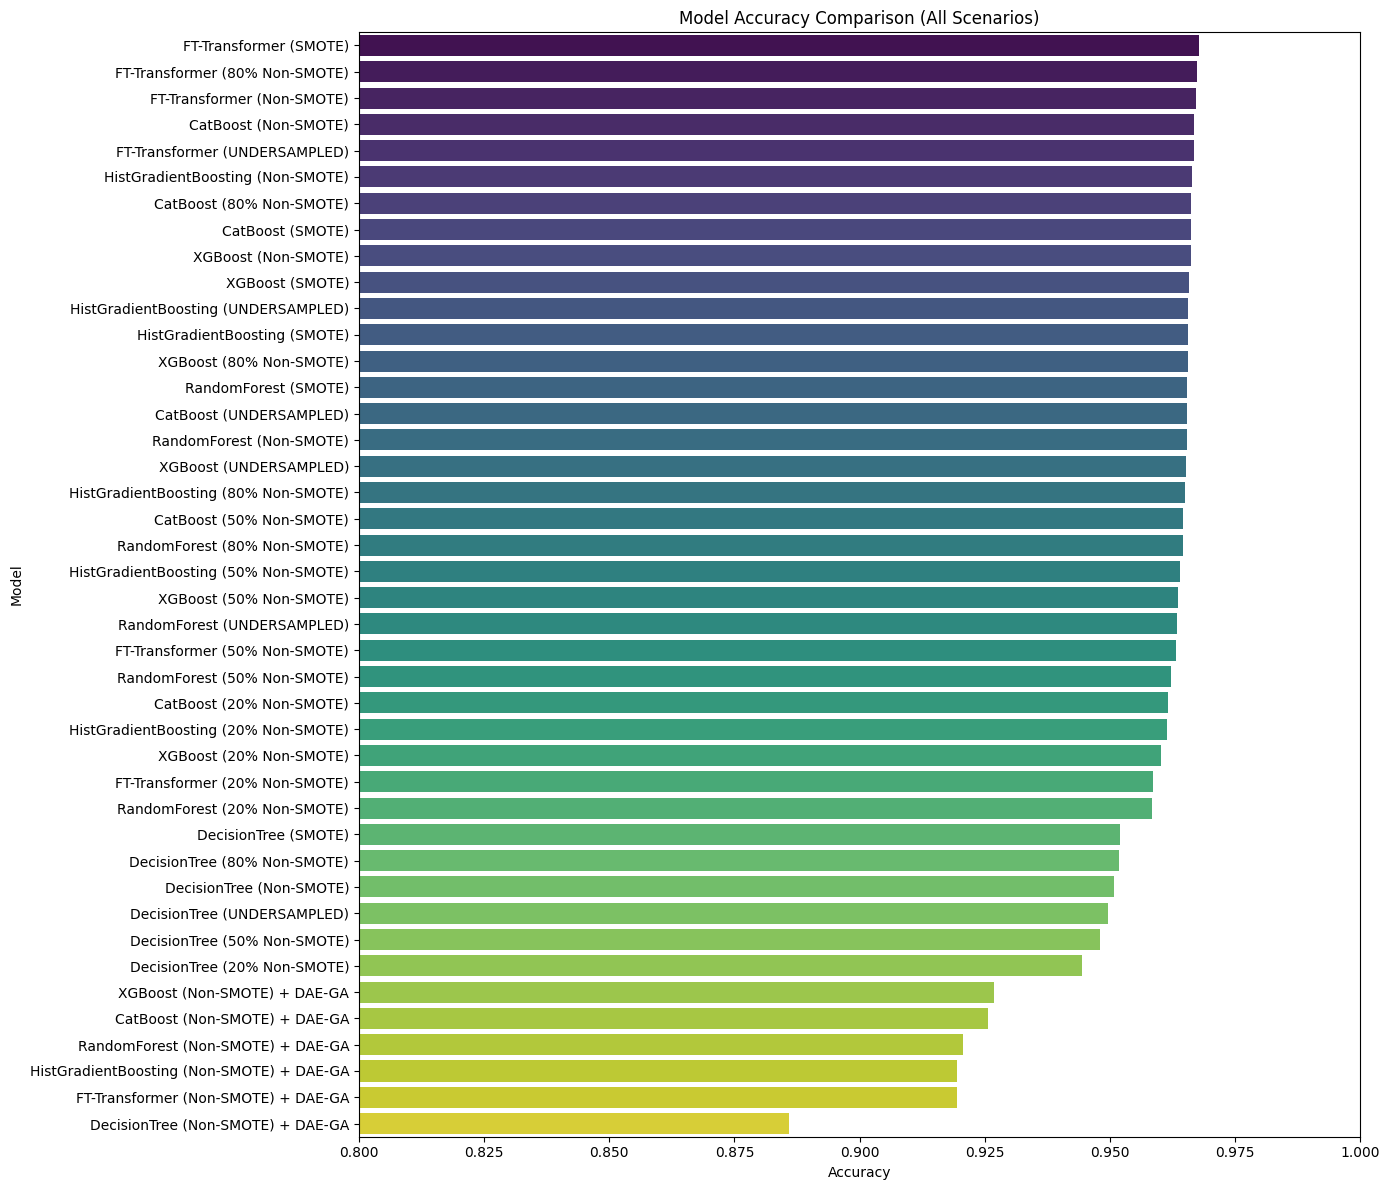

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 12))
sns.barplot(
    data=performance_df.sort_values("Accuracy", ascending=False),
    x="Accuracy",
    y="Model",
    palette="viridis"
)
plt.title("Model Accuracy Comparison (All Scenarios)")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0.80, 1.0)  # adjust sesuai skala kamu
plt.tight_layout()
plt.show()


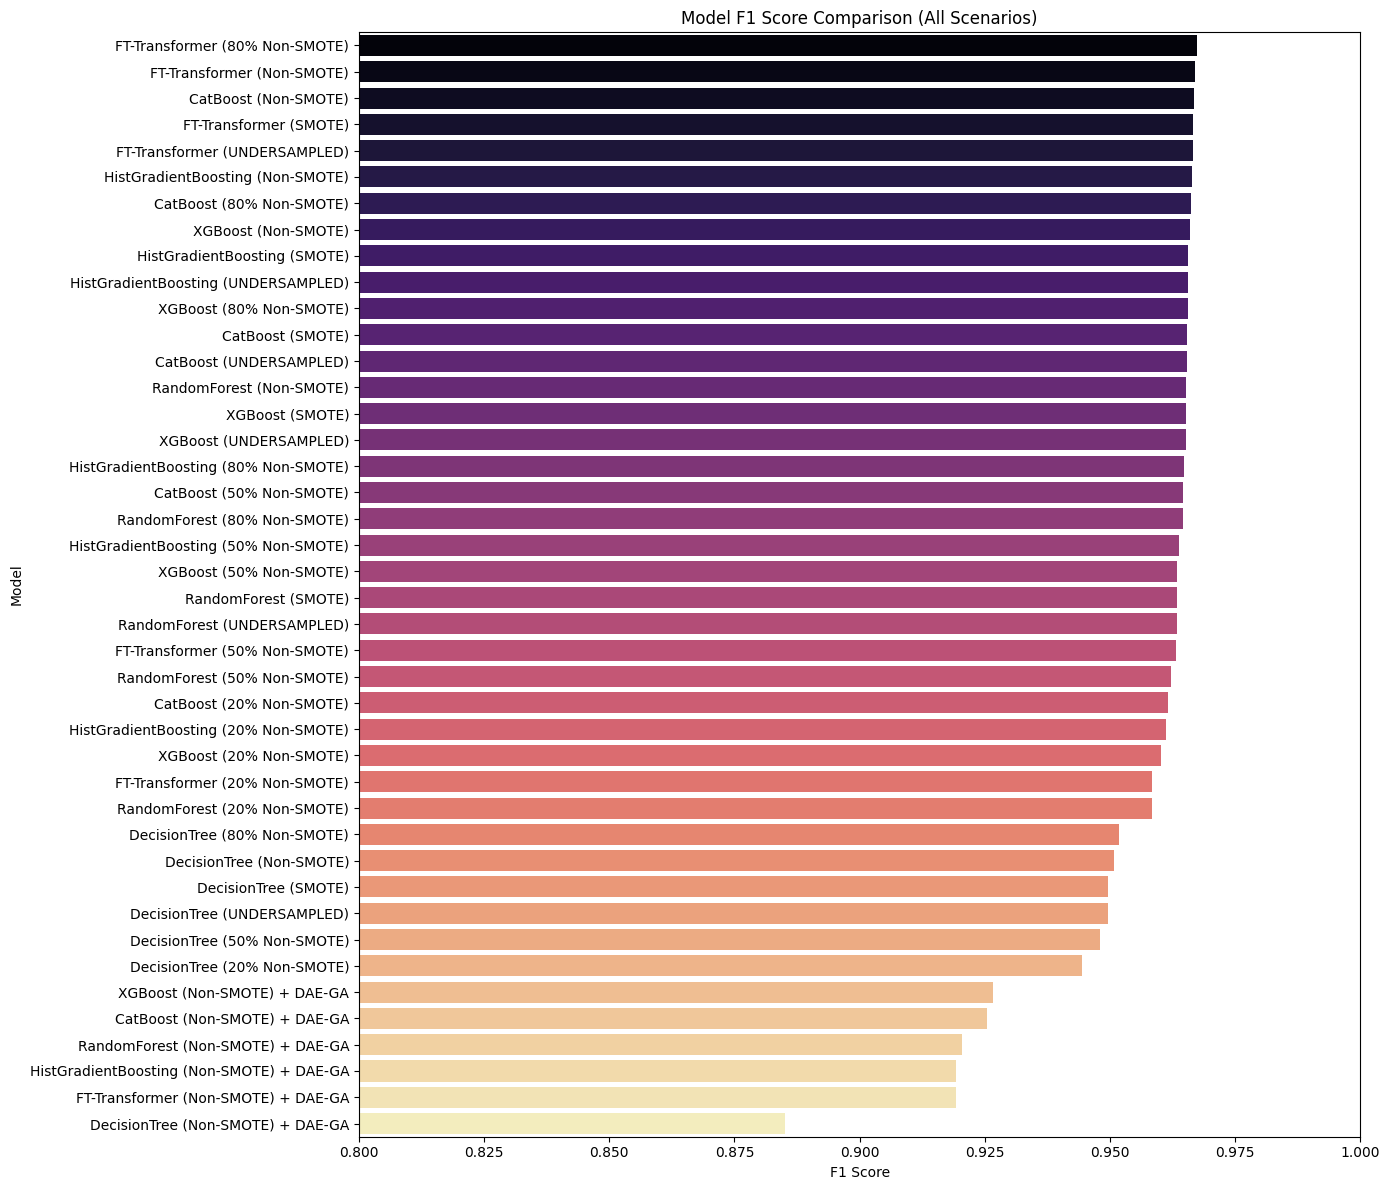

In [100]:
plt.figure(figsize=(14, 12))
sns.barplot(
    data=performance_df.sort_values("F1 Score", ascending=False),
    x="F1 Score",
    y="Model",
    palette="magma"
)
plt.title("Model F1 Score Comparison (All Scenarios)")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.xlim(0.80, 1.0) 
plt.tight_layout()
plt.show()

In [101]:
# ============================================================
# LEARNING CURVE DATAFRAME: 20%, 50%, 80%, 100% NON-SMOTE
# ============================================================

lc_data = []

# Helper kecil biar gak ngulang if-else
def add_lc_row(model_name, size_pct, acc_value):
    lc_data.append((model_name, size_pct, acc_value))

# HistGBDT
add_lc_row("HistGBDT", 20, acc_hist_20)
add_lc_row("HistGBDT", 50, acc_hist_50)
add_lc_row("HistGBDT", 80, acc_hist_80)
add_lc_row("HistGBDT", 100, acc_hist_full)

# XGBoost
add_lc_row("XGBoost", 20, acc_xgb_20)
add_lc_row("XGBoost", 50, acc_xgb_50)
add_lc_row("XGBoost", 80, acc_xgb_80)
add_lc_row("XGBoost", 100, acc_xgb_full)

# CatBoost
add_lc_row("CatBoost", 20, acc_cat_20)
add_lc_row("CatBoost", 50, acc_cat_50)
add_lc_row("CatBoost", 80, acc_cat_80)
add_lc_row("CatBoost", 100, acc_cat_full)

# RandomForest
add_lc_row("RandomForest", 20, acc_rf_20)
add_lc_row("RandomForest", 50, acc_rf_50)
add_lc_row("RandomForest", 80, acc_rf_80)
add_lc_row("RandomForest", 100, acc_rf_full)

# DecisionTree
add_lc_row("DecisionTree", 20, acc_dt_20)
add_lc_row("DecisionTree", 50, acc_dt_50)
add_lc_row("DecisionTree", 80, acc_dt_80)
add_lc_row("DecisionTree", 100, acc_dt_full)

# FT-Transformer
add_lc_row("FTTransformer", 20, best_val_acc_ft_20)
add_lc_row("FTTransformer", 50, best_val_acc_ft_50)
add_lc_row("FTTransformer", 80, best_val_acc_ft_80)
add_lc_row("FTTransformer", 100, acc_ft_full)

lc_df = pd.DataFrame(lc_data, columns=["Model", "Training Size (%)", "Accuracy"])


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

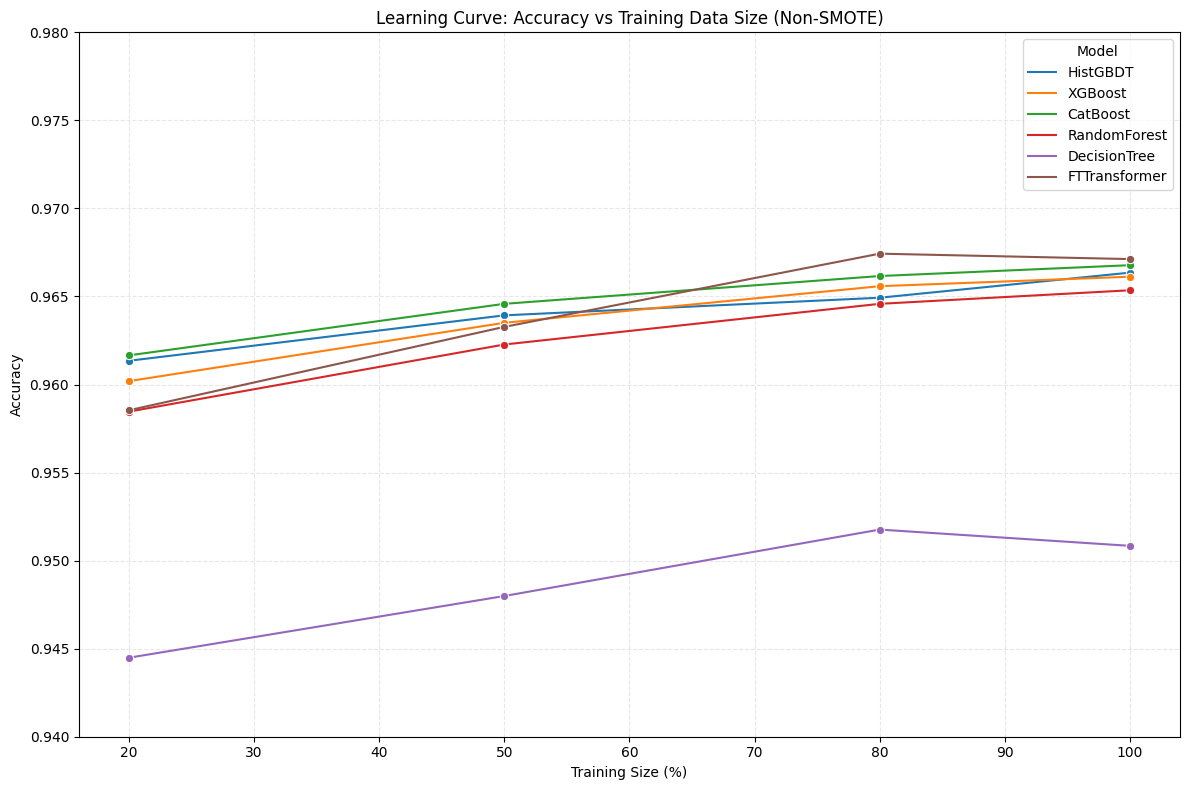

In [104]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=lc_df,
    x="Training Size (%)",
    y="Accuracy",
    hue="Model",
    marker="o"
)
plt.title("Learning Curve: Accuracy vs Training Data Size (Non-SMOTE)")
plt.xlabel("Training Size (%)")
plt.ylabel("Accuracy")
plt.ylim(0.94, 0.98) 
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [106]:
data_size_perf = lc_df.pivot(index="Model", columns="Training Size (%)", values="Accuracy")

# 2. Sort by the highest accuracy at 100% training size
data_size_perf = data_size_perf.sort_values(by=100, ascending=False)

# 3. Display the table
data_size_perf

Training Size (%),20,50,80,100
Model,,,,
FTTransformer,0.958539,0.963274,0.967431,0.967123
CatBoost,0.961657,0.964583,0.966161,0.966777
HistGBDT,0.961349,0.963928,0.964929,0.966354
XGBoost,0.960194,0.963505,0.965584,0.966123
RandomForest,0.958462,0.962273,0.964583,0.965353
DecisionTree,0.944487,0.947990,0.951763,0.950839


## Conclusion and Analysis

### Scenario 1 (DAE-GA Ablation Study)
1. The result shows that the model with dataset that's preprocessed with DAE-GA performs worse than the model with dataset that's using standard preprocessing (normalization & standardization).
2. The performance decrease of all is shown in the tabel below
| Model | Accuracy | F1 Score |
| :--- | :--- | :--- |
| FT-Transformer | 4,93% | 4,95% |
| HistGBDT | 5,10% | 5,12% |
| XGBoost | 4,06% | 4,08% |
| CatBoost | 4,25% | 4,27% |
| Random Forest | 4,63% | 4,65% |
| Decision Tree | 6,83% | 6,90% |
| Average Performance Decrease | 4,97% | 4,99% |

3. In average, there is 4.97% accuracy and 4.99% F1 Score decrease when using Deep AutoEncoder + Genetic Algorithm compared to original dataset. Because each features is individually important and contain densely unique information (shown by correlation matrix), when we try to compress the features from 23 to 16 using Deep AutoEncoder and further reduce it again using Genetic Algorithm, it causes some dense features transformed into entangled latent feature that may be a combination of non-linear feature (because Deep AutoEncoder is black box model), it caused massive information loss that discard some important information for classification. Thus, this resulted in the decrease of accuracy and F1 score.
4. Feature reduction using the Deep AutoEncoder resulted in a destructive feature transformation, where information-dense attributes were converted into abstract representations that hindered the convergence of the classification model. Furthermore, the subsequent feature selection process by the Genetic Algorithm exacerbated this issue by causing additional information loss.
5. In conclusion, for this specific dataset, utilizing the complete set of original features is more optimal than employing the reduced feature set generated by the DAE-GA method.

### Scenario 2 (Data Resampling)

| Model | Accuracy | F1 Score |
| :--- | :--- | :--- |
| FT-Transformer (SMOTE) | 0.967855 | 0.966655 |
| FT-Transformer (Non-SMOTE) | 0.967123 | 0.967063 |
| CatBoost (Non-SMOTE) | 0.966777 | 0.966728 |
| FT-Transformer (UNDERSAMPLED) | 0.966700 | 0.966655 |
| HistGradientBoosting (Non-SMOTE) | 0.966354 | 0.966296 |
| CatBoost (SMOTE) | 0.966161 | 0.965370 |
| XGBoost (Non-SMOTE) | 0.966123 | 0.966071 |
| XGBoost (SMOTE) | 0.965892 | 0.965217 |
| HistGradientBoosting (UNDERSAMPLED) | 0.965661 | 0.965629 |
| HistGradientBoosting (SMOTE) | 0.965584 | 0.965629 |
| RandomForest (SMOTE) | 0.965391 | 0.963441 |
| CatBoost (UNDERSAMPLED) | 0.965391 | 0.965370 |
| RandomForest (Non-SMOTE) | 0.965353 | 0.965292 |
| XGBoost (UNDERSAMPLED) | 0.965237 | 0.965217 |
| RandomForest (UNDERSAMPLED) | 0.963466 | 0.963441 |
| DecisionTree (SMOTE) | 0.951994 | 0.949677 |
| DecisionTree (Non-SMOTE) | 0.950839 | 0.950814 |
| DecisionTree (UNDERSAMPLED) | 0.949646 | 0.949677 |
    
1. The result shows that in some model (FT-Transformer, Random Forest, Decision Tree), using SMOTE oversampling shows little improvement in accuracy but lower F1 Score compared to its non-sampling dataset. In other models, the undersampling and SMOTE does not show improvement compared to original dataset.
2. In conclusion, the resampling strategy does not affect significantly to the performance because the original dataset is relatively balanced (56%:44%).

### Scenario 3 (Data Scalability)

| Training Size (%) | 20 | 50 | 80 | 100 |
| :--- | :--- | :--- | :--- | :--- |
| Model | | | | |				
| FTTransformer | 0.958539 | 0.963274 | 0.967431 | 0.967123 |
| CatBoost | 0.961657 | 0.964583 | 0.966161 | 0.966777 |
| HistGBDT | 0.961349 | 0.963928 | 0.964929	| 0.966354 |
| XGBoost | 0.960194 | 0.963505 | 0.965584 | 0.966123 |
| RandomForest | 0.958462 | 0.962273 | 0.964583 | 0.965353 |
| DecisionTree | 0.944487 |	0.947990 | 0.951763 | 0.950839 |

1. According to the table above and learning curve, All models show the accuracy improvement from training using 20% data into 100% data from the original dataset with the exception of FT-Transformer model shows slightly decrease in performance with 100% data compared to 80% data.
2. FT-Transformer model shows the most significant increase over data growth with the increase about 0.91% from 20% to 80% data size.
3. In 20% data scenario, ensemble learning (CatBoost, HistGBDT, XGBoost) shows domination than other model.
4. In 80% data, FT-Transformer gives the highest accuracy among the other scenarios and models. This proves that deep learning architecture offers superior predictive capability once the volume of data crosses a specific threshold.